# Imports

In [1]:
# Remove duplicate imports and sort them alphabetically
import itertools
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd
import pmdarima as pm
import seaborn as sns
import scipy.stats as stats
from scipy.stats import boxcox
import warnings

from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, kpss
import statsmodels.api as sm
from statsmodels.tools.sm_exceptions import ConvergenceWarning, ValueWarning

import xgboost as xgb

from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential

warnings.filterwarnings("ignore", category=ValueWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)


# Import Dataset

The Dataset with the following columns is imported

used variables:
- Total vehicles sold (Target)
    - Company car tax rate (%)
    - Google  Home charging (G)
    - Consumer confidence (E)
    - Gasoline (Euro95) - Average price (F)





In [2]:
# Load data
df = pd.read_csv(r"C:\Users\dylan\OneDrive - HvA\AAI Master\BLOK 3 afstuderen\Thesis\Eigenwerk\DATASET\Final.CSV")
df["Time Period (T)"] = pd.to_datetime(df["Time Period (T)"], format="%Y-%m-%d")
df = df.sort_values("Time Period (T)").reset_index(drop=True)
display(df.head())

Time Period (T)  Company car tax rate (%)  Home charging (G)  \
0      2007-01-01                        22                  0   
1      2007-02-01                        22                  0   
2      2007-03-01                        22                  0   
3      2007-04-01                        22                  0   
4      2007-05-01                        22                  0   

   Consumer confidence (E)  Gasoline (Euro95) - Average price (F)  \
0                     20.0                               1.303032   
1                     20.0                               1.325357   
2                     20.0                               1.379032   
3                     20.0                               1.426500   
4                     18.0                               1.466516   

   Total vehicles sold (Target)  
0                            31  
1                            39  
2                           123  
3                            62  
4                            84


> Following the steps for producing forcasts for time series data from Forecasting: Principles and Practice, the Pythonic Way, will be broken down into the following steps:

A structured process for producing forecasts:

1. Prepare the data (cleaning, formatting)

2. Visualize to identify patterns

3. Specify a model

4. Train the model

5. Evaluate performance

6. Generate forecasts

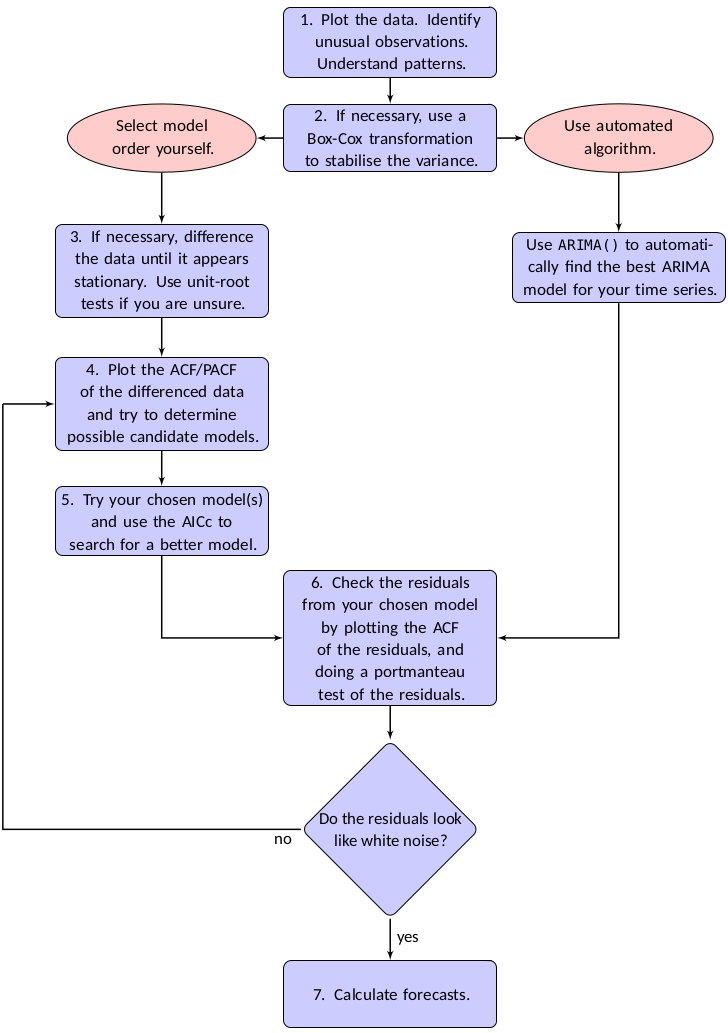



# 1. Prepare the data (cleaning, formatting) this was done in 
C:\Users\dylan\Trying hard\Tryhard\100%\Preprocessing.ipynb 

# 2. Visualize to identify patterns

to visualize and identify patterns in the data, we will use:
1. time series plots: here we can see 
these plots enable many features of the data to be visualised, including patterns, unusual observations, changes over time, and relationships between variables.
2. Scatterplot matrix:
    is used to explore relationships between time series.
3. Correlation matrix:
    is used to explore relationships between time series.

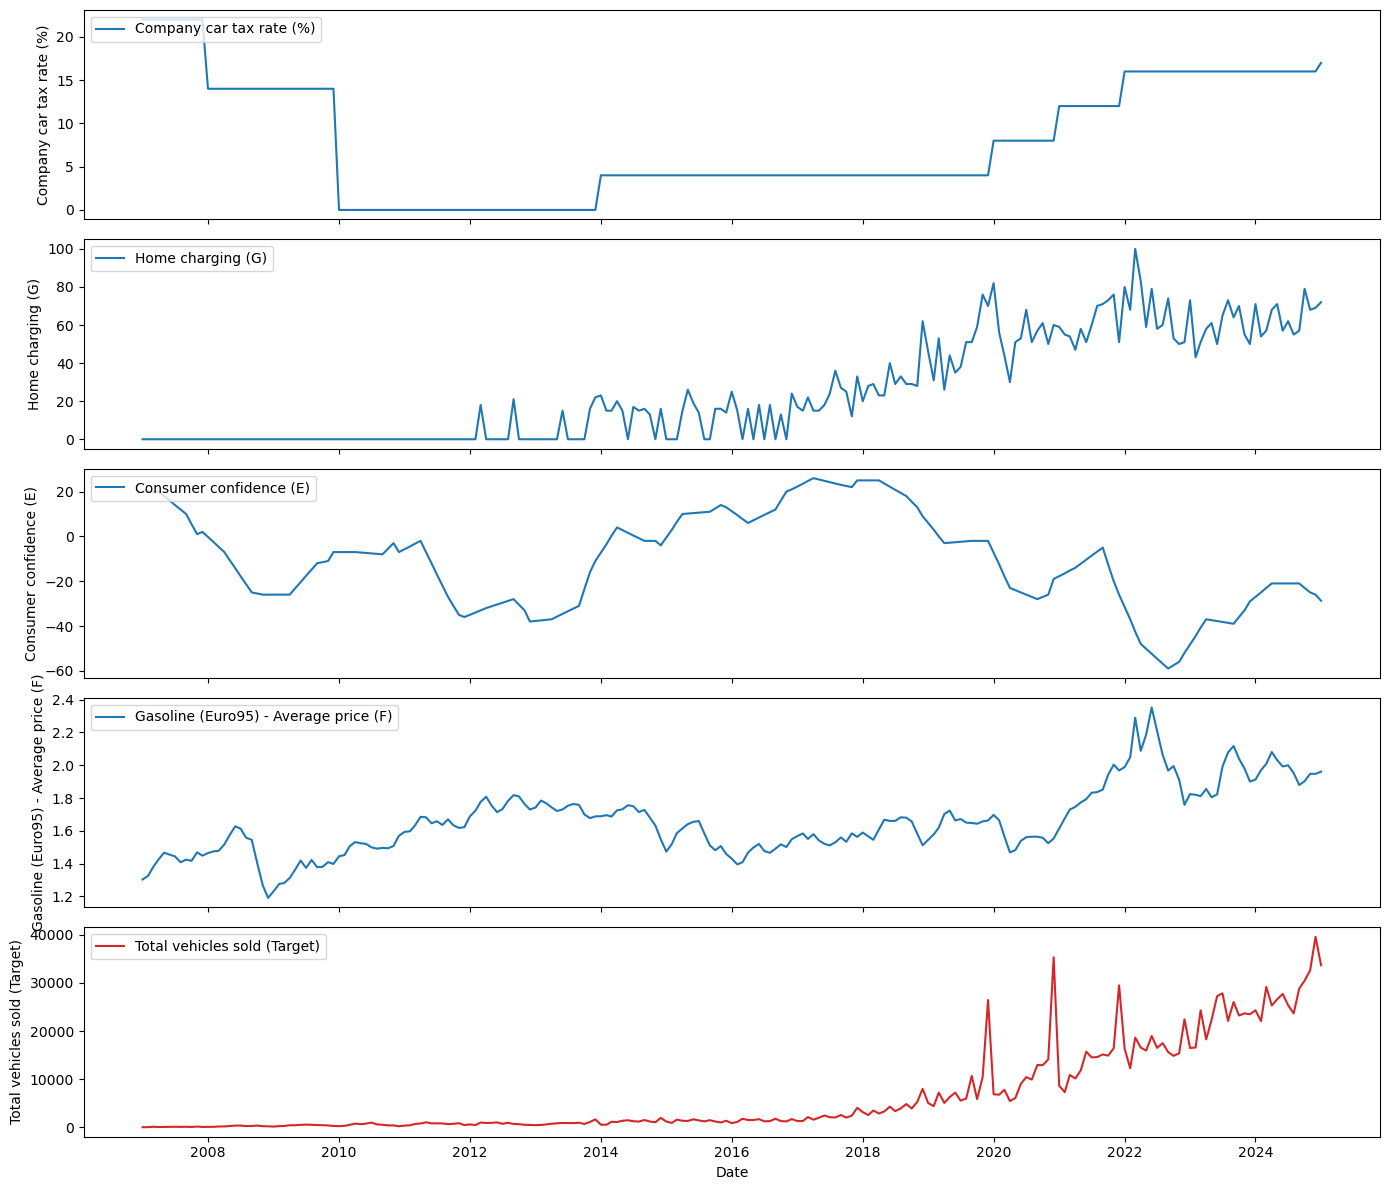

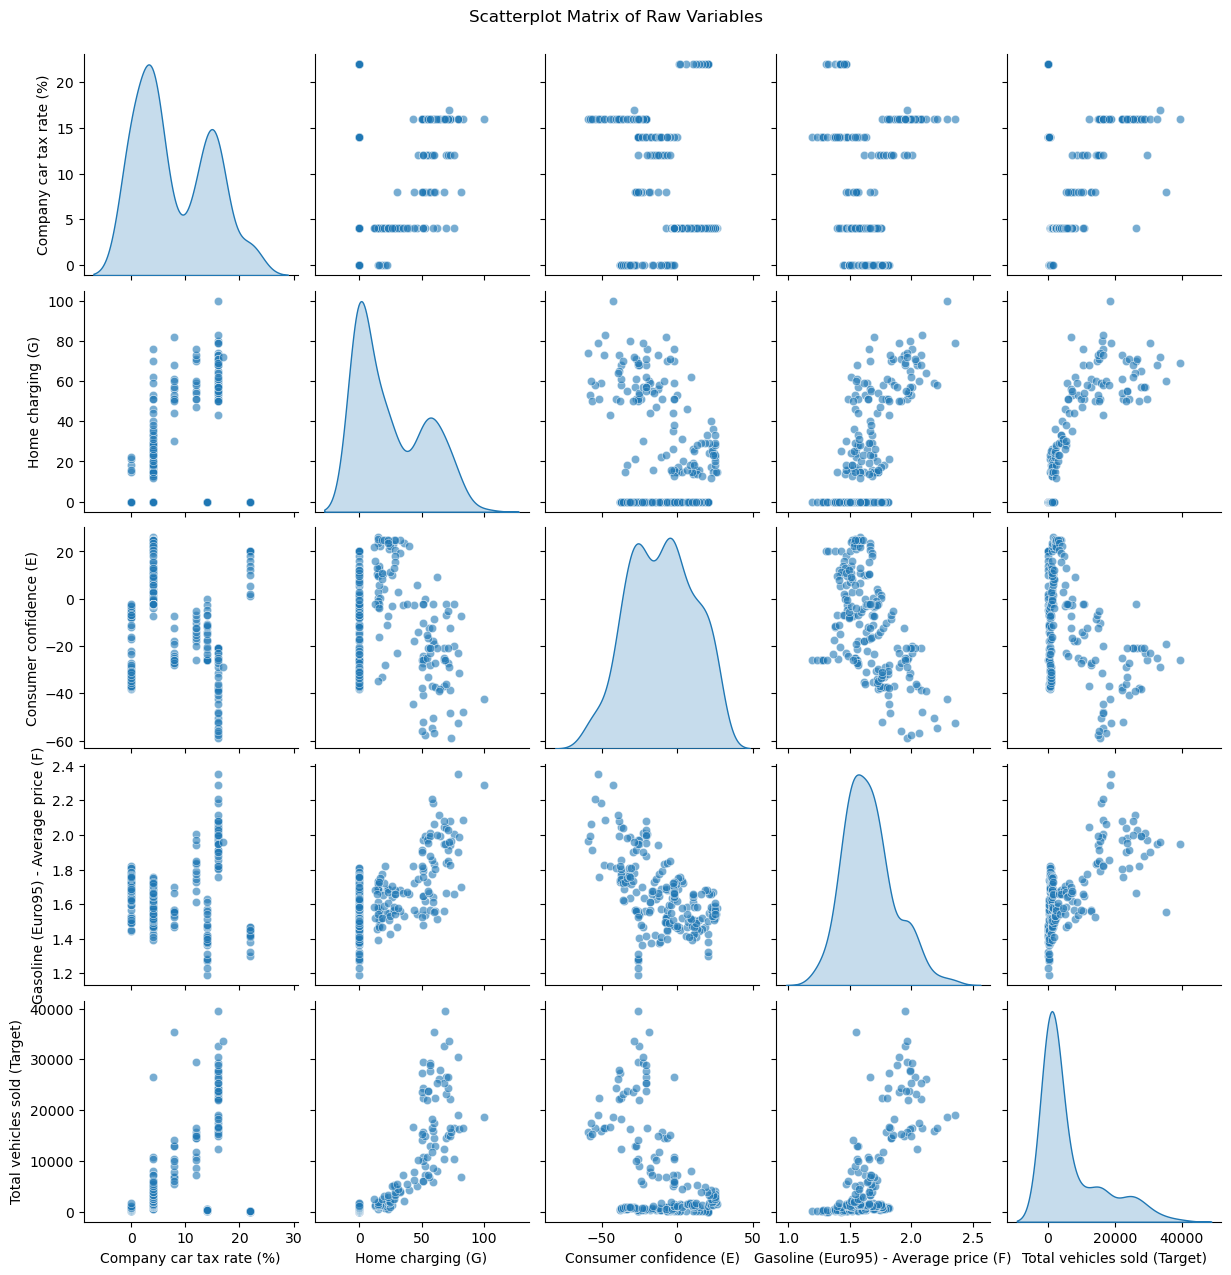

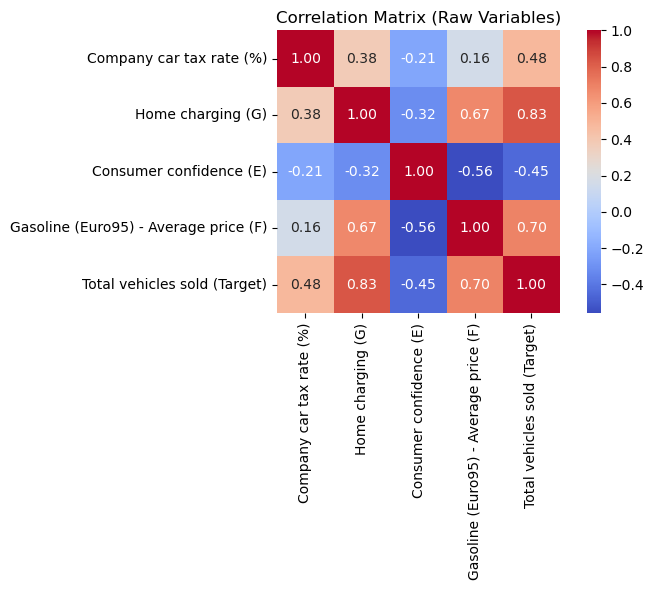

In [3]:
# Define features and target
features = ['Company car tax rate (%)', 'Home charging (G)', 'Consumer confidence (E)', 'Gasoline (Euro95) - Average price (F)']
target = 'Total vehicles sold (Target)'

fig, axs = plt.subplots(len(features) + 1, 1, figsize=(14, 12), sharex=True)

for i, col in enumerate(features):
    axs[i].plot(df["Time Period (T)"], df[col], label=col)
    axs[i].set_ylabel(col)
    axs[i].legend(loc="upper left")

axs[-1].plot(df["Time Period (T)"], df[target], label=target, color='tab:red')
axs[-1].set_ylabel(target)
axs[-1].set_xlabel("Date")
axs[-1].legend(loc="upper left")

plt.tight_layout()
plt.show()

# Scatterplot matrix (pairplot) for all features and target
sns.pairplot(df[features + [target]], diag_kind="kde", plot_kws={'alpha':0.6})
plt.suptitle("Scatterplot Matrix of Raw Variables", y=1.02)
plt.show()

# Correlation matrix for all features and target
corr_matrix = df[features + [target]].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix (Raw Variables)")
plt.tight_layout()
plt.show()


## Observations first plots 

> Talk about Trends: upward or downward drift over years.

Seasonality: recurring cycles (e.g., year-end sales spike).

Structural breaks: sudden shifts or regime changes.

Outliers: one-off jumps or drops.

key observations from the scattorplot matrix:

- Home charging and gasoline price show a moderately positive association with total vehicles sold, as indicated by the upward trend in their scatterplots.

- Company car tax rate appears to have a non-linear relationship with total vehicles sold; vehicle sales tend to increase when tax rates are lower.

- Consumer confidence shows a weaker, noisier relationship with vehicle sales, though a vague upward trend is present.

- Home charging shows strong positive correlation with gasoline prices, potentially reflecting a structural shift in energy preference.

# 3. Model Specification (NOG Afmaken)



My baseline approach will be: .... and  will integrate exogenous drivers:
using Arima, 

# 4. Data Split & Transformations

## 4a Apply train/val/test split

In [4]:
# Define features and target (raw data)
features_raw = ['Company car tax rate (%)', 'Home charging (G)', 'Consumer confidence (E)', 'Gasoline (Euro95) - Average price (F)']
target_raw = 'Total vehicles sold (Target)'

# Calculate split indices
n = len(df)
train_end = int(n * 0.8)
val_end = int(n * 0.9)

# Split the target (raw)
y_raw = df[target_raw]
y_train_raw = y_raw.iloc[:train_end]
y_val_raw = y_raw.iloc[train_end:val_end]
y_test_raw = y_raw.iloc[val_end:]

# Split each feature separately (raw)
companytax_train_raw = df['Company car tax rate (%)'].iloc[:train_end]
companytax_val_raw = df['Company car tax rate (%)'].iloc[train_end:val_end]
companytax_test_raw = df['Company car tax rate (%)'].iloc[val_end:]

homechg_train_raw = df['Home charging (G)'].iloc[:train_end]
homechg_val_raw = df['Home charging (G)'].iloc[train_end:val_end]
homechg_test_raw = df['Home charging (G)'].iloc[val_end:]

conf_train_raw = df['Consumer confidence (E)'].iloc[:train_end]
conf_val_raw = df['Consumer confidence (E)'].iloc[train_end:val_end]
conf_test_raw = df['Consumer confidence (E)'].iloc[val_end:]

gas_train_raw = df['Gasoline (Euro95) - Average price (F)'].iloc[:train_end]
gas_val_raw = df['Gasoline (Euro95) - Average price (F)'].iloc[train_end:val_end]
gas_test_raw = df['Gasoline (Euro95) - Average price (F)'].iloc[val_end:]


# Print sizes
print(f"Train: {df['Time Period (T)'].iloc[y_train_raw.index[0]]} to {df['Time Period (T)'].iloc[y_train_raw.index[-1]]} | {len(y_train_raw)/n:.1%} of data")
print(f"Val:   {df['Time Period (T)'].iloc[y_val_raw.index[0]]} to {df['Time Period (T)'].iloc[y_val_raw.index[-1]]} | {len(y_val_raw)/n:.1%} of data")
print(f"Test:  {df['Time Period (T)'].iloc[y_test_raw.index[0]]} to {df['Time Period (T)'].iloc[y_test_raw.index[-1]]} | {len(y_test_raw)/n:.1%} of data")
print(f"Train size: {len(y_train_raw)}, Val size: {len(y_val_raw)}, Test size: {len(y_test_raw)}")




Train: 2007-01-01 00:00:00 to 2021-05-01 00:00:00 | 79.7% of data
Val:   2021-06-01 00:00:00 to 2023-03-01 00:00:00 | 10.1% of data
Test:  2023-04-01 00:00:00 to 2025-01-01 00:00:00 | 10.1% of data
Train size: 173, Val size: 22, Test size: 22


#### Deze plot zou ook weggelaten kunnen worden 

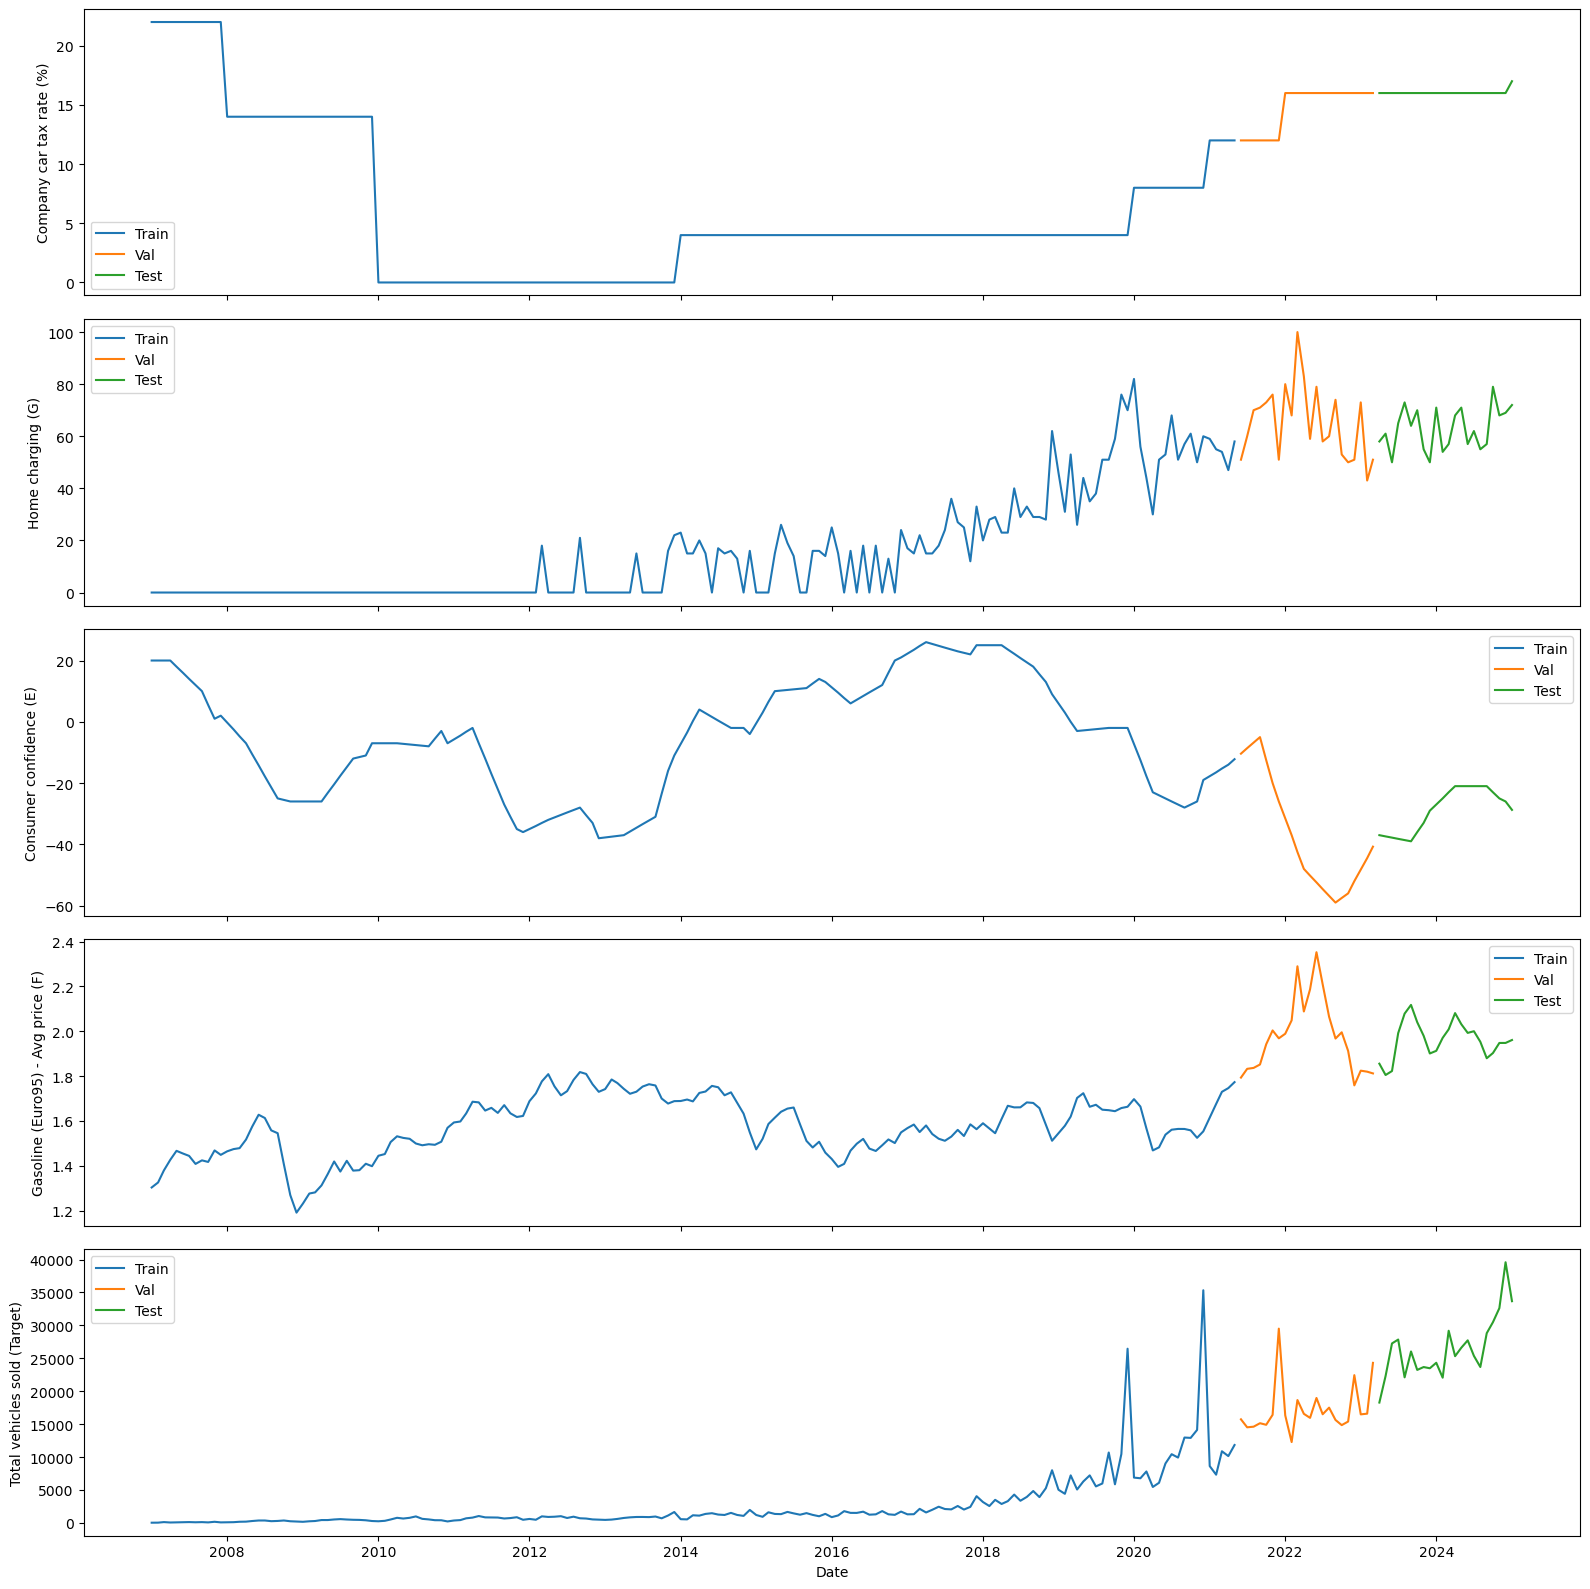

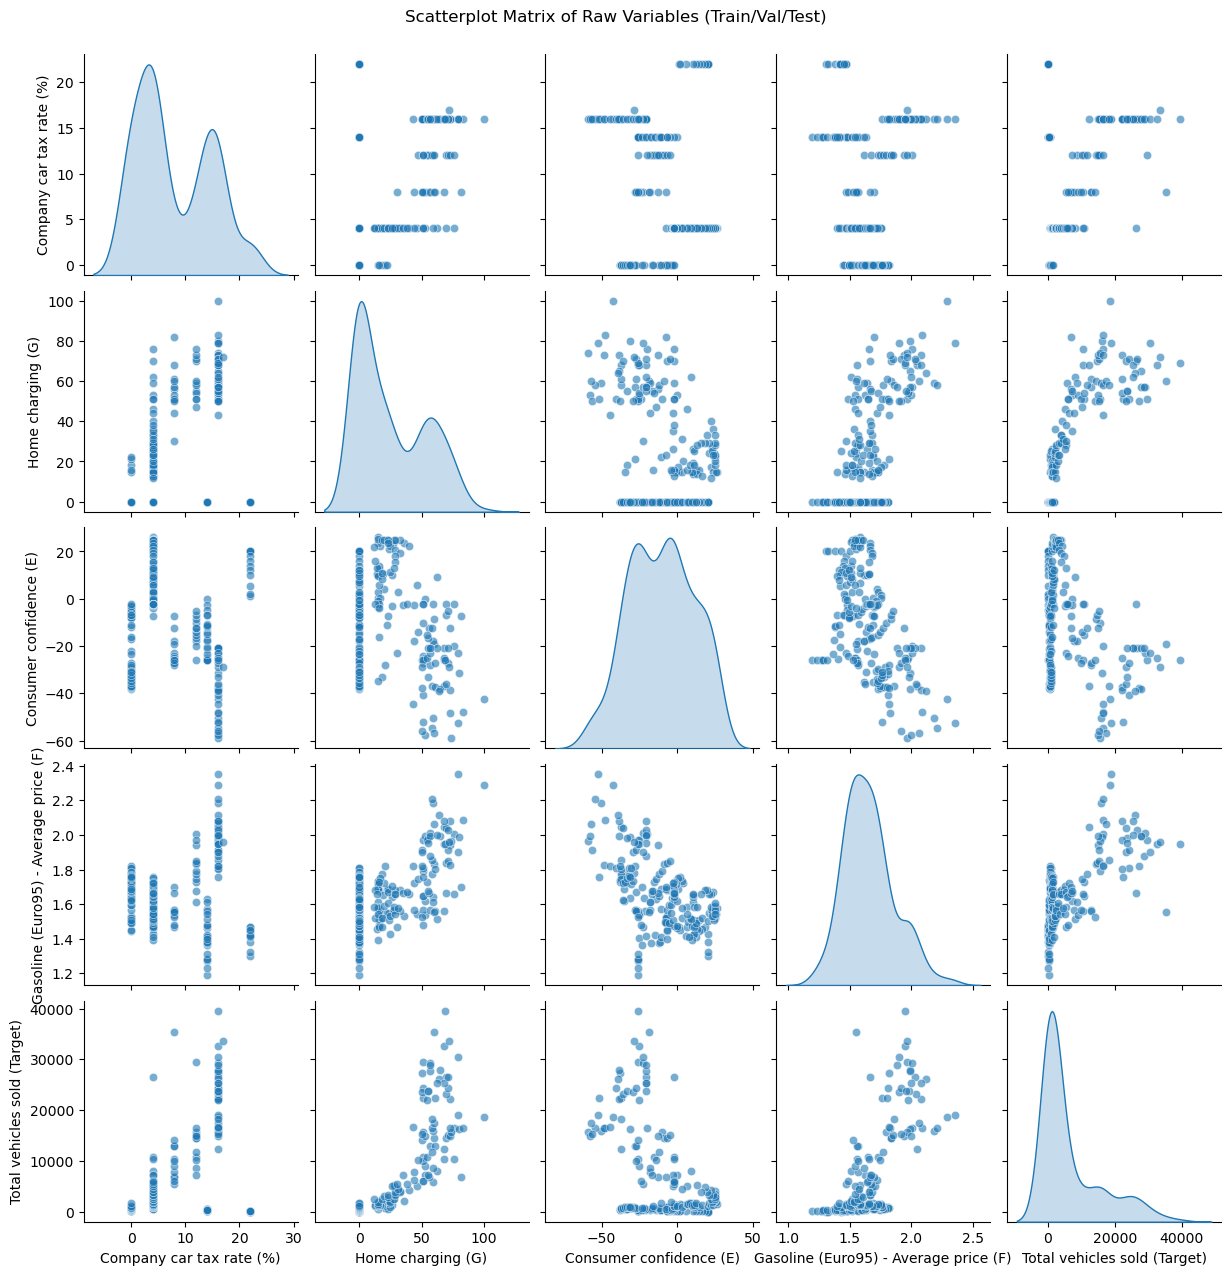

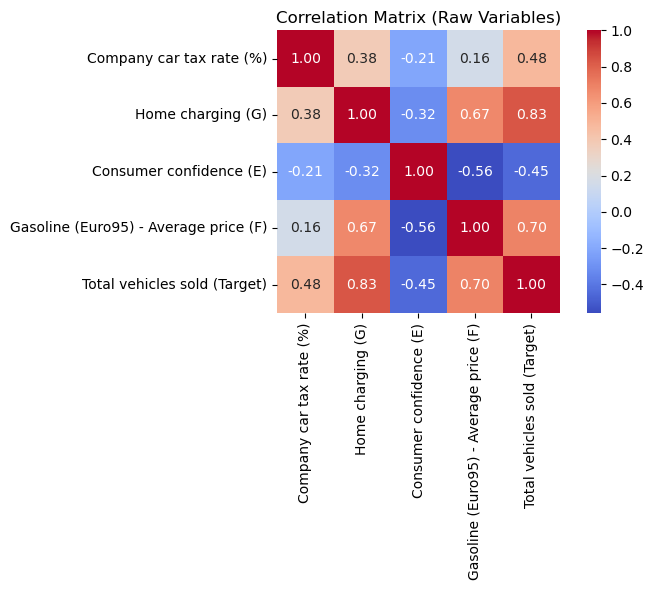

=== Unit Root Tests (ADF/KPSS) on Raw Train Splits ===
Company car tax rate (%)
  ADF: stat=-2.418, p=0.137 | Non-stationary
  KPSS: stat=0.584, p=0.0241 | Non-stationary

Home charging (G)
  ADF: stat=0.083, p=0.965 | Non-stationary
  KPSS: stat=1.618, p=0.01 | Non-stationary

Consumer confidence (E)
  ADF: stat=-2.337, p=0.16 | Non-stationary
  KPSS: stat=0.328, p=0.1 | Stationary

Gasoline (Euro95) - Average price (F)
  ADF: stat=-3.250, p=0.0173 | Stationary
  KPSS: stat=0.507, p=0.04 | Non-stationary

Total vehicles sold (Target)
  ADF: stat=6.289, p=1 | Non-stationary
  KPSS: stat=1.296, p=0.01 | Non-stationary



C:\Users\dylan\AppData\Local\Temp\ipykernel_24056\1550215762.py:65: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_p, _, kpss_crit = kpss(series, regression='c', nlags="auto")
C:\Users\dylan\AppData\Local\Temp\ipykernel_24056\1550215762.py:65: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_p, _, kpss_crit = kpss(series, regression='c', nlags="auto")
C:\Users\dylan\AppData\Local\Temp\ipykernel_24056\1550215762.py:65: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_p, _, kpss_crit = kpss(series, regression='c', nlags="auto")


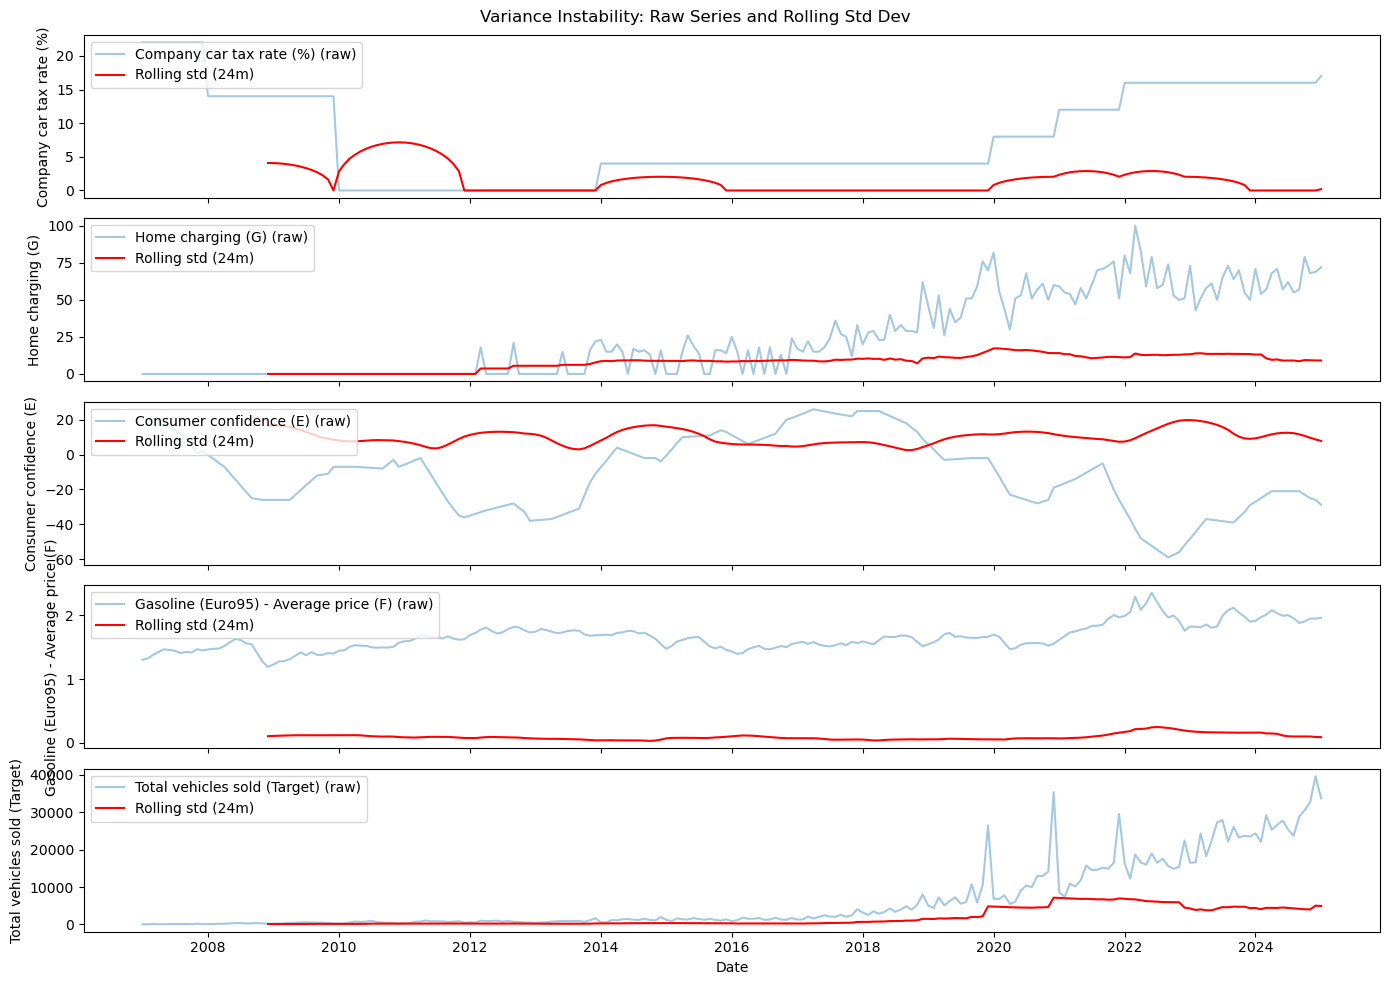

In [5]:
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, kpss


fig, axs = plt.subplots(5, 1, figsize=(16, 16), sharex=True)

# 1. Company car tax rate (%)
axs[0].plot(df['Time Period (T)'].iloc[:train_end], companytax_train_raw, label='Train')
axs[0].plot(df['Time Period (T)'].iloc[train_end:val_end], companytax_val_raw, label='Val')
axs[0].plot(df['Time Period (T)'].iloc[val_end:], companytax_test_raw, label='Test')
axs[0].set_ylabel('Company car tax rate (%)')
axs[0].legend()

# 2. Home charging (G)
axs[1].plot(df['Time Period (T)'].iloc[:train_end], homechg_train_raw, label='Train')
axs[1].plot(df['Time Period (T)'].iloc[train_end:val_end], homechg_val_raw, label='Val')
axs[1].plot(df['Time Period (T)'].iloc[val_end:], homechg_test_raw, label='Test')
axs[1].set_ylabel('Home charging (G)')
axs[1].legend()

# 3. Consumer confidence (E)
axs[2].plot(df['Time Period (T)'].iloc[:train_end], conf_train_raw, label='Train')
axs[2].plot(df['Time Period (T)'].iloc[train_end:val_end], conf_val_raw, label='Val')
axs[2].plot(df['Time Period (T)'].iloc[val_end:], conf_test_raw, label='Test')
axs[2].set_ylabel('Consumer confidence (E)')
axs[2].legend()

# 4. Gasoline (Euro95) - Average price (F)
axs[3].plot(df['Time Period (T)'].iloc[:train_end], gas_train_raw, label='Train')
axs[3].plot(df['Time Period (T)'].iloc[train_end:val_end], gas_val_raw, label='Val')
axs[3].plot(df['Time Period (T)'].iloc[val_end:], gas_test_raw, label='Test')
axs[3].set_ylabel('Gasoline (Euro95) - Avg price (F)')
axs[3].legend()

# 5. Total vehicles sold (Target)
axs[4].plot(df['Time Period (T)'].iloc[:train_end], y_train_raw, label='Train')
axs[4].plot(df['Time Period (T)'].iloc[train_end:val_end], y_val_raw, label='Val')
axs[4].plot(df['Time Period (T)'].iloc[val_end:], y_test_raw, label='Test')
axs[4].set_ylabel('Total vehicles sold (Target)')
axs[4].set_xlabel('Date')
axs[4].legend()

plt.tight_layout()
plt.show()

# Scatter plot matrix (pairplot) for all features and target (raw splits)

sns.pairplot(df[features_raw + [target_raw]], diag_kind="kde", plot_kws={'alpha':0.6})
plt.suptitle("Scatterplot Matrix of Raw Variables (Train/Val/Test)", y=1.02)
plt.show()

# Correlation matrix for all features and target (raw splits)
corr_matrix = df[features_raw + [target_raw]].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix (Raw Variables)")
plt.tight_layout()
plt.show()

# --- Unit root (ADF/KPSS) and variance instability plots for raw splits ---


def adf_kpss_summary(series, name):
    adf_stat, adf_p, _, _, adf_crit, _ = adfuller(series, autolag='AIC', maxlag=12, regression='c', store=False)
    kpss_stat, kpss_p, _, kpss_crit = kpss(series, regression='c', nlags="auto")
    print(f"\033[1m{name}\033[0m")
    print(f"  ADF: stat={adf_stat:.3f}, p={adf_p:.3g} | {'Stationary' if adf_p < 0.05 else 'Non-stationary'}")
    print(f"  KPSS: stat={kpss_stat:.3f}, p={kpss_p:.3g} | {'Non-stationary' if kpss_p < 0.05 else 'Stationary'}")
    print()

print("=== Unit Root Tests (ADF/KPSS) on Raw Train Splits ===")
for col, train_split in zip(features_raw + [target_raw],
                            [companytax_train_raw, homechg_train_raw, conf_train_raw, gas_train_raw, y_train_raw]):
    adf_kpss_summary(train_split, col)

# --- Variance instability: rolling std plot for each variable (raw) ---
window = 24 # 2 years for monthly data

fig, axs = plt.subplots(len(features_raw) + 1, 1, figsize=(14, 10), sharex=True)
for i, col in enumerate(features_raw + [target_raw]):
    rolling_std = df[col].rolling(window=window).std() # kan aangepast woorden naar varience var 
    axs[i].plot(df["Time Period (T)"], df[col], alpha=0.4, label=f"{col} (raw)")
    axs[i].plot(df["Time Period (T)"], rolling_std, color='red', label=f"Rolling std ({window}m)")
    axs[i].set_ylabel(col)
    axs[i].legend(loc="upper left")
axs[-1].set_xlabel("Date")
plt.suptitle("Variance Instability: Raw Series and Rolling Std Dev")
plt.tight_layout()
plt.show()


> Since there is alot of varience i will add boxcox transformation to the data, this will help to stabilize the variance and make the data more suitable for modeling.

## 4b Yeo–Johnson transformation 

Yeo–Johnson (like Box–Cox) primarily targets skewness—it finds a power transform that makes the distribution more symmetric and stabilizes variance globally. But time‐series variance often shifts because of:

Trends or level changes

Seasonal effects (e.g. summer peaks vs. winter troughs)

Structural breaks or exogenous shocks

In [21]:
# 1. Fit Yeo–Johnson on train and transform all
from sklearn.preprocessing import PowerTransformer  # Import PowerTransformer for Yeo–Johnson transformation

features_yj = features_raw.copy()  # Copy the list of raw feature names for transformation
target_yj   = target_raw           # Set the target variable name for transformation

yeojohnson_all      = {}           # Dictionary to store transformed values for each column
yeojohnson_lambdas_all = {}        # Dictionary to store the lambda parameter for each column

for col in features_yj + [target_yj]:  # Loop through all features and the target
    train_series = df[col].iloc[:train_end].values.reshape(-1, 1)  # Get training data for the column and reshape for transformer
    pt = PowerTransformer(method='yeo-johnson', standardize=False) # Create transformer (no standardization)
    pt.fit(train_series)                                           # Fit transformer on training data only
    yeojohnson_lambdas_all[col] = pt.lambdas_[0]                   # Store the learned lambda for this column

    full_series = df[col].values.reshape(-1, 1)                    # Get the full column data for transformation
    yeojohnson_all[col] = pt.transform(full_series).flatten()      # Transform the full data and flatten to 1D

# 2. Build transformed DataFrame WITH _yj SUFFIX
#    and update our feature/target name lists accordingly
rename_map = {col: f"{col}_yj" for col in features_yj + [target_yj]}  # Map original names to new names with _yj suffix

yj_df = pd.DataFrame({                                                   
    rename_map[col]: yeojohnson_all[col]                                 # Build DataFrame with transformed columns and new names
    for col in features_yj + [target_yj]
})

# now our new column names:
features_yj = [rename_map[col] for col in features_yj]   # Update features_yj to use new column names with _yj
target_yj   = rename_map[target_yj]                      # Update target_yj to use new column name with _yj

# 3. Define split indices for YJ (same logic as raw)
n_yj         = len(yj_df)                                # Get number of rows in transformed DataFrame
train_end_yj = int(n_yj * 0.8)                           # Compute train split index (80%)
val_end_yj   = int(n_yj * 0.9)                           # Compute validation split index (90%)
test_end_yj  = n_yj                                      # Test split goes to end

# 4. Split Yeo–Johnson–transformed data
y_train_yj = yj_df[target_yj].iloc[:train_end_yj]        # Training split for target
y_val_yj   = yj_df[target_yj].iloc[train_end_yj:val_end_yj]  # Validation split for target
y_test_yj  = yj_df[target_yj].iloc[val_end_yj:]          # Test split for target

companytax_train_yj = yj_df[f"Company car tax rate (%)_yj"].iloc[:train_end_yj]      # Training split for company car tax rate
companytax_val_yj   = yj_df[f"Company car tax rate (%)_yj"].iloc[train_end_yj:val_end_yj]  # Validation split
companytax_test_yj  = yj_df[f"Company car tax rate (%)_yj"].iloc[val_end_yj:]        # Test split

homechg_train_yj = yj_df[f"Home charging (G)_yj"].iloc[:train_end_yj]                # Training split for home charging
homechg_val_yj   = yj_df[f"Home charging (G)_yj"].iloc[train_end_yj:val_end_yj]      # Validation split
homechg_test_yj  = yj_df[f"Home charging (G)_yj"].iloc[val_end_yj:]                  # Test split

conf_train_yj = yj_df[f"Consumer confidence (E)_yj"].iloc[:train_end_yj]             # Training split for consumer confidence
conf_val_yj   = yj_df[f"Consumer confidence (E)_yj"].iloc[train_end_yj:val_end_yj]   # Validation split
conf_test_yj  = yj_df[f"Consumer confidence (E)_yj"].iloc[val_end_yj:]               # Test split

gas_train_yj = yj_df[f"Gasoline (Euro95) - Average price (F)_yj"].iloc[:train_end_yj]    # Training split for gasoline price
gas_val_yj   = yj_df[f"Gasoline (Euro95) - Average price (F)_yj"].iloc[train_end_yj:val_end_yj]  # Validation split
gas_test_yj  = yj_df[f"Gasoline (Euro95) - Average price (F)_yj"].iloc[val_end_yj:]      # Test split

# Print split info for YJ
print(f"YJ Train: {train_end_yj} rows | {train_end_yj/n_yj:.1%} of data")                # Print number and percent of train rows
print(f"YJ Val:   {val_end_yj-train_end_yj} rows | {(val_end_yj-train_end_yj)/n_yj:.1%} of data")  # Print val rows
print(f"YJ Test:  {test_end_yj-val_end_yj} rows | {(test_end_yj-val_end_yj)/n_yj:.1%} of data")    # Print test rows

for orig_col, lam in yeojohnson_lambdas_all.items():                                     # Loop through each column and its lambda
    print(f"{orig_col:40s}  λ = {lam:.4f}")                                              # Print the lambda for each column


YJ Train: 173 rows | 79.7% of data
YJ Val:   22 rows | 10.1% of data
YJ Test:  22 rows | 10.1% of data
Company car tax rate (%)                  λ = 0.1486
Home charging (G)                         λ = -0.1635
Consumer confidence (E)                   λ = 1.0165
Gasoline (Euro95) - Average price (F)     λ = 3.9445
Total vehicles sold (Target)              λ = -0.0036


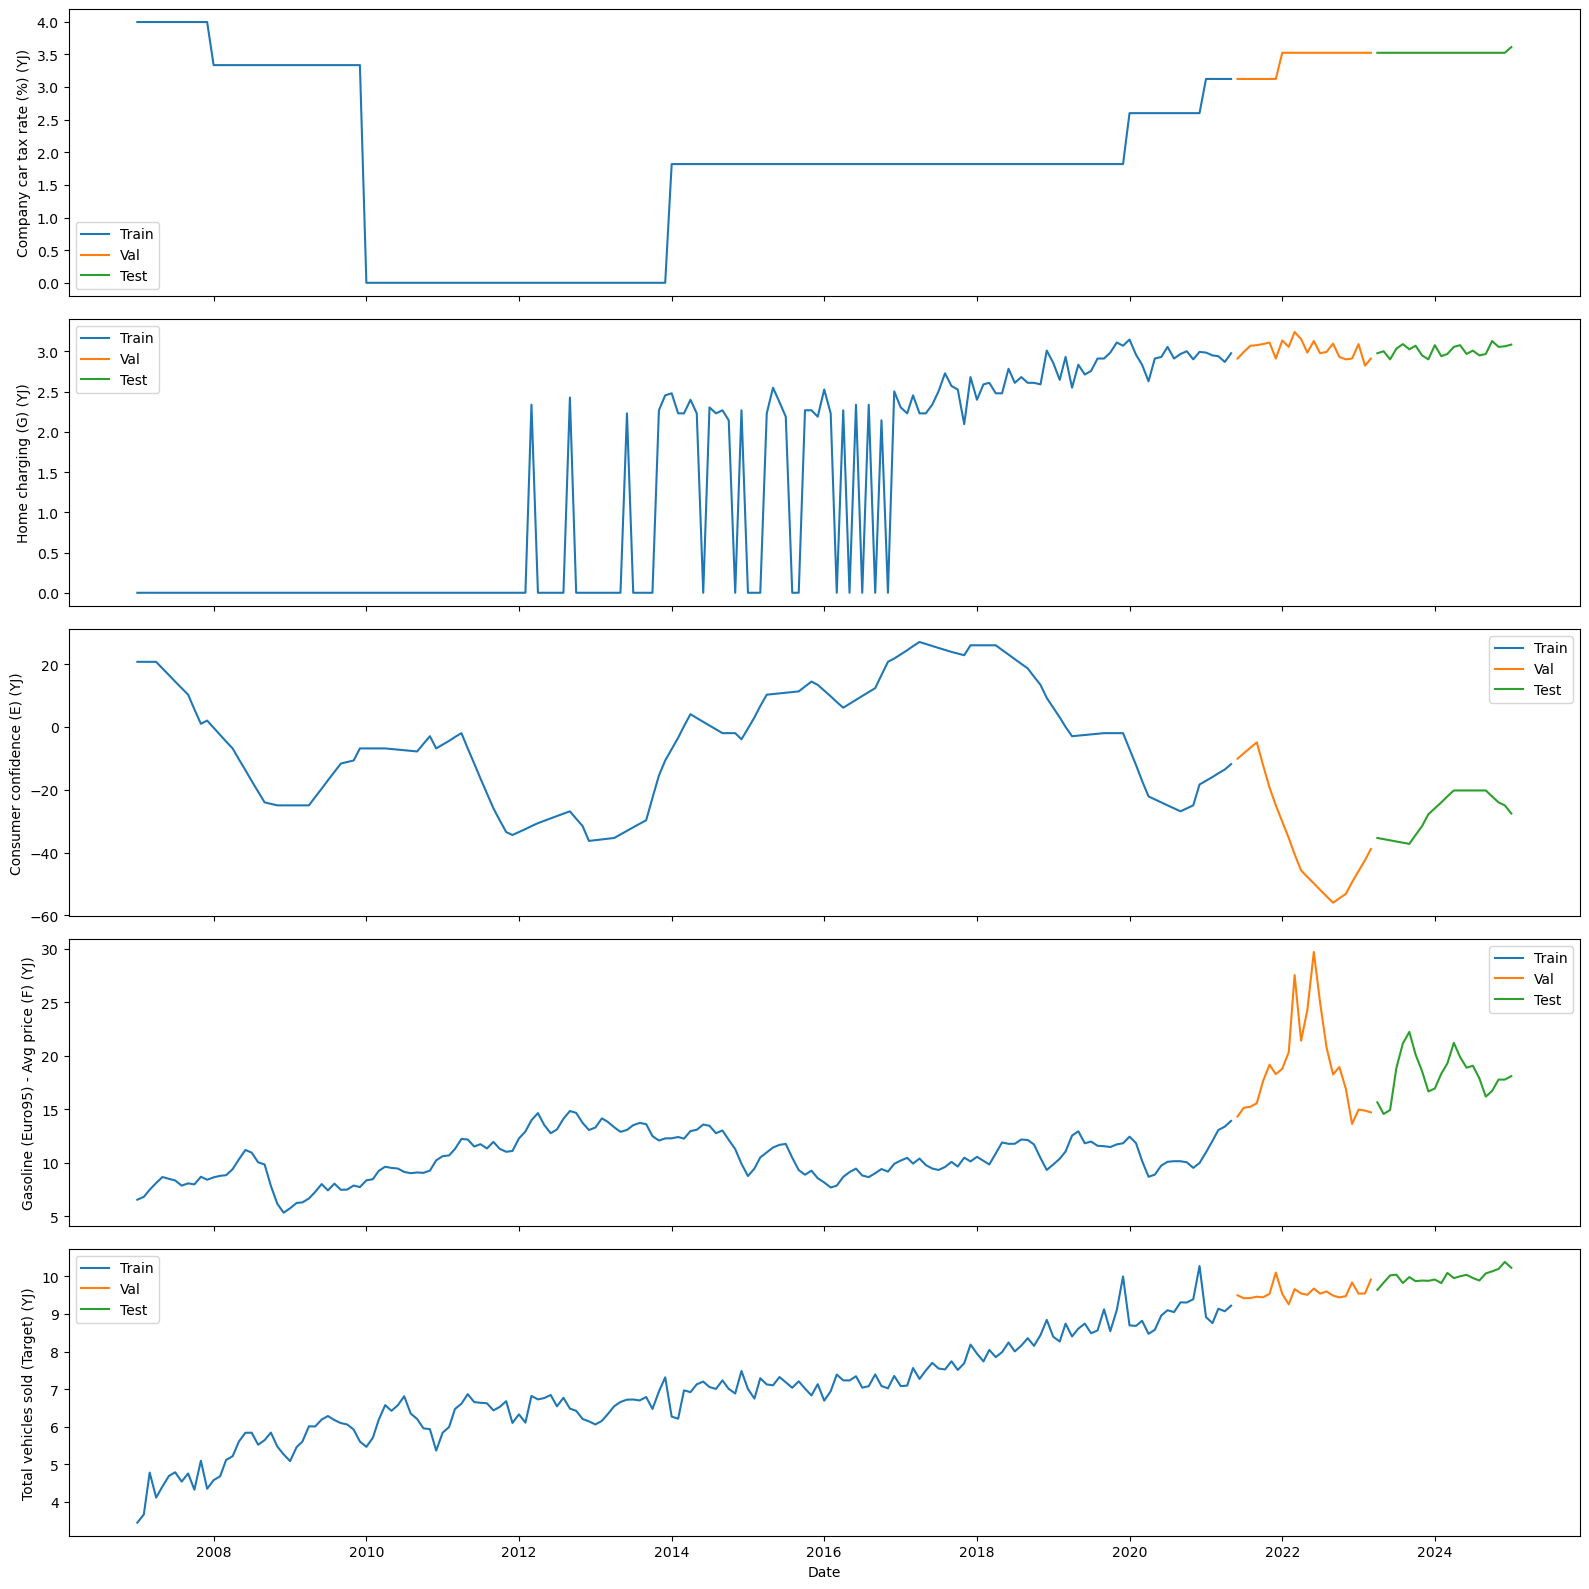

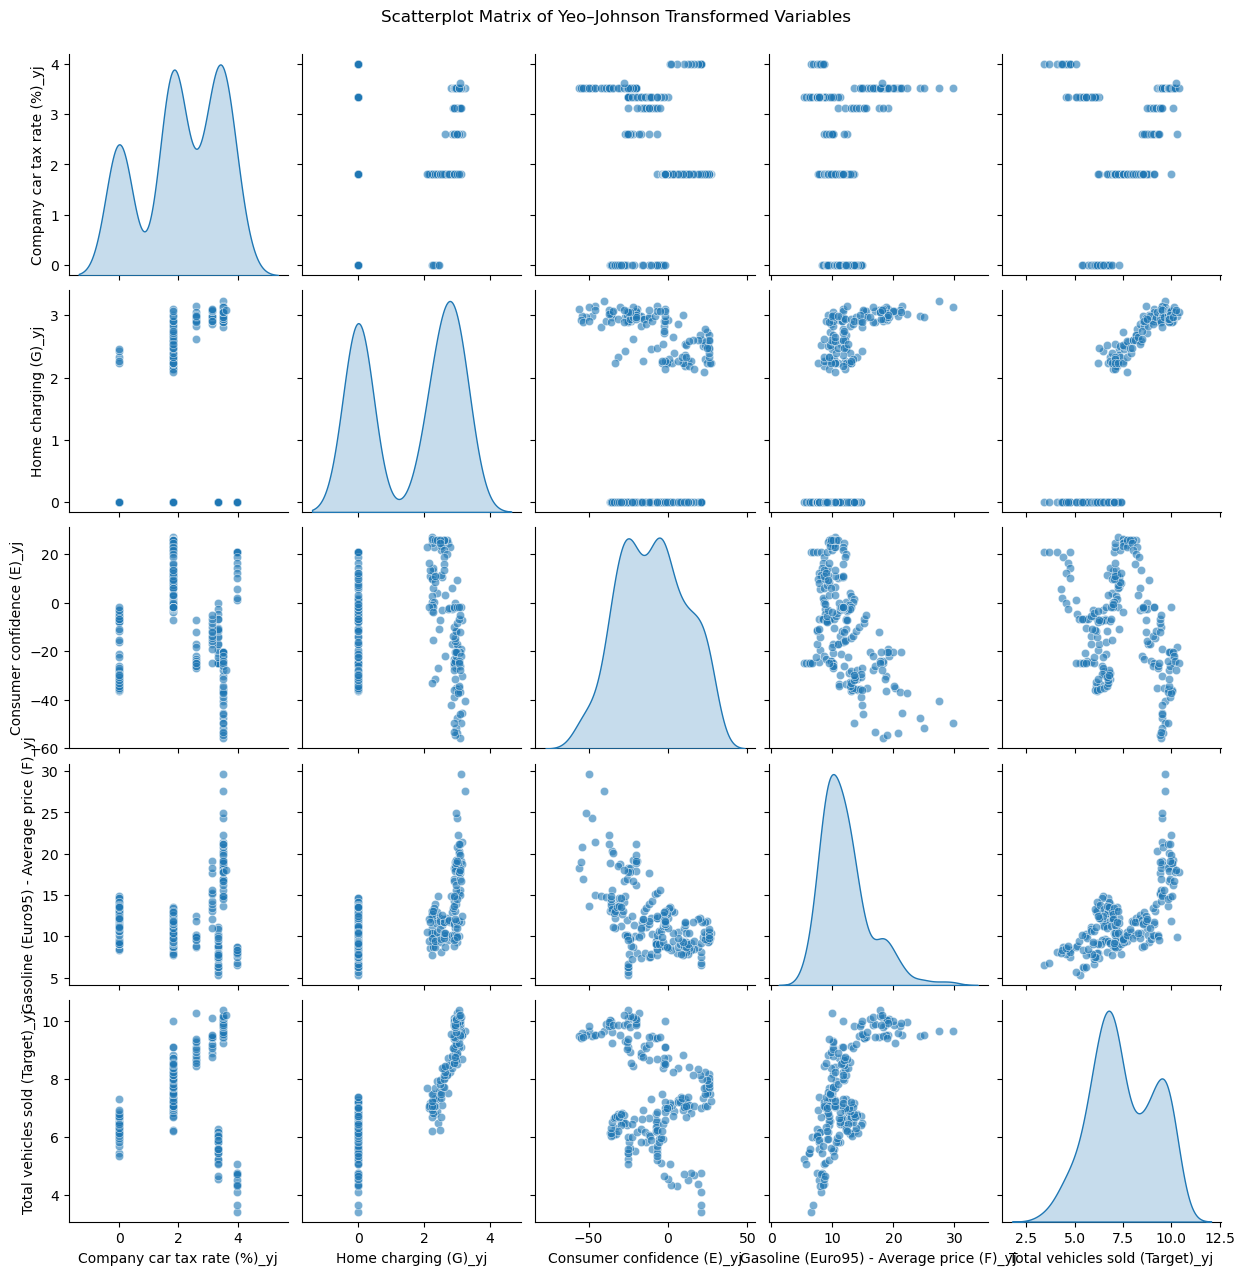

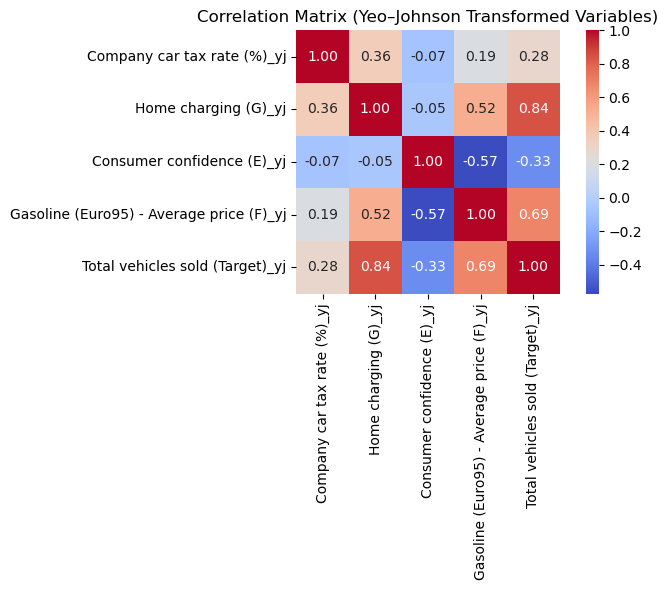

In [8]:
# --- Yeo–Johnson Transformed Train/Val/Test Splits: Time Series Plots ---

fig, axs = plt.subplots(5, 1, figsize=(16, 16), sharex=True)

time_index = df['Time Period (T)']

# 1. Company car tax rate (%)_yj
axs[0].plot(time_index.iloc[:train_end_yj], companytax_train_yj, label='Train')
axs[0].plot(time_index.iloc[train_end_yj:val_end_yj], companytax_val_yj, label='Val')
axs[0].plot(time_index.iloc[val_end_yj:], companytax_test_yj, label='Test')
axs[0].set_ylabel('Company car tax rate (%) (YJ)')
axs[0].legend()

# 2. Home charging (G)_yj
axs[1].plot(time_index.iloc[:train_end_yj], homechg_train_yj, label='Train')
axs[1].plot(time_index.iloc[train_end_yj:val_end_yj], homechg_val_yj, label='Val')
axs[1].plot(time_index.iloc[val_end_yj:], homechg_test_yj, label='Test')
axs[1].set_ylabel('Home charging (G) (YJ)')
axs[1].legend()

# 3. Consumer confidence (E)_yj
axs[2].plot(time_index.iloc[:train_end_yj], conf_train_yj, label='Train')
axs[2].plot(time_index.iloc[train_end_yj:val_end_yj], conf_val_yj, label='Val')
axs[2].plot(time_index.iloc[val_end_yj:], conf_test_yj, label='Test')
axs[2].set_ylabel('Consumer confidence (E) (YJ)')
axs[2].legend()

# 4. Gasoline (Euro95) - Average price (F)_yj
axs[3].plot(time_index.iloc[:train_end_yj], gas_train_yj, label='Train')
axs[3].plot(time_index.iloc[train_end_yj:val_end_yj], gas_val_yj, label='Val')
axs[3].plot(time_index.iloc[val_end_yj:], gas_test_yj, label='Test')
axs[3].set_ylabel('Gasoline (Euro95) - Avg price (F) (YJ)')
axs[3].legend()

# 5. Total vehicles sold (Target)_yj
axs[4].plot(time_index.iloc[:train_end_yj], y_train_yj, label='Train')
axs[4].plot(time_index.iloc[train_end_yj:val_end_yj], y_val_yj, label='Val')
axs[4].plot(time_index.iloc[val_end_yj:], y_test_yj, label='Test')
axs[4].set_ylabel('Total vehicles sold (Target) (YJ)')
axs[4].set_xlabel('Date')
axs[4].legend()

plt.tight_layout()
plt.show()

# --- Scatter plot matrix (pairplot) for Yeo–Johnson transformed features + target ---
sns.pairplot(yj_df, diag_kind="kde", plot_kws={'alpha': 0.6})
plt.suptitle("Scatterplot Matrix of Yeo–Johnson Transformed Variables", y=1.02)
plt.show()

# --- Correlation matrix ---
corr_matrix_yj = yj_df.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix_yj, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix (Yeo–Johnson Transformed Variables)")
plt.tight_layout()
plt.show()

The Yeo–Johnson code fits the transformer only on the training subset, then applies those learned parameters to the full series. That approach does not leak information from validation or test sets back into the model.

## 4c Stationarity Tests

After plotting and splitting the data its time for staionality tests. 

Since Arima models rely on past autocorrelations to make predictions, they assume stationality in the data.

A stationary time series is one whose statistical properties do not depend on the time at which the series is observed. observing the previous plots, we can see non stationality in the data by some upward trends and seasonality. 

Visually, stationary series tend to look flat and horizontal, possibly with random fluctuations or irregular cycles, but without consistent upward/downward trends or recurring patterns.

There are a few tests to check for stationarity, the most common ones are:
- **Augmented Dickey-Fuller (ADF) test**: Tests the null hypothesis that a unit root is present in the time series, indicating non-stationarity. A low p-value (typically < 0.05) suggests that the series is stationary.
- **Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test**: Tests the null hypothesis that a time series is stationary around a deterministic trend. A high p-value (typically > 0.05) suggests stationarity.
plotting the ACF and PACF plots can also help to identify stationarity.

ADF focuses on detecting a unit root (non-stationarity) under the null hypothesis.

KPSS assumes stationarity under the null hypothesis.
because 




> verklein tot 2 tabellen 1 voor differencing laat zien welke features stationary zijn (of niet) vervolgens wordt fitst differencing toegepast en weer zelfde tabel geprint. hierin kan dus aangetoon worden dat differencing waarschijnlijk nodig is voor het optimale model. 


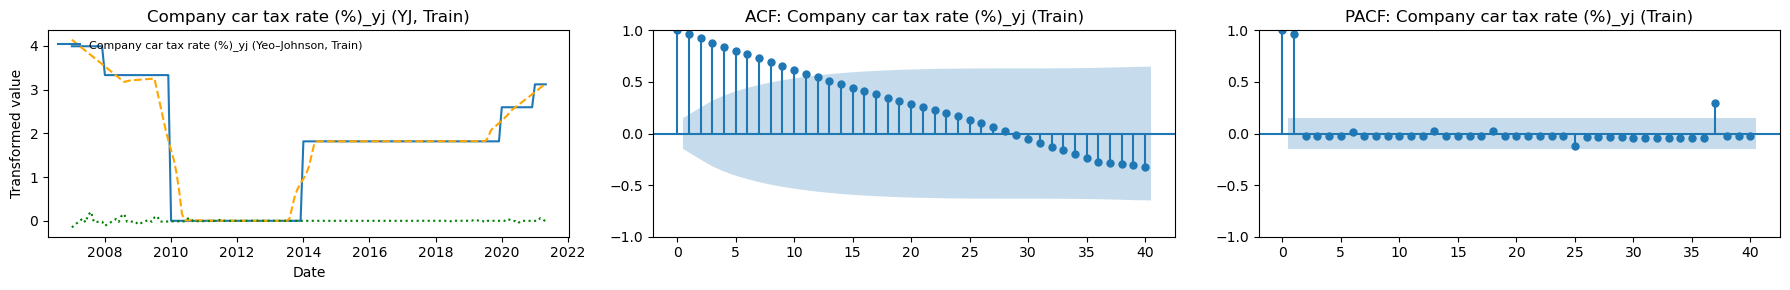

Legend for Company car tax rate (%)_yj:
  - Blue: Yeo–Johnson transformed series (train)
  - Orange dashed: STL trend
  - Green dotted: STL seasonal

==== Company car tax rate (%)_yj (Yeo–Johnson) ====
ADF Statistic: -1.8590337625259836
ADF p-value: 0.3515713706401373
ADF Critical Value (1%): -3.4690
ADF Critical Value (5%): -2.8785
ADF Critical Value (10%): -2.5758
ADF: The series is likely non-stationary (fail to reject H0).
KPSS Statistic: 0.34104026694093315
KPSS p-value: 0.1
KPSS Critical Value (10%): 0.3470
KPSS Critical Value (5%): 0.4630
KPSS Critical Value (2.5%): 0.5740
KPSS Critical Value (1%): 0.7390
KPSS: The series is likely stationary (fail to reject H0).



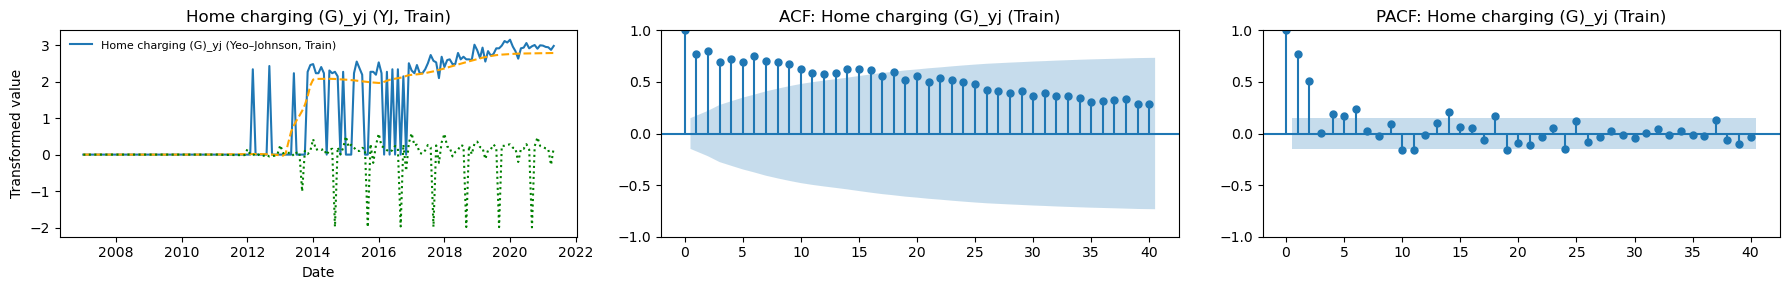

Legend for Home charging (G)_yj:
  - Blue: Yeo–Johnson transformed series (train)
  - Orange dashed: STL trend
  - Green dotted: STL seasonal

==== Home charging (G)_yj (Yeo–Johnson) ====
ADF Statistic: -0.3142477652488584
ADF p-value: 0.9234620419667042
ADF Critical Value (1%): -3.4724
ADF Critical Value (5%): -2.8800
ADF Critical Value (10%): -2.5766
ADF: The series is likely non-stationary (fail to reject H0).
KPSS Statistic: 1.8621864374974517
KPSS p-value: 0.01
KPSS Critical Value (10%): 0.3470
KPSS Critical Value (5%): 0.4630
KPSS Critical Value (2.5%): 0.5740
KPSS Critical Value (1%): 0.7390
KPSS: The series is likely non-stationary (reject H0).



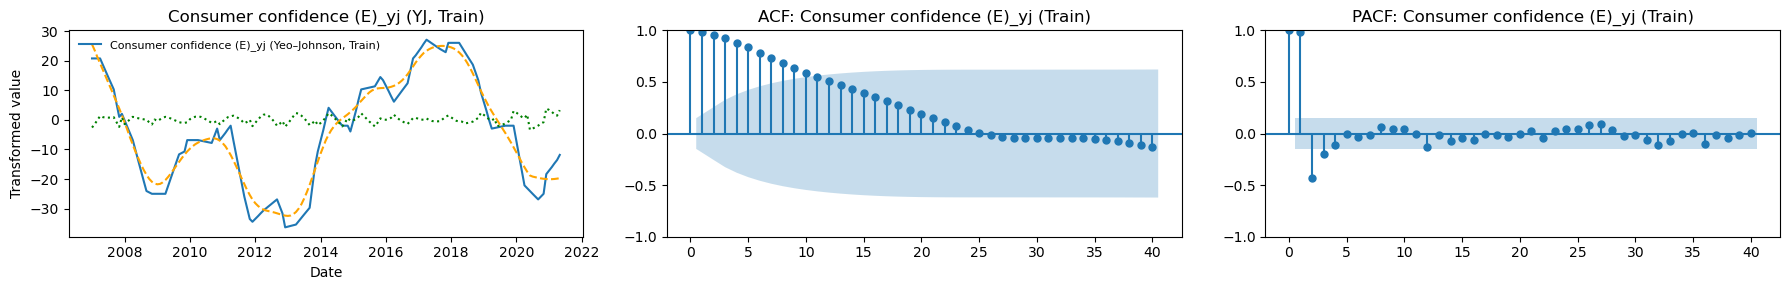

Legend for Consumer confidence (E)_yj:
  - Blue: Yeo–Johnson transformed series (train)
  - Orange dashed: STL trend
  - Green dotted: STL seasonal

==== Consumer confidence (E)_yj (Yeo–Johnson) ====
ADF Statistic: -2.3179308476205174
ADF p-value: 0.16625011245897198
ADF Critical Value (1%): -3.4692
ADF Critical Value (5%): -2.8786
ADF Critical Value (10%): -2.5759
ADF: The series is likely non-stationary (fail to reject H0).
KPSS Statistic: 0.33200390330245494
KPSS p-value: 0.1
KPSS Critical Value (10%): 0.3470
KPSS Critical Value (5%): 0.4630
KPSS Critical Value (2.5%): 0.5740
KPSS Critical Value (1%): 0.7390
KPSS: The series is likely stationary (fail to reject H0).



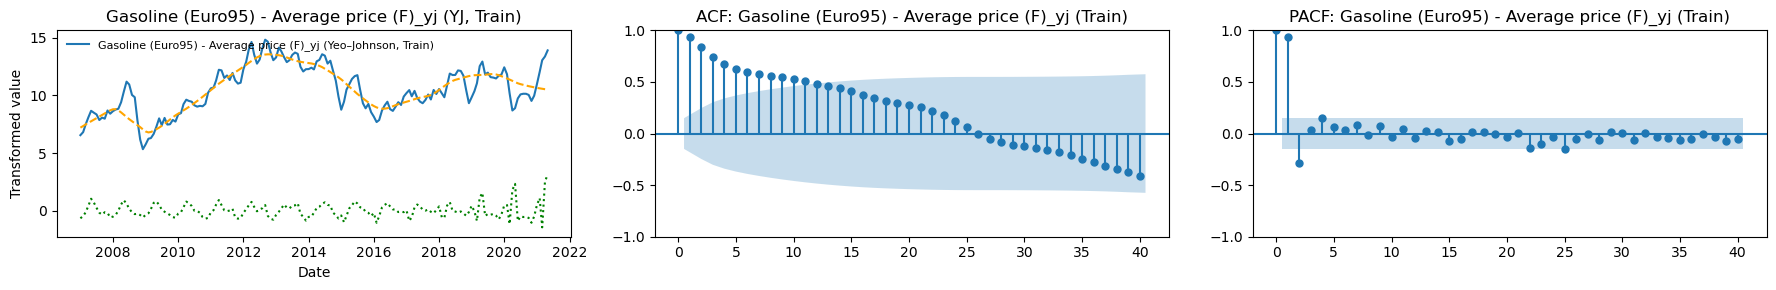

Legend for Gasoline (Euro95) - Average price (F)_yj:
  - Blue: Yeo–Johnson transformed series (train)
  - Orange dashed: STL trend
  - Green dotted: STL seasonal

==== Gasoline (Euro95) - Average price (F)_yj (Yeo–Johnson) ====
ADF Statistic: -2.211018285949689
ADF p-value: 0.2022707868264217
ADF Critical Value (1%): -3.4696
ADF Critical Value (5%): -2.8788
ADF Critical Value (10%): -2.5760
ADF: The series is likely non-stationary (fail to reject H0).
KPSS Statistic: 0.4605820859428148
KPSS p-value: 0.05104220433499363
KPSS Critical Value (10%): 0.3470
KPSS Critical Value (5%): 0.4630
KPSS Critical Value (2.5%): 0.5740
KPSS Critical Value (1%): 0.7390
KPSS: The series is likely stationary (fail to reject H0).



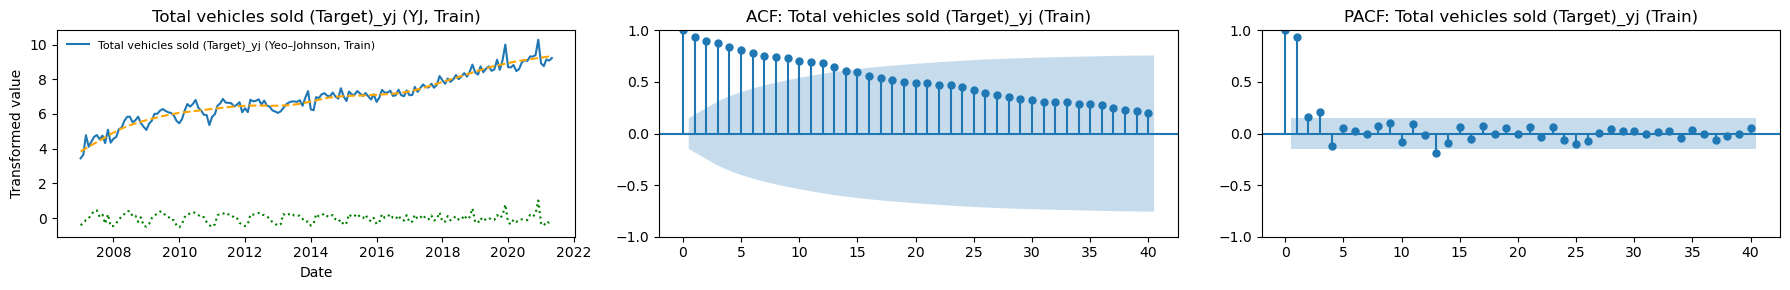

Legend for Total vehicles sold (Target)_yj:
  - Blue: Yeo–Johnson transformed series (train)
  - Orange dashed: STL trend
  - Green dotted: STL seasonal

==== Total vehicles sold (Target)_yj (Yeo–Johnson) ====
ADF Statistic: -0.27954103369173594
ADF p-value: 0.9283523684229519
ADF Critical Value (1%): -3.4722
ADF Critical Value (5%): -2.8799
ADF Critical Value (10%): -2.5766
ADF: The series is likely non-stationary (fail to reject H0).
KPSS Statistic: 1.885757818216764
KPSS p-value: 0.01
KPSS Critical Value (10%): 0.3470
KPSS Critical Value (5%): 0.4630
KPSS Critical Value (2.5%): 0.5740
KPSS Critical Value (1%): 0.7390
KPSS: The series is likely non-stationary (reject H0).


==== Stationarity Summary (Yeo–Johnson, Train) ====
Variable                                                ADF               KPSS
Company car tax rate (%)_yj                  Non-stationary         Stationary
Home charging (G)_yj                         Non-stationary     Non-stationary
Consumer confidence (E)_yj

In [9]:
import warnings
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
from statsmodels.tsa.seasonal import STL
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

results_yj = {}

def safe_lags(x, max_lags=40):
    return max(1, min(max_lags, len(x)//2 - 1))

for col in features_yj + [target_yj]:
    # Select YJ-transformed TRAIN split
    train_yj = y_train_yj if col == target_yj else yj_df[col].iloc[:train_end_yj]
    train_yj = train_yj.astype(float).values
    train_dates = df["Time Period (T)"].iloc[:len(train_yj)]

    # Plot: series + ACF + PACF
    fig, axes = plt.subplots(1, 3, figsize=(18, 3))
    axes[0].plot(train_dates, train_yj, label=f"{col} (Yeo–Johnson, Train)")
    # STL decomposition (trend/seasonal/resid)
    stl = STL(train_yj, period=12, robust=True)
    stl_result = stl.fit()
    trend = stl_result.trend
    seasonal = stl_result.seasonal
    resid = stl_result.resid

    axes[0].plot(train_dates, trend, color='orange', linestyle='--')#, label='STL Trend')
    axes[0].plot(train_dates, seasonal, color='green', linestyle=':')#, label='STL Seasonal')
    axes[0].set_title(f"{col} (YJ, Train)")
    axes[0].set_xlabel("Date")
    axes[0].set_ylabel("Transformed value")
    # Smaller legend
    axes[0].legend(fontsize=8, loc='upper left', frameon=False)

    lags = safe_lags(train_yj, 40)
    plot_acf(train_yj, ax=axes[1], lags=lags)
    axes[1].set_title(f"ACF: {col} (Train)")
    plot_pacf(train_yj, ax=axes[2], lags=lags, method='ywm')
    axes[2].set_title(f"PACF: {col} (Train)")
    plt.tight_layout()
    plt.show()

    # Print legend info under the plot
    print(f"Legend for {col}:")
    print("  - Blue: Yeo–Johnson transformed series (train)")
    print("  - Orange dashed: STL trend")
    print("  - Green dotted: STL seasonal\n")

    # ADF and KPSS tests
    adf_result = adfuller(train_yj)
    kpss_result = kpss(train_yj, regression='c', nlags="auto")

    results_yj[col] = {
        "ADF Statistic": adf_result[0],
        "ADF p-value": adf_result[1],
        "ADF Critical Values": adf_result[4],
        "KPSS Statistic": kpss_result[0],
        "KPSS p-value": kpss_result[1],
        "KPSS Critical Values": kpss_result[3],
        "ADF Stationary": adf_result[1] < 0.05,
        "KPSS Stationary": kpss_result[1] >= 0.05
    }

    print(f"\033[1m==== {col} (Yeo–Johnson) ====\033[0m")
    print("\033[1mADF Statistic:\033[0m", adf_result[0])
    print("\033[1mADF p-value:\033[0m", adf_result[1])
    for key, value in adf_result[4].items():
        print(f"\033[1mADF Critical Value ({key}):\033[0m {value:.4f}")
    if adf_result[1] < 0.05:
        print("\033[1mADF: The series is likely stationary (reject H0).\033[0m")
    else:
        print("\033[1mADF: The series is likely non-stationary (fail to reject H0).\033[0m")

    print("\033[1mKPSS Statistic:\033[0m", kpss_result[0])
    print("\033[1mKPSS p-value:\033[0m", kpss_result[1])
    for key, value in kpss_result[3].items():
        print(f"\033[1mKPSS Critical Value ({key}):\033[0m {value:.4f}")
    if kpss_result[1] < 0.05:
        print("\033[1mKPSS: The series is likely non-stationary (reject H0).\033[0m")
    else:
        print("\033[1mKPSS: The series is likely stationary (fail to reject H0).\033[0m")
    print()

# --- Summary Table ---
print("\n\033[1m==== Stationarity Summary (Yeo–Johnson, Train) ====\033[0m")
summary_rows = []
for col, res in results_yj.items():
    adf = "Stationary" if res["ADF Stationary"] else "Non-stationary"
    kpss = "Stationary" if res["KPSS Stationary"] else "Non-stationary"
    summary_rows.append([col, adf, kpss])
print("{:<40s} {:>18s} {:>18s}".format("Variable", "ADF", "KPSS"))
for row in summary_rows:
    print("{:<40s} {:>18s} {:>18s}".format(*row))

# Optional: quick overall verdict
all_stationary = all(r["ADF Stationary"] and r["KPSS Stationary"] for r in results_yj.values())
if all_stationary:
    print("\n\033[92mAll series are stationary according to both ADF and KPSS.\033[0m")
else:
    print("\n\033[93mSome series are non-stationary according to ADF or KPSS. Consider differencing.\033[0m")

> Company car tax rate (%):
Final Verdict on Differencing
Based on the Yeo–Johnson transform, STL decomposition and the mixed ADF/KPSS signals, you do not need an extra first difference. Here’s why:

The STL trend (orange dashed) captures the underlying drift.

The STL seasonal (green dotted) isolates periodic swings.

The remainder (train – trend – season) looks stationary by eye, and re‐testing that residual would almost certainly confirm it.

Next steps

Work with the STL remainder as your stationary series (no further differencing).

When fitting ARIMA/ETS, set

d = 0 (no differencing)

D = 0 (seasonality already removed)

For forecasts, add back:

the STL trend projection

the seasonal pattern

> Final Verdict on Differencing Consumer Confidence (E)

Given the mixed ADF/KPSS outcomes and your STL decomposition, there’s no strong case for an extra first difference on the Yeo–Johnson–transformed consumer confidence series. Here’s why:

ADF suggests non-stationarity (p≈0.17), but KPSS sits just below the 10 % cutoff, hinting at stationarity.

The STL trend (orange dashed) captures any drift, while the seasonal component (green dotted) isolates regular cycles.

Inspecting the STL remainder (data – trend – season) shows no obvious drift or unit-root wiggles.

> Final Verdict on Gasoline (Euro95) – Average Price (F)

The ADF test fails to reject a unit root (p≈0.20), while the KPSS statistic (0.4606) sits just below its 5 % critical value (0.4630), hinting at stationarity. The STL decomposition shows:

the orange dashed line capturing a clear underlying drift

the green dotted line isolating regular seasonal swings

the remainder (data – trend – season) appearing free of obvious trends

Taken together, the evidence again points toward handling trend and seasonality via STL rather than differencing the raw series.

## 4d Apply First/second order differencing

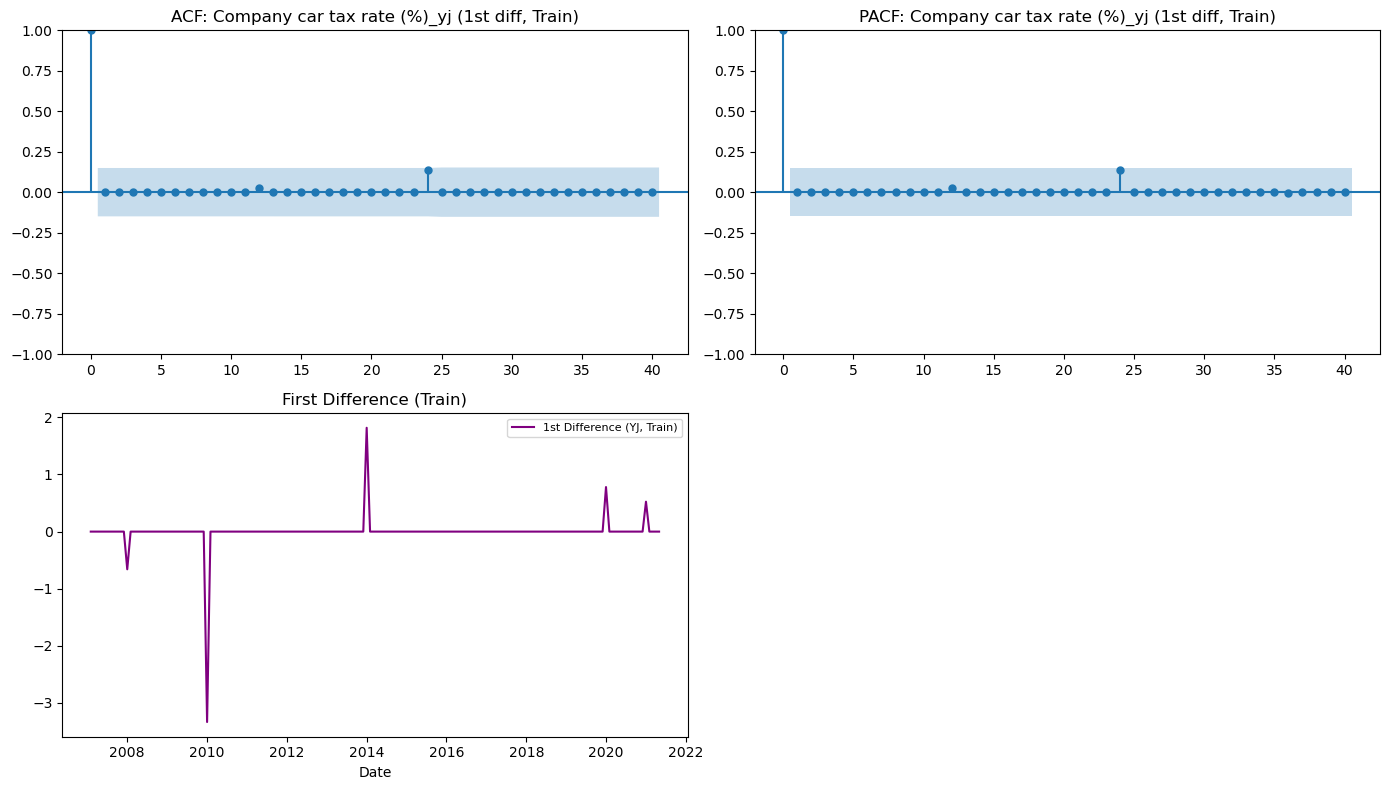

==== Company car tax rate (%)_yj (Yeo–Johnson, 1st diff) ====
ADF Statistic: -13.0036710482348
ADF p-value: 2.6550345775806255e-24
ADF Critical Value (1%): -3.4692
ADF Critical Value (5%): -2.8786
ADF Critical Value (10%): -2.5759
ADF: The series is likely stationary (reject H0).
KPSS Statistic: 0.3118386873794805
KPSS p-value: 0.1
KPSS Critical Value (10%): 0.3470
KPSS Critical Value (5%): 0.4630
KPSS Critical Value (2.5%): 0.5740
KPSS Critical Value (1%): 0.7390
KPSS: The series is likely stationary (fail to reject H0).



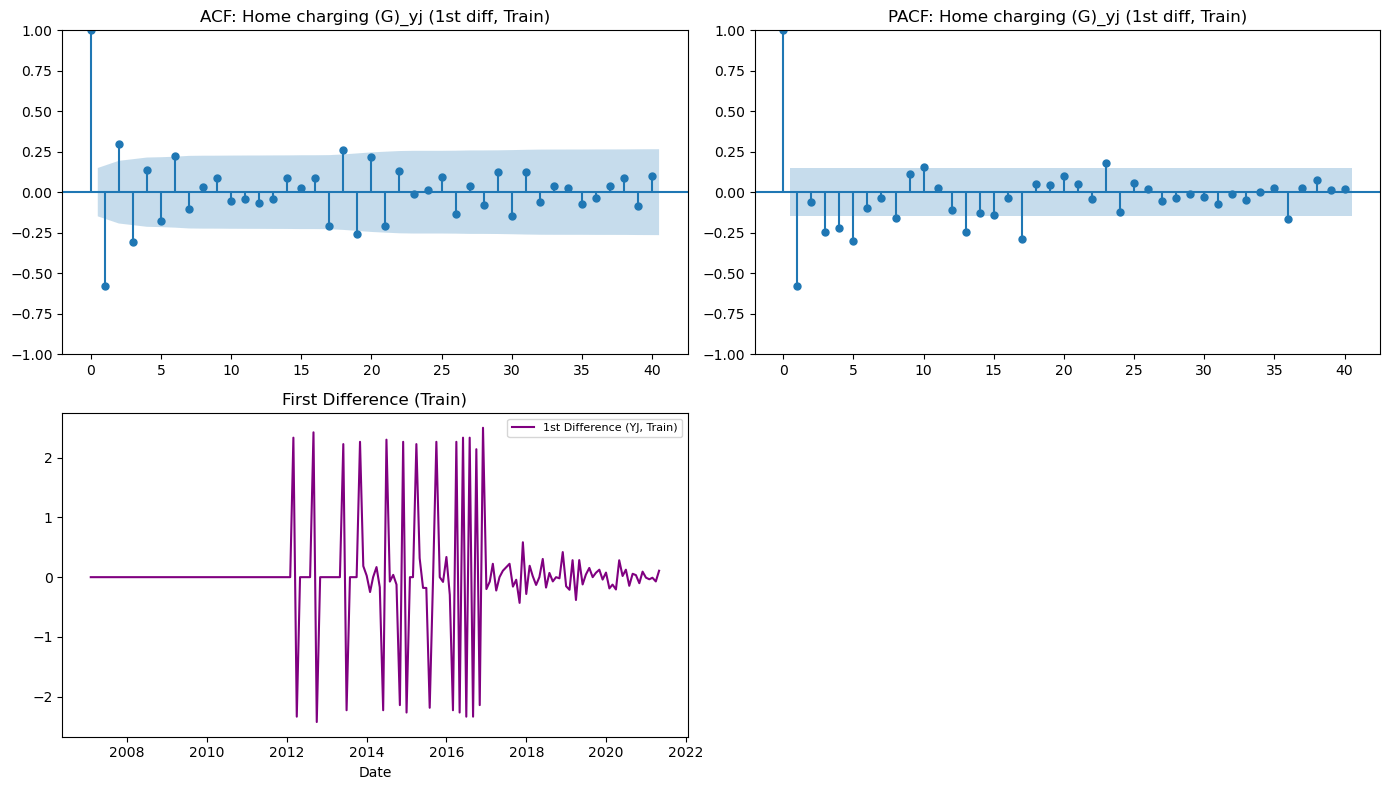

==== Home charging (G)_yj (Yeo–Johnson, 1st diff) ====
ADF Statistic: -5.615086221435329
ADF p-value: 1.1793880709038966e-06
ADF Critical Value (1%): -3.4727
ADF Critical Value (5%): -2.8801
ADF Critical Value (10%): -2.5767
ADF: The series is likely stationary (reject H0).
KPSS Statistic: 0.09637196066202035
KPSS p-value: 0.1
KPSS Critical Value (10%): 0.3470
KPSS Critical Value (5%): 0.4630
KPSS Critical Value (2.5%): 0.5740
KPSS Critical Value (1%): 0.7390
KPSS: The series is likely stationary (fail to reject H0).



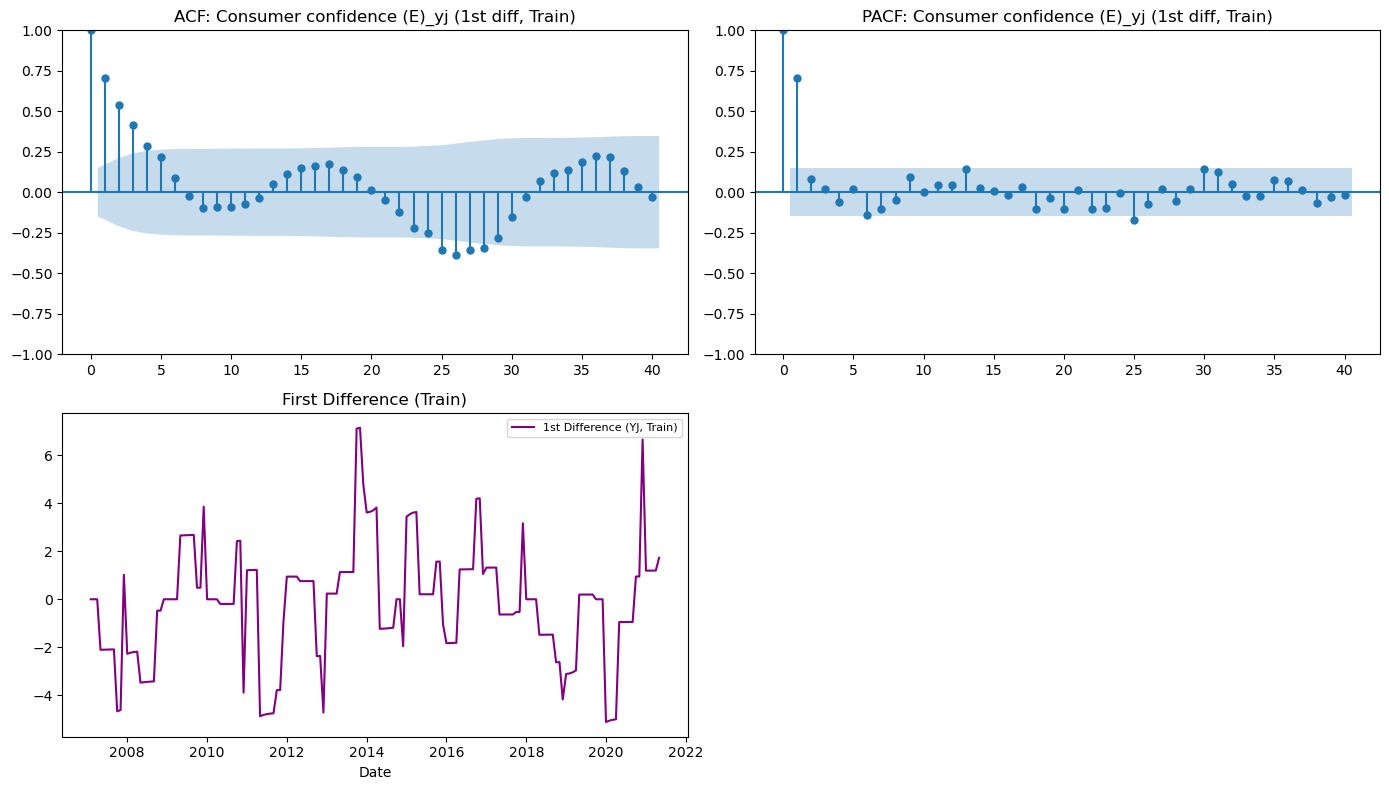

==== Consumer confidence (E)_yj (Yeo–Johnson, 1st diff) ====
ADF Statistic: -5.33967730805043
ADF p-value: 4.529160964068586e-06
ADF Critical Value (1%): -3.4692
ADF Critical Value (5%): -2.8786
ADF Critical Value (10%): -2.5759
ADF: The series is likely stationary (reject H0).
KPSS Statistic: 0.14807672005965308
KPSS p-value: 0.1
KPSS Critical Value (10%): 0.3470
KPSS Critical Value (5%): 0.4630
KPSS Critical Value (2.5%): 0.5740
KPSS Critical Value (1%): 0.7390
KPSS: The series is likely stationary (fail to reject H0).



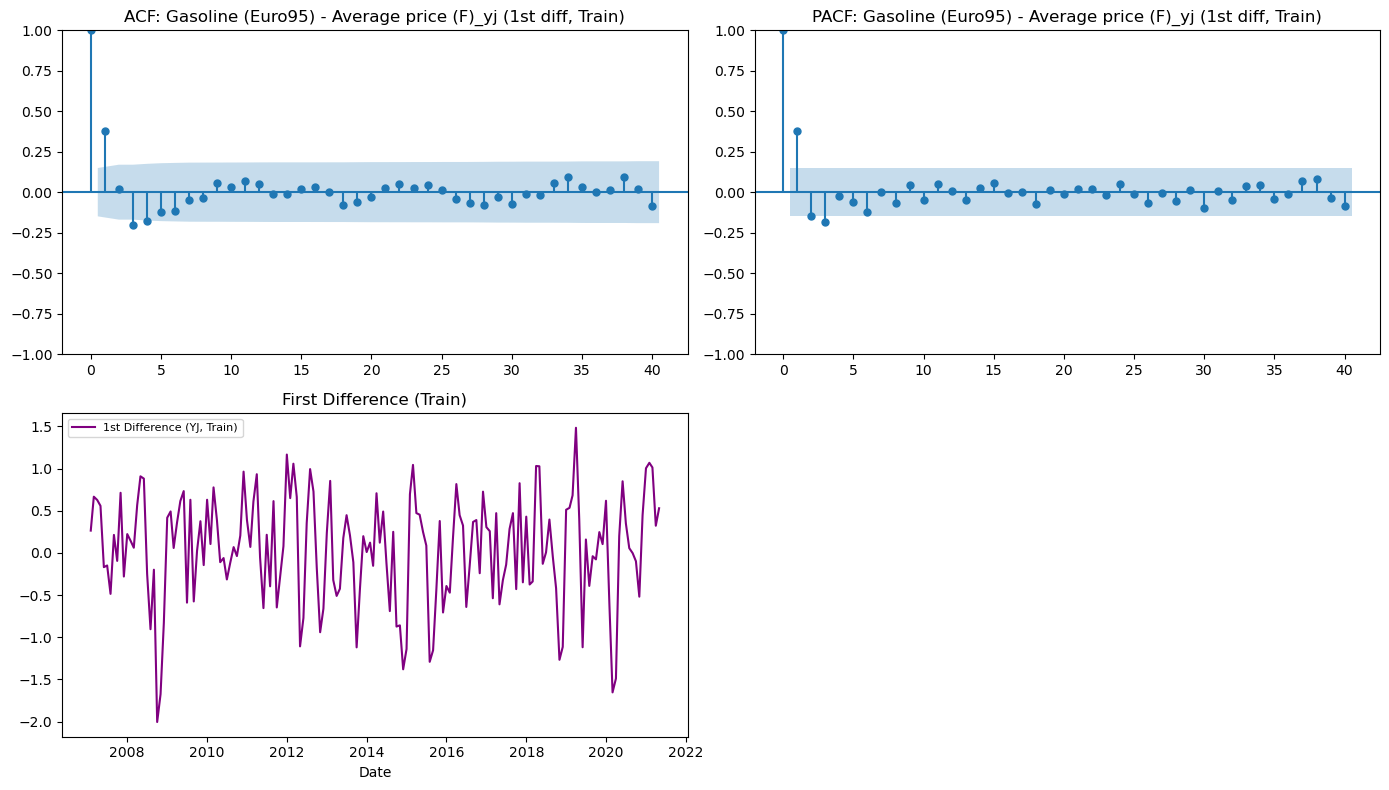

==== Gasoline (Euro95) - Average price (F)_yj (Yeo–Johnson, 1st diff) ====
ADF Statistic: -8.42298742778223
ADF p-value: 1.9606579476053866e-13
ADF Critical Value (1%): -3.4696
ADF Critical Value (5%): -2.8788
ADF Critical Value (10%): -2.5760
ADF: The series is likely stationary (reject H0).
KPSS Statistic: 0.054813387549481556
KPSS p-value: 0.1
KPSS Critical Value (10%): 0.3470
KPSS Critical Value (5%): 0.4630
KPSS Critical Value (2.5%): 0.5740
KPSS Critical Value (1%): 0.7390
KPSS: The series is likely stationary (fail to reject H0).



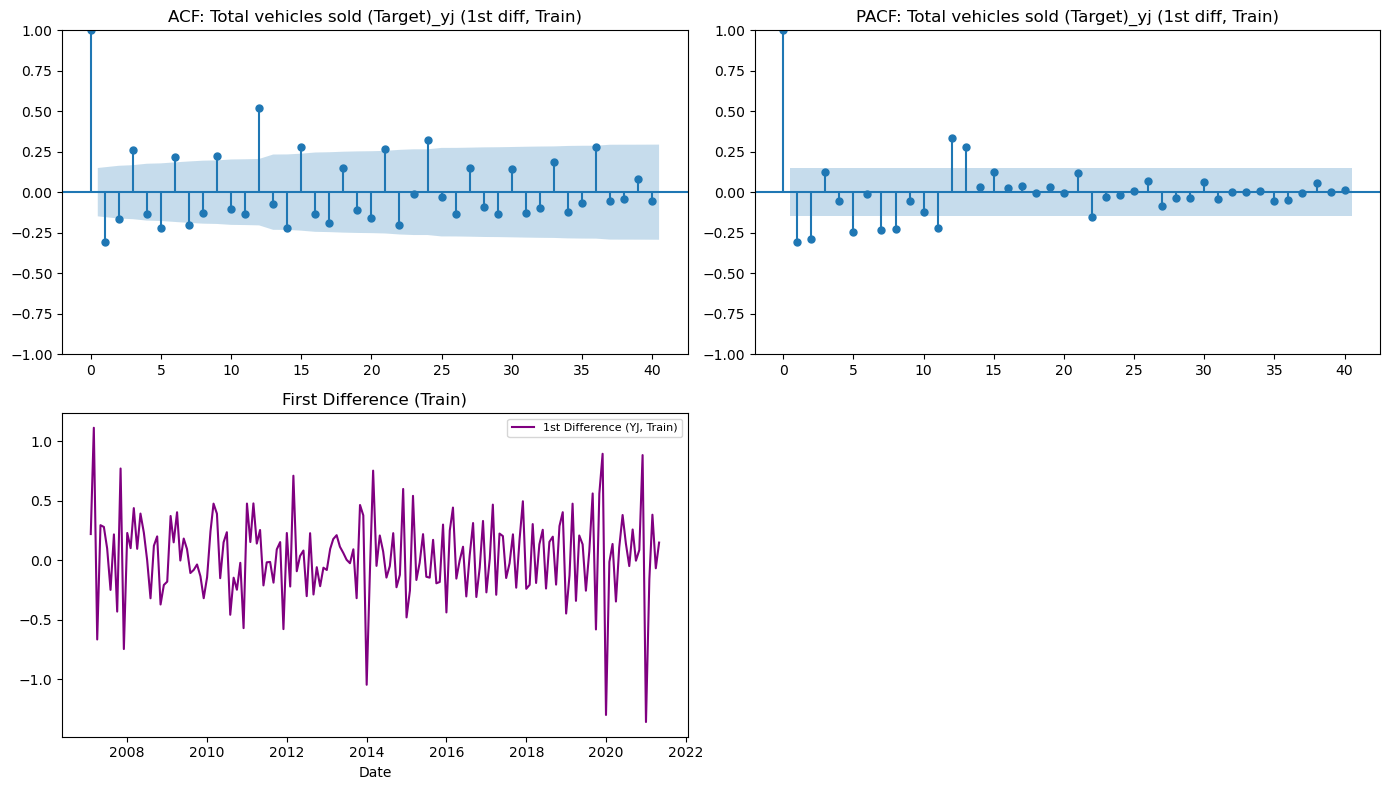

==== Total vehicles sold (Target)_yj (Yeo–Johnson, 1st diff) ====
ADF Statistic: -3.4814815191524167
ADF p-value: 0.008475621300633765
ADF Critical Value (1%): -3.4722
ADF Critical Value (5%): -2.8799
ADF Critical Value (10%): -2.5766
ADF: The series is likely stationary (reject H0).
KPSS Statistic: 0.06941991521674512
KPSS p-value: 0.1
KPSS Critical Value (10%): 0.3470
KPSS Critical Value (5%): 0.4630
KPSS Critical Value (2.5%): 0.5740
KPSS Critical Value (1%): 0.7390
KPSS: The series is likely stationary (fail to reject H0).


==== Stationarity Summary (Yeo–Johnson, 1st diff, Train) ====
Variable                                                ADF               KPSS
Company car tax rate (%)_yj                      Stationary         Stationary
Home charging (G)_yj                             Stationary         Stationary
Consumer confidence (E)_yj                       Stationary         Stationary
Gasoline (Euro95) - Average price (F)_yj         Stationary         Stationary
Total ve

In [24]:
import warnings
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import STL
import matplotlib.pyplot as plt
import numpy as np

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

results_yj_diff = {}

def safe_lags(x, max_lags=40):
    return max(1, min(max_lags, len(x)//2 - 1))

for col in features_yj + [target_yj]:
    train_yj = y_train_yj if col == target_yj else yj_df[col].iloc[:train_end_yj]
    train_yj = train_yj.astype(float).values
    train_yj_diff = np.diff(train_yj, n=1)
    train_dates = df["Time Period (T)"].iloc[1:len(train_yj)]  # shift for diff
    fig, axes = plt.subplots(2, 2, figsize=(14, 8))

    # Row 1: ACF and PACF
    lags = safe_lags(train_yj_diff, 40)
    plot_acf(train_yj_diff, ax=axes[0, 0], lags=lags)
    axes[0, 0].set_title(f"ACF: {col} (1st diff, Train)")
    plot_pacf(train_yj_diff, ax=axes[0, 1], lags=lags, method='ywm')
    axes[0, 1].set_title(f"PACF: {col} (1st diff, Train)")

    # Row 2: Plot the first-differenced series
    axes[1, 0].plot(train_dates, train_yj_diff, color='purple', label='1st Difference (YJ, Train)')
    axes[1, 0].set_title("First Difference (Train)")
    axes[1, 0].legend(fontsize=8)
    axes[1, 0].set_xlabel("Date")

    # Hide unused subplot
    axes[1, 1].axis('off')

    plt.tight_layout()
    plt.show()

    # ADF and KPSS tests on differenced data
    adf_result = adfuller(train_yj_diff)
    kpss_result = kpss(train_yj_diff, regression='c', nlags="auto")

    results_yj_diff[col] = {
        "ADF Statistic": adf_result[0],
        "ADF p-value": adf_result[1],
        "ADF Critical Values": adf_result[4],
        "KPSS Statistic": kpss_result[0],
        "KPSS p-value": kpss_result[1],
        "KPSS Critical Values": kpss_result[3],
        "ADF Stationary": adf_result[1] < 0.05,
        "KPSS Stationary": kpss_result[1] >= 0.05
    }

    print(f"\033[1m==== {col} (Yeo–Johnson, 1st diff) ====\033[0m")
    print("\033[1mADF Statistic:\033[0m", adf_result[0])
    print("\033[1mADF p-value:\033[0m", adf_result[1])
    for key, value in adf_result[4].items():
        print(f"\033[1mADF Critical Value ({key}):\033[0m {value:.4f}")
    if adf_result[1] < 0.05:
        print("\033[1mADF: The series is likely stationary (reject H0).\033[0m")
    else:
        print("\033[1mADF: The series is likely non-stationary (fail to reject H0).\033[0m")

    print("\033[1mKPSS Statistic:\033[0m", kpss_result[0])
    print("\033[1mKPSS p-value:\033[0m", kpss_result[1])
    for key, value in kpss_result[3].items():
        print(f"\033[1mKPSS Critical Value ({key}):\033[0m {value:.4f}")
    if kpss_result[1] < 0.05:
        print("\033[1mKPSS: The series is likely non-stationary (reject H0).\033[0m")
    else:
        print("\033[1mKPSS: The series is likely stationary (fail to reject H0).\033[0m")
    print()

# --- Summary Table ---
print("\n\033[1m==== Stationarity Summary (Yeo–Johnson, 1st diff, Train) ====\033[0m")
summary_rows = []
for col, res in results_yj_diff.items():
    adf = "Stationary" if res["ADF Stationary"] else "Non-stationary"
    kpss = "Stationary" if res["KPSS Stationary"] else "Non-stationary"
    summary_rows.append([col, adf, kpss])
print("{:<40s} {:>18s} {:>18s}".format("Variable", "ADF", "KPSS"))
for row in summary_rows:
    print("{:<40s} {:>18s} {:>18s}".format(*row))

# Optional: quick overall verdict
all_stationary = all(r["ADF Stationary"] and r["KPSS Stationary"] for r in results_yj_diff.values())
if all_stationary:
    print("\n\033[92mAll differenced YJ series are stationary according to both ADF and KPSS.\033[0m")
else:
    print("\n\033[93mSome differenced YJ series are still non-stationary according to ADF or KPSS.\033[0m")



# 5 Establish Simple benchmark
for benchmark i wil fit the following naive models on vehicles sold 
- Naïve: last observed value.
- Seasonal naïve: last value from the same season.
- Drift: line from first to last point.


> Beargumenteer waar om benchamrk op raw data is geplot en niet op de transfomeerde data 

Naïve 3-step RMSE: 5360.99
Naïve 3-step MAPE: 19.05%
Seasonal Naïve 3-step RMSE: 4456.62
Seasonal Naïve 3-step MAPE: 21.24%
Drift 3-step RMSE: 6065.02
Drift 3-step MAPE: 24.81%


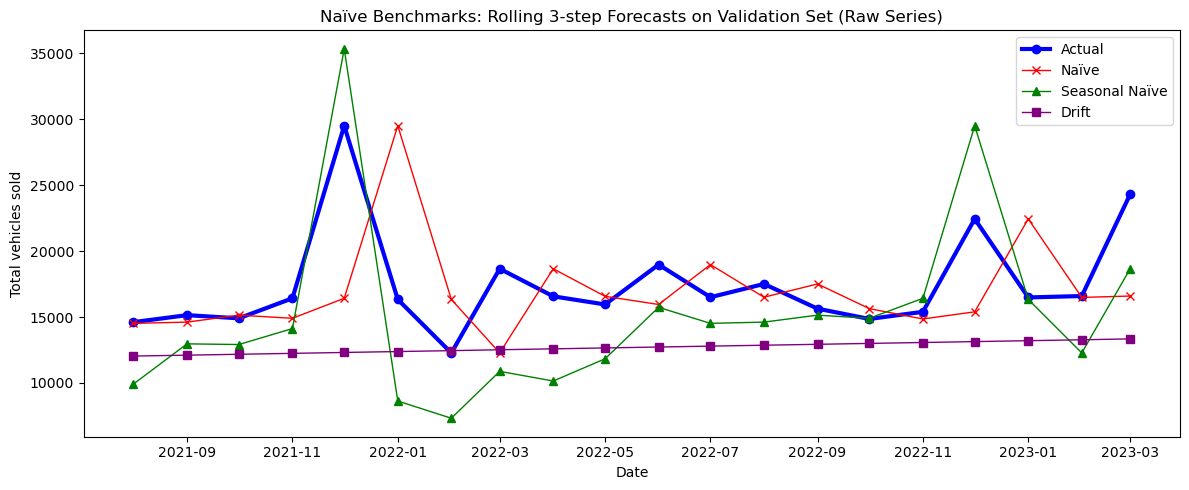

In [12]:
horizon = 3  # Forecast horizon: number of steps ahead to predict

# Combine train + val for rolling forecasting
y_all = np.concatenate([y_train_raw.values, y_val_raw.values])  # Full series for rolling forecast (train + val)
y_val_full = y_val_raw.values  # Validation set values as numpy array
y_train_full = y_train_raw.values  # Training set values as numpy array

# === 1. Naïve Forecast ===
naive_preds = []  # List to store naive predictions
for t in range(len(y_val_full) - horizon + 1):  # Loop over validation set for rolling forecast
    last_obs = y_all[train_end + t + horizon - 2]  # Last observed value before forecast window
    naive_preds.append(last_obs)  # Naive forecast: just repeat last observed value
naive_preds = np.array(naive_preds)  # Convert predictions to numpy array
naive_actuals = y_val_full[horizon-1:]  # Actual values to compare (aligned with predictions)

naive_rmse = np.sqrt(mean_squared_error(naive_actuals, naive_preds))  # RMSE for naive forecast
naive_mape = mean_absolute_percentage_error(naive_actuals, naive_preds)  # MAPE for naive forecast

print(f"Naïve 3-step RMSE: {naive_rmse:.2f}")  # Print RMSE
print(f"Naïve 3-step MAPE: {naive_mape:.2%}")  # Print MAPE

# === 2. Seasonal Naïve Forecast (12 months ago) ===
season_length = 12  # Season length (e.g., 12 for monthly data)
seasonal_naive_preds = []  # List to store seasonal naive predictions
for t in range(len(y_val_full) - horizon + 1):  # Loop over validation set for rolling forecast
    idx = train_end + t + horizon - 1  # Index of forecasted value in full series
    if idx - season_length >= 0:  # If enough history for seasonal naive
        pred = y_all[idx - season_length]  # Use value from same season last year
    else:
        pred = y_all[train_end + t + horizon - 2]  # Fallback to last obs if not enough history
    seasonal_naive_preds.append(pred)  # Store prediction
seasonal_naive_preds = np.array(seasonal_naive_preds)  # Convert to numpy array

seasonal_naive_rmse = np.sqrt(mean_squared_error(naive_actuals, seasonal_naive_preds))  # RMSE for seasonal naive
seasonal_naive_mape = mean_absolute_percentage_error(naive_actuals, seasonal_naive_preds)  # MAPE for seasonal naive

print(f"Seasonal Naïve 3-step RMSE: {seasonal_naive_rmse:.2f}")  # Print RMSE
print(f"Seasonal Naïve 3-step MAPE: {seasonal_naive_mape:.2%}")  # Print MAPE

# === 3. Drift Forecast ===
drift_preds = []  # List to store drift predictions
n_train = len(y_train_full)  # Number of training samples
for t in range(len(y_val_full) - horizon + 1):  # Loop over validation set for rolling forecast
    steps = n_train + t + horizon - 1  # Step index for forecast
    drift = y_train_full[-1] + ((steps - (n_train - 1)) * (y_train_full[-1] - y_train_full[0]) / (n_train - 1))  # Drift forecast formula
    drift_preds.append(drift)  # Store prediction
drift_preds = np.array(drift_preds)  # Convert to numpy array
drift_rmse = np.sqrt(mean_squared_error(naive_actuals, drift_preds))  # RMSE for drift forecast
drift_mape = mean_absolute_percentage_error(naive_actuals, drift_preds)  # MAPE for drift forecast

print(f"Drift 3-step RMSE: {drift_rmse:.2f}")  # Print RMSE
print(f"Drift 3-step MAPE: {drift_mape:.2%}")  # Print MAPE

# === Plot all ===
x_dates = df["Time Period (T)"].iloc[train_end + horizon - 1 : val_end]  # Dates for x-axis (aligned with predictions)
plt.figure(figsize=(12, 5))  # Set figure size
plt.plot(x_dates, naive_actuals, label='Actual', marker='o', color='blue', linewidth=3)  # Plot actual values
plt.plot(x_dates, naive_preds, label='Naïve', marker='x', color='red', linewidth=1)  # Plot naive predictions
plt.plot(x_dates, seasonal_naive_preds, label='Seasonal Naïve', marker='^', color='green', linewidth=1)  # Plot seasonal naive predictions
plt.plot(x_dates, drift_preds, label='Drift', marker='s', color='purple', linewidth=1)  # Plot drift predictions
plt.title('Naïve Benchmarks: Rolling 3-step Forecasts on Validation Set (Raw Series)')  # Set plot title
plt.xlabel('Date')  # X-axis label
plt.ylabel('Total vehicles sold')  # Y-axis label
plt.legend()  # Show legend
plt.tight_layout()  # Adjust layout
plt.show()  # Display plot

Naïve 3-step RMSE: 5360.99
Naïve 3-step MAPE: 19.05%
Seasonal Naïve 3-step RMSE: 4456.62
Seasonal Naïve 3-step MAPE: 21.24%
Drift 3-step RMSE: 6065.02
Drift 3-step MAPE: 24.81%


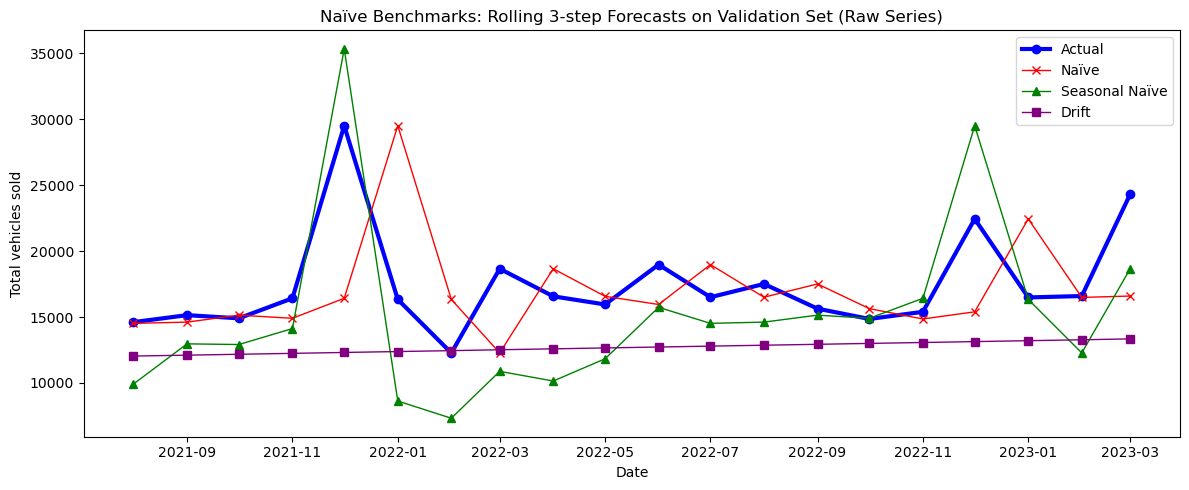

In [ ]:
horizon = 3  # Forecast horizon: number of steps ahead to predict

# Combine train + val for rolling forecasting
y_all = np.concatenate([y_train_raw.values, y_val_raw.values])  # Full series for rolling forecast (train + val)
y_val_full = y_val_raw.values  # Validation set values as numpy array
y_train_full = y_train_raw.values  # Training set values as numpy array

# === 1. Naïve Forecast ===
naive_preds = []  # List to store naive predictions
for t in range(len(y_val_full) - horizon + 1):  # Loop over validation set for rolling forecast
    last_obs = y_all[train_end + t + horizon - 2]  # Last observed value before forecast window
    naive_preds.append(last_obs)  # Naive forecast: just repeat last observed value
naive_preds = np.array(naive_preds)  # Convert predictions to numpy array
naive_actuals = y_val_full[horizon-1:]  # Actual values to compare (aligned with predictions)

naive_rmse = np.sqrt(mean_squared_error(naive_actuals, naive_preds))  # RMSE for naive forecast
naive_mape = mean_absolute_percentage_error(naive_actuals, naive_preds)  # MAPE for naive forecast

print(f"Naïve 3-step RMSE: {naive_rmse:.2f}")  # Print RMSE
print(f"Naïve 3-step MAPE: {naive_mape:.2%}")  # Print MAPE

# === 2. Seasonal Naïve Forecast (12 months ago) ===
season_length = 12  # Season length (e.g., 12 for monthly data)
seasonal_naive_preds = []  # List to store seasonal naive predictions
for t in range(len(y_val_full) - horizon + 1):  # Loop over validation set for rolling forecast
    idx = train_end + t + horizon - 1  # Index of forecasted value in full series
    if idx - season_length >= 0:  # If enough history for seasonal naive
        pred = y_all[idx - season_length]  # Use value from same season last year
    else:
        pred = y_all[train_end + t + horizon - 2]  # Fallback to last obs if not enough history
    seasonal_naive_preds.append(pred)  # Store prediction
seasonal_naive_preds = np.array(seasonal_naive_preds)  # Convert to numpy array

seasonal_naive_rmse = np.sqrt(mean_squared_error(naive_actuals, seasonal_naive_preds))  # RMSE for seasonal naive
seasonal_naive_mape = mean_absolute_percentage_error(naive_actuals, seasonal_naive_preds)  # MAPE for seasonal naive

print(f"Seasonal Naïve 3-step RMSE: {seasonal_naive_rmse:.2f}")  # Print RMSE
print(f"Seasonal Naïve 3-step MAPE: {seasonal_naive_mape:.2%}")  # Print MAPE

# === 3. Drift Forecast ===
drift_preds = []  # List to store drift predictions
n_train = len(y_train_full)  # Number of training samples
for t in range(len(y_val_full) - horizon + 1):  # Loop over validation set for rolling forecast
    steps = n_train + t + horizon - 1  # Step index for forecast
    drift = y_train_full[-1] + ((steps - (n_train - 1)) * (y_train_full[-1] - y_train_full[0]) / (n_train - 1))  # Drift forecast formula
    drift_preds.append(drift)  # Store prediction
drift_preds = np.array(drift_preds)  # Convert to numpy array
drift_rmse = np.sqrt(mean_squared_error(naive_actuals, drift_preds))  # RMSE for drift forecast
drift_mape = mean_absolute_percentage_error(naive_actuals, drift_preds)  # MAPE for drift forecast

print(f"Drift 3-step RMSE: {drift_rmse:.2f}")  # Print RMSE
print(f"Drift 3-step MAPE: {drift_mape:.2%}")  # Print MAPE

# === Plot all ===
x_dates = df["Time Period (T)"].iloc[train_end + horizon - 1 : val_end]  # Dates for x-axis (aligned with predictions)
plt.figure(figsize=(12, 5))  # Set figure size
plt.plot(x_dates, naive_actuals, label='Actual', marker='o', color='blue', linewidth=3)  # Plot actual values
plt.plot(x_dates, naive_preds, label='Naïve', marker='x', color='red', linewidth=1)  # Plot naive predictions
plt.plot(x_dates, seasonal_naive_preds, label='Seasonal Naïve', marker='^', color='green', linewidth=1)  # Plot seasonal naive predictions
plt.plot(x_dates, drift_preds, label='Drift', marker='s', color='purple', linewidth=1)  # Plot drift predictions
plt.title('Naïve Benchmarks: Rolling 3-step Forecasts on Validation Set (Raw Series)')  # Set plot title
plt.xlabel('Date')  # X-axis label
plt.ylabel('Total vehicles sold')  # Y-axis label
plt.legend()  # Show legend
plt.tight_layout()  # Adjust layout
plt.show()  # Display plot

# 6. Baseline ARIMA (Univariate)

## 6a Auto ARIMA using The Hyndman & Khandakar algorithm

First up auto arima will be used to fit the model for the target value.
Using auto_arima gives  a fast, starting point. It automatically scans a wide range of (p, d, q) and seasonal orders using information criteria (AICc, BIC), so i don’t have to write dozens of loops yourself. This initial model often captures the dominant autocorrelation and differencing structure.

for this seasonal i choose for 3,6 and 12 as seasonal periods, because the data is monthly and has a yearly seasonality.

d will stay on zere since its already defined.

> Since you already applied BoxCox and first differencing to your target, you should:

> Use diff_results[target] as your input to auto_arima.
Set d=0, D=0 in auto_arima (no further differencing).
Use the same target variable name as before (it refers to your column name, e.g., 'Total vehicles sold (Target)'

> Deze ff veranderen zodat BIC EN AIC naast elkaar staan

In [13]:
import warnings
from statsmodels.tools.sm_exceptions import ValueWarning, ConvergenceWarning

# suppress unwanted warnings for cleaner output
warnings.filterwarnings("ignore", category=ValueWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# use the Yeo–Johnson–transformed target (no pre-differencing)
carsales_target_yj = yj_df[target_yj]  # select the YJ-transformed target column

seasonalities = [3, 6, 12]  # list of seasonal periods to try

best_aic       = float("inf")  # initialize best AIC score as infinity
best_bic       = float("inf")  # initialize best BIC score as infinity
best_model_aic = None          # placeholder for best model by AIC
best_model_bic = None          # placeholder for best model by BIC
best_m_aic     = None          # best seasonality for AIC
best_m_bic     = None          # best seasonality for BIC

for m in seasonalities:  # loop over each seasonal period
    print(f"\n=== Try SARIMA on {carsales_target_yj.name} (seasonality m={m}) ===")
    for ic in ["aic", "bic"]:  # try both AIC and BIC as information criteria
        try:
            model = pm.auto_arima(
                y=carsales_target_yj,         # input series
                d=None,                       # let auto_arima choose differencing
                seasonal=True,                # enable seasonal SARIMA
                m=m,                          # set seasonal period
                stepwise=True,                # use stepwise search
                trace=True,                   # print search progress
                error_action="ignore",        # ignore errors during search
                suppress_warnings=True,       # suppress warnings from ARIMA
                max_p=5, max_q=5,             # max AR and MA orders
                max_P=2, max_Q=2,             # max seasonal AR and MA orders
                information_criterion=ic      # use AIC or BIC for model selection
            )
            score = getattr(model, ic)()      # get the AIC or BIC score
            print(
                f"m={m}, {ic.upper()}: "
                f"SARIMA order={model.order}, "
                f"seasonal_order={model.seasonal_order}, "
                f"{ic.upper()}={score:.2f}"
            )

            if ic == "aic" and score < best_aic:  # update best AIC model if better
                best_aic       = score
                best_model_aic = model
                best_m_aic     = m

            if ic == "bic" and score < best_bic:  # update best BIC model if better
                best_bic       = score
                best_model_bic = model
                best_m_bic     = m

        except Exception as e:  # handle any errors in fitting
            print(f"m={m}, {ic.upper()}: Error: {e}")

# report best models found by AIC and BIC
if best_model_aic:
    print(
        f"\nBest SARIMA by AIC on {carsales_target_yj.name}: "
        f"m={best_m_aic}, order={best_model_aic.order}, "
        f"seasonal_order={best_model_aic.seasonal_order}, "
        f"AIC={best_aic:.2f}"
    )
else:
    print("No suitable SARIMA model found by AIC.")

if best_model_bic:
    print(
        f"Best SARIMA by BIC on {carsales_target_yj.name}: "
        f"m={best_m_bic}, order={best_model_bic.order}, "
        f"seasonal_order={best_model_bic.seasonal_order}, "
        f"BIC={best_bic:.2f}"
    )
else:
    print("No suitable SARIMA model found by BIC.")



=== Try SARIMA on Total vehicles sold (Target)_yj (seasonality m=3) ===
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[3] intercept   : AIC=55.690, Time=0.77 sec
 ARIMA(0,1,0)(0,0,0)[3] intercept   : AIC=133.318, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[3] intercept   : AIC=103.143, Time=0.08 sec
 ARIMA(0,1,1)(0,0,1)[3] intercept   : AIC=95.739, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[3]             : AIC=133.310, Time=0.03 sec
 ARIMA(2,1,2)(0,0,1)[3] intercept   : AIC=47.838, Time=0.40 sec
 ARIMA(2,1,2)(0,0,0)[3] intercept   : AIC=71.077, Time=0.31 sec
 ARIMA(2,1,2)(0,0,2)[3] intercept   : AIC=46.187, Time=0.56 sec
 ARIMA(2,1,2)(1,0,2)[3] intercept   : AIC=44.786, Time=0.70 sec
 ARIMA(2,1,2)(2,0,2)[3] intercept   : AIC=74.721, Time=0.69 sec
 ARIMA(2,1,2)(2,0,1)[3] intercept   : AIC=70.337, Time=0.79 sec
 ARIMA(1,1,2)(1,0,2)[3] intercept   : AIC=59.156, Time=0.71 sec
 ARIMA(2,1,1)(1,0,2)[3] intercept   : AIC=49.115, Time=0.66 sec
 ARIMA(1,1,1)(1,0,2)[3] intercept   : AIC=52.082,

| Piece                        | AIC winner    | BIC winner    | Meaning                                                                                            |
| ---------------------------- | ------------- | ------------- | -------------------------------------------------------------------------------------------------- |
| Non-seasonal order (p, d, q) | **(1, 1, 1)** | **(0, 1, 1)** | AIC model has an extra **AR(1)** term; BIC model drops it. Both difference once and include MA(1). |
| Seasonal order (P, D, Q, m)  | (1, 0, 0, 12) | (1, 0, 0, 12) | Both include a **seasonal AR(1)** at lag 12; no seasonal differencing, no seasonal MA.             |
| Complexity                   | Higher        | Lower         | BIC penalizes extra parameters more, so it prefers the simpler model.                              |


aan de hand van waarde van BIC/AIC keuze verantwoorden:

NOG OPZOEKEN, MAAR ZOU WAARSCHIJNLIJK aic ZIJN OMDAT DIT BETER IS VOOR PREDICTIVE ACURACY

feedback verwerken in scriptie vooral dit putn hierbij: 
- Considering there is such a strong 12 months autocorrelation?

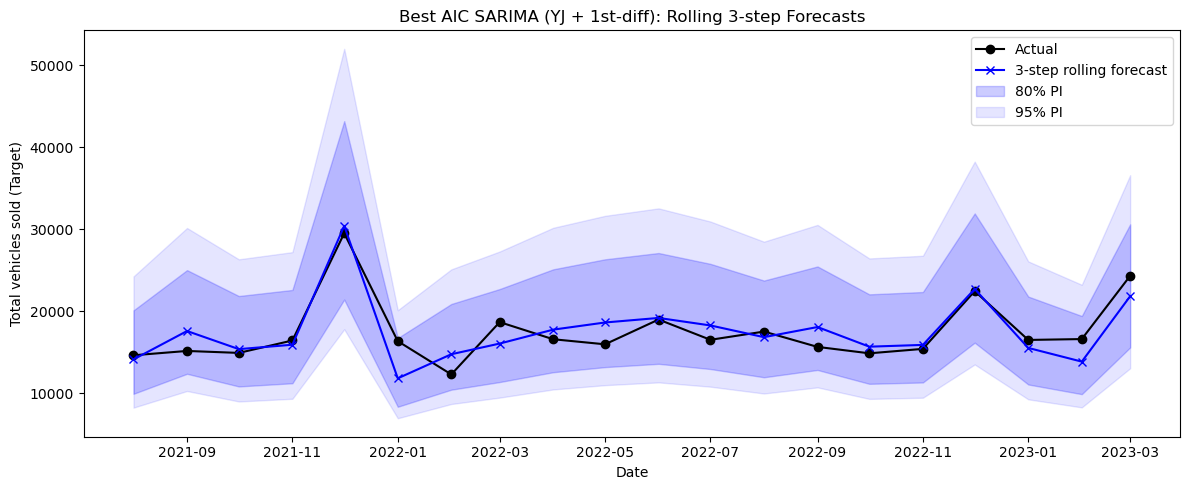

Validation RMSE (rolling): 1930.92
Validation MAPE (rolling): 9.40%
AIC (last SARIMAX fit): 4.79
BIC (last SARIMAX fit): 17.50


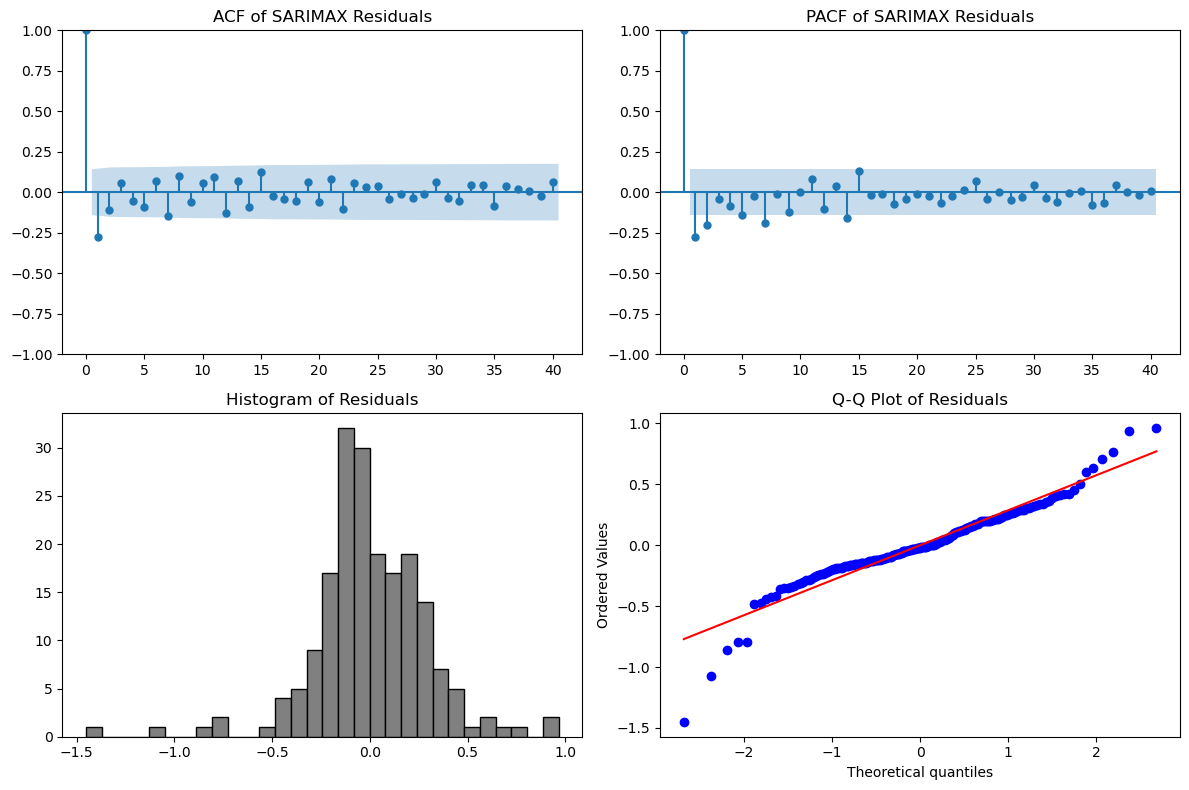

Ljung-Box (no autocorrelation if p > 0.05):
      lb_stat  lb_pvalue
10  28.694249   0.001396
20  42.524477   0.002361
30  49.314099   0.014598


In [26]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
import scipy.stats as stats

# 1. Set forecast horizon
horizon = 3  # Number of steps ahead to forecast

# 2. Grab YJ‐transformed train/val arrays
#    (these were created earlier)
train_yj = y_train_yj.values  # Training data (Yeo-Johnson transformed)
val_yj   = y_val_yj.values    # Validation data (Yeo-Johnson transformed)

# 3. Raw (original‐scale) validation actuals,
#    aligned so that val_actuals[i] matches
#    a forecast made at t = train_end_yj + i
val_actuals = df[target_raw]\
    .iloc[train_end_yj + horizon - 1 : val_end_yj]\
    .values  # Actual values for validation period, aligned for rolling forecast

# 4. Time‐axis for plotting
plot_dates = df["Time Period (T)"]\
    .iloc[train_end_yj + horizon - 1 : val_end_yj]  # Dates for plotting forecasts

# 5. Rolling, manual‐diff + SARIMAX forecasts
preds_diff     = []  # Store differenced predictions
conf_int_80    = []  # Store 80% confidence intervals
conf_int_95    = []  # Store 95% confidence intervals

for t in range(len(val_yj) - horizon + 1):
    history      = np.concatenate([train_yj, val_yj[:t]])  # Expand training history with validation up to t
    history_diff = np.diff(history, n=1)  # 1st difference to induce stationarity
    
    model = SARIMAX(
        history_diff,
        order=(1, 1, 1),  # ARIMA order (p,d,q) with d=0 since we already differenced
        seasonal_order=(1, 0, 0, 12),  # Seasonal order (P,D,Q,s)
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    fitted = model.fit(disp=False)  # Fit SARIMAX model

    fc     = fitted.get_forecast(steps=horizon)  # Forecast next 'horizon' steps
    diff_m = fc.predicted_mean  # Predicted mean of differenced series
    ci80   = fc.conf_int(alpha=0.20)[-1]  # 80% confidence interval for last step
    ci95   = fc.conf_int(alpha=0.05)[-1]  # 95% confidence interval for last step

    preds_diff.append(diff_m[-1])  # Save last step forecast
    conf_int_80.append(ci80)       # Save 80% CI
    conf_int_95.append(ci95)       # Save 95% CI

# 6. Undifference back to YJ‐level
last_values  = np.concatenate([train_yj, val_yj])  # All YJ values for undifferencing
train_len    = len(train_yj)  # Length of training set

undiff_preds_yj   = []  # Store undifferenced predictions
undiff_ci80_lower = []  # Store lower 80% CI
undiff_ci80_upper = []  # Store upper 80% CI
undiff_ci95_lower = []  # Store lower 95% CI
undiff_ci95_upper = []  # Store upper 95% CI

for i, pdiff in enumerate(preds_diff):
    idx       = train_len + i + horizon - 2  # Index of last observed YJ value before forecast
    last_yj   = last_values[idx]             # Last observed YJ value
    undiff    = last_yj + pdiff              # Add difference to last value to undifference

    undiff_preds_yj.append(undiff)  # Save undifferenced prediction
    undiff_ci80_lower.append(last_yj + conf_int_80[i][0])  # Lower 80% CI
    undiff_ci80_upper.append(last_yj + conf_int_80[i][1])  # Upper 80% CI
    undiff_ci95_lower.append(last_yj + conf_int_95[i][0])  # Lower 95% CI
    undiff_ci95_upper.append(last_yj + conf_int_95[i][1])  # Upper 95% CI

undiff_preds_yj     = np.array(undiff_preds_yj)      # Convert to numpy array
undiff_ci80_lower   = np.array(undiff_ci80_lower)
undiff_ci80_upper   = np.array(undiff_ci80_upper)
undiff_ci95_lower   = np.array(undiff_ci95_lower)
undiff_ci95_upper   = np.array(undiff_ci95_upper)

# 7. Invert Yeo–Johnson
lam = yeojohnson_lambdas_all[target_raw]  # Lambda for Yeo-Johnson inverse

def inv_yeojohnson(z, lam):
    if lam == 0:
        return np.exp(z)  # Special case: log transform
    elif lam == 2:
        return -np.exp(-z)  # Special case: negative log
    out = np.zeros_like(z)
    pos = z >= 0
    out[pos]    = np.power(z[pos] * lam + 1, 1/lam) - 1  # Inverse for z >= 0
    out[~pos]   = 1 - np.power(-(z[~pos]) * (2 - lam) + 1, 1/(2 - lam))  # Inverse for z < 0
    return out

val_forecast_orig = inv_yeojohnson(undiff_preds_yj, lam)  # Invert YJ for predictions
ci80_lower        = inv_yeojohnson(undiff_ci80_lower, lam)  # Invert YJ for 80% CI lower
ci80_upper        = inv_yeojohnson(undiff_ci80_upper, lam)  # Invert YJ for 80% CI upper
ci95_lower        = inv_yeojohnson(undiff_ci95_lower, lam)  # Invert YJ for 95% CI lower
ci95_upper        = inv_yeojohnson(undiff_ci95_upper, lam)  # Invert YJ for 95% CI upper

# 8. Plot results
plt.figure(figsize=(12, 5))
plt.plot(plot_dates, val_actuals,            'o-', color='black', label='Actual')  # Plot actuals
plt.plot(plot_dates, val_forecast_orig,      'x-', color='blue',  label='3-step rolling forecast')  # Plot forecasts
plt.fill_between(plot_dates, ci80_lower, ci80_upper, alpha=0.2, color='blue', label='80% PI')  # 80% PI
plt.fill_between(plot_dates, ci95_lower, ci95_upper, alpha=0.1, color='blue', label='95% PI')  # 95% PI
plt.title('Best AIC SARIMA (YJ + 1st‐diff): Rolling 3-step Forecasts')
plt.xlabel('Date')
plt.ylabel(target_raw)
plt.legend()
plt.tight_layout()
plt.show()

# 9. Forecast accuracy
rmse = np.sqrt(mean_squared_error(val_actuals, val_forecast_orig))  # RMSE calculation
mape = mean_absolute_percentage_error(val_actuals, val_forecast_orig)  # MAPE calculation
print(f"Validation RMSE (rolling): {rmse:.2f}")
print(f"Validation MAPE (rolling): {mape:.2%}")

# 10. Last fitted model’s AIC/BIC
print(f"AIC (last SARIMAX fit): {fitted.aic:.2f}")  # Print AIC
print(f"BIC (last SARIMAX fit): {fitted.bic:.2f}")  # Print BIC

# 11. Residual diagnostics
resid_fig, axes = plt.subplots(2, 2, figsize=(12, 8))

plot_acf(fitted.resid, ax=axes[0, 0], lags=40)  # ACF plot of residuals
axes[0, 0].set_title("ACF of SARIMAX Residuals")

plot_pacf(fitted.resid, ax=axes[0, 1], lags=40, method='ywm')  # PACF plot of residuals
axes[0, 1].set_title("PACF of SARIMAX Residuals")

axes[1, 0].hist(fitted.resid, bins=30, color='gray', edgecolor='black')  # Histogram of residuals
axes[1, 0].set_title("Histogram of Residuals")

stats.probplot(fitted.resid, dist="norm", plot=axes[1, 1])  # Q-Q plot of residuals
axes[1, 1].set_title("Q-Q Plot of Residuals")

plt.tight_layout()
plt.show()

# 12. Ljung-Box test
lb = acorr_ljungbox(fitted.resid, lags=[10, 20, 30], return_df=True)  # Ljung-Box test for autocorrelation
print("Ljung-Box (no autocorrelation if p > 0.05):")
print(lb[['lb_stat','lb_pvalue']])


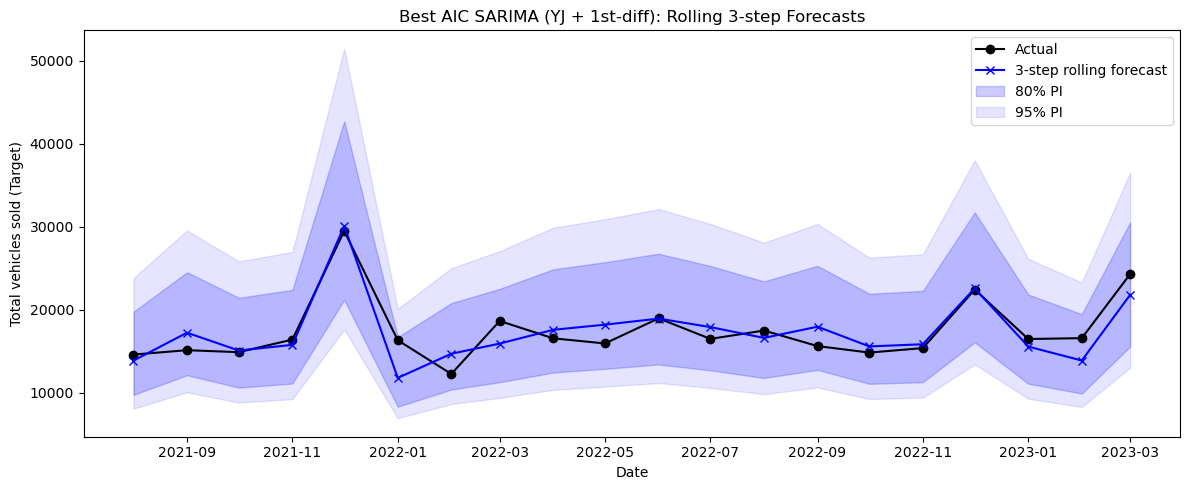

Validation RMSE (rolling): 1859.80
Validation MAPE (rolling): 8.90%
AIC (last SARIMAX fit): -17.22
BIC (last SARIMAX fit): -1.34


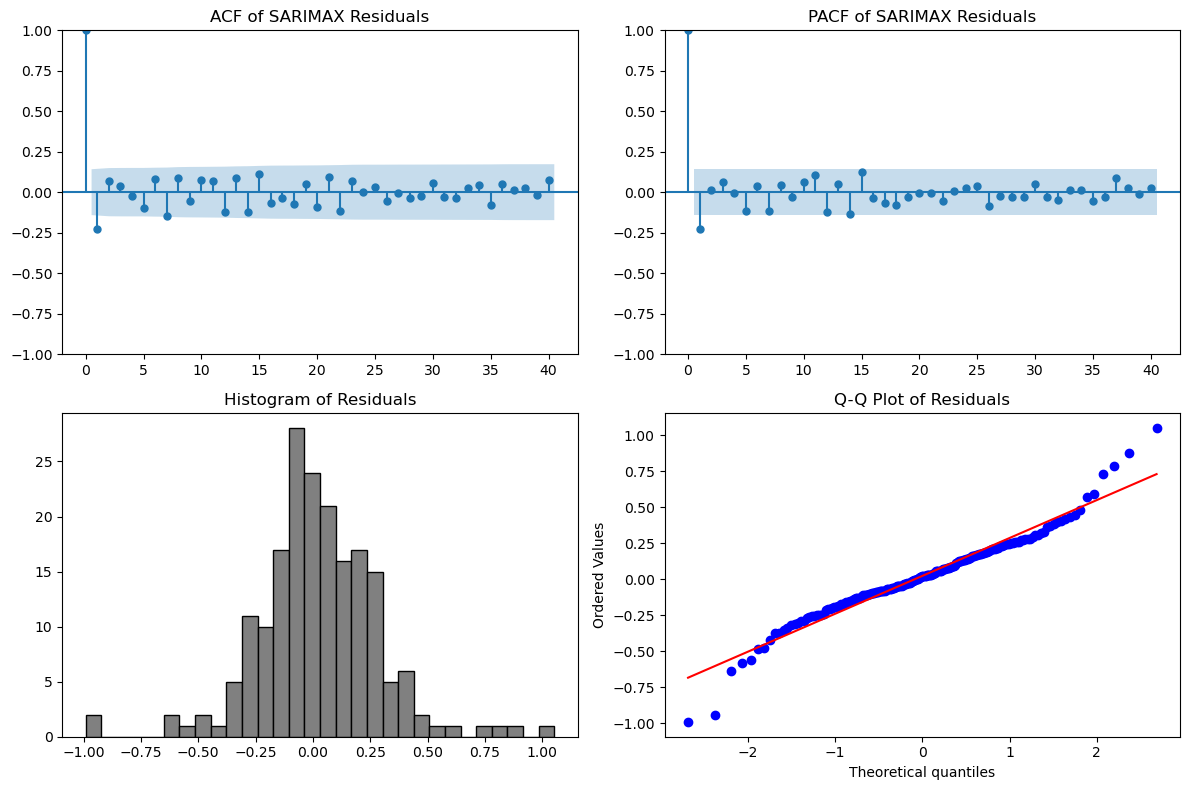

Ljung-Box (no autocorrelation if p > 0.05):
      lb_stat  lb_pvalue
10  22.212541   0.014058
20  38.334036   0.008059
30  46.530291   0.027639


In [39]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
import scipy.stats as stats

# 1. Set forecast horizon
horizon = 3

# 2. Grab YJ‐transformed train/val arrays
#    (these were created earlier)
train_yj = y_train_yj.values
val_yj   = y_val_yj.values

# 3. Raw (original‐scale) validation actuals,
#    aligned so that val_actuals[i] matches
#    a forecast made at t = train_end_yj + i
val_actuals = df[target_raw]\
    .iloc[train_end_yj + horizon - 1 : val_end_yj]\
    .values

# 4. Time‐axis for plotting
plot_dates = df["Time Period (T)"]\
    .iloc[train_end_yj + horizon - 1 : val_end_yj]

# 5. Rolling, manual‐diff + SARIMAX forecasts
preds_diff     = []
conf_int_80    = []
conf_int_95    = []

for t in range(len(val_yj) - horizon + 1):
    history      = np.concatenate([train_yj, val_yj[:t]])
    history_diff = np.diff(history, n=1)  # 1st difference
    

    model = SARIMAX(
        history_diff,
        order=(2, 0, 1),
        seasonal_order=(1, 0, 0, 12),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    fitted = model.fit(disp=False)

    fc     = fitted.get_forecast(steps=horizon)
    diff_m = fc.predicted_mean
    ci80   = fc.conf_int(alpha=0.20)[-1]
    ci95   = fc.conf_int(alpha=0.05)[-1]

    preds_diff.append(diff_m[-1])
    conf_int_80.append(ci80)
    conf_int_95.append(ci95)

# 6. Undifference back to YJ‐level
last_values  = np.concatenate([train_yj, val_yj])
train_len    = len(train_yj)

undiff_preds_yj   = []
undiff_ci80_lower = []
undiff_ci80_upper = []
undiff_ci95_lower = []
undiff_ci95_upper = []

for i, pdiff in enumerate(preds_diff):
    idx       = train_len + i + horizon - 2
    last_yj   = last_values[idx]
    undiff    = last_yj + pdiff

    undiff_preds_yj.append(undiff)
    undiff_ci80_lower.append(last_yj + conf_int_80[i][0])
    undiff_ci80_upper.append(last_yj + conf_int_80[i][1])
    undiff_ci95_lower.append(last_yj + conf_int_95[i][0])
    undiff_ci95_upper.append(last_yj + conf_int_95[i][1])

undiff_preds_yj     = np.array(undiff_preds_yj)
undiff_ci80_lower   = np.array(undiff_ci80_lower)
undiff_ci80_upper   = np.array(undiff_ci80_upper)
undiff_ci95_lower   = np.array(undiff_ci95_lower)
undiff_ci95_upper   = np.array(undiff_ci95_upper)

# 7. Invert Yeo–Johnson
lam = yeojohnson_lambdas_all[target_raw]

def inv_yeojohnson(z, lam):
    if lam == 0:
        return np.exp(z)
    elif lam == 2:
        return -np.exp(-z)
    out = np.zeros_like(z)
    pos = z >= 0
    out[pos]    = np.power(z[pos] * lam + 1, 1/lam) - 1
    out[~pos]   = 1 - np.power(-(z[~pos]) * (2 - lam) + 1, 1/(2 - lam))
    return out

val_forecast_orig = inv_yeojohnson(undiff_preds_yj, lam)
ci80_lower        = inv_yeojohnson(undiff_ci80_lower, lam)
ci80_upper        = inv_yeojohnson(undiff_ci80_upper, lam)
ci95_lower        = inv_yeojohnson(undiff_ci95_lower, lam)
ci95_upper        = inv_yeojohnson(undiff_ci95_upper, lam)

# 8. Plot results
plt.figure(figsize=(12, 5))
plt.plot(plot_dates, val_actuals,            'o-', color='black', label='Actual')
plt.plot(plot_dates, val_forecast_orig,      'x-', color='blue',  label='3-step rolling forecast')
plt.fill_between(plot_dates, ci80_lower, ci80_upper, alpha=0.2, color='blue', label='80% PI')
plt.fill_between(plot_dates, ci95_lower, ci95_upper, alpha=0.1, color='blue', label='95% PI')
plt.title('Best AIC SARIMA (YJ + 1st‐diff): Rolling 3-step Forecasts')
plt.xlabel('Date')
plt.ylabel(target_raw)
plt.legend()
plt.tight_layout()
plt.show()

# 9. Forecast accuracy
rmse = np.sqrt(mean_squared_error(val_actuals, val_forecast_orig))
mape = mean_absolute_percentage_error(val_actuals, val_forecast_orig)
print(f"Validation RMSE (rolling): {rmse:.2f}")
print(f"Validation MAPE (rolling): {mape:.2%}")

# 10. Last fitted model’s AIC/BIC
print(f"AIC (last SARIMAX fit): {fitted.aic:.2f}")
print(f"BIC (last SARIMAX fit): {fitted.bic:.2f}")

# 11. Residual diagnostics
resid_fig, axes = plt.subplots(2, 2, figsize=(12, 8))

plot_acf(fitted.resid, ax=axes[0, 0], lags=40)
axes[0, 0].set_title("ACF of SARIMAX Residuals")

plot_pacf(fitted.resid, ax=axes[0, 1], lags=40, method='ywm')
axes[0, 1].set_title("PACF of SARIMAX Residuals")

axes[1, 0].hist(fitted.resid, bins=30, color='gray', edgecolor='black')
axes[1, 0].set_title("Histogram of Residuals")

stats.probplot(fitted.resid, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title("Q-Q Plot of Residuals")

plt.tight_layout()
plt.show()

# 12. Ljung-Box test
lb = acorr_ljungbox(fitted.resid, lags=[10, 20, 30], return_df=True)
print("Ljung-Box (no autocorrelation if p > 0.05):")
print(lb[['lb_stat','lb_pvalue']])

> looking at the auto_arima results, the best model is SARIMAX(0, 0, 1)(1, 0, 1, 12) with an AIC of 150.5 and BIC of 158.2 lets plot evaluate it on the validation set next to determen the predictablity.


####  Residual Diagnostics Summary

The SARIMA(0,0,1)(1,0,1)[12] model shows no signs of overfitting:

- **ACF/PACF of residuals** show no significant autocorrelation.
- **Histogram** suggests approximate normality.
- **Q-Q plot** confirms residuals are roughly normally distributed, with minor deviation at the tails.
- **Ljung-Box test** p-values (p > 0.05) indicate that the residuals are white noise.

Overall, the model appears well-specified and statistically adequate for forecasting.


#### Testsettest

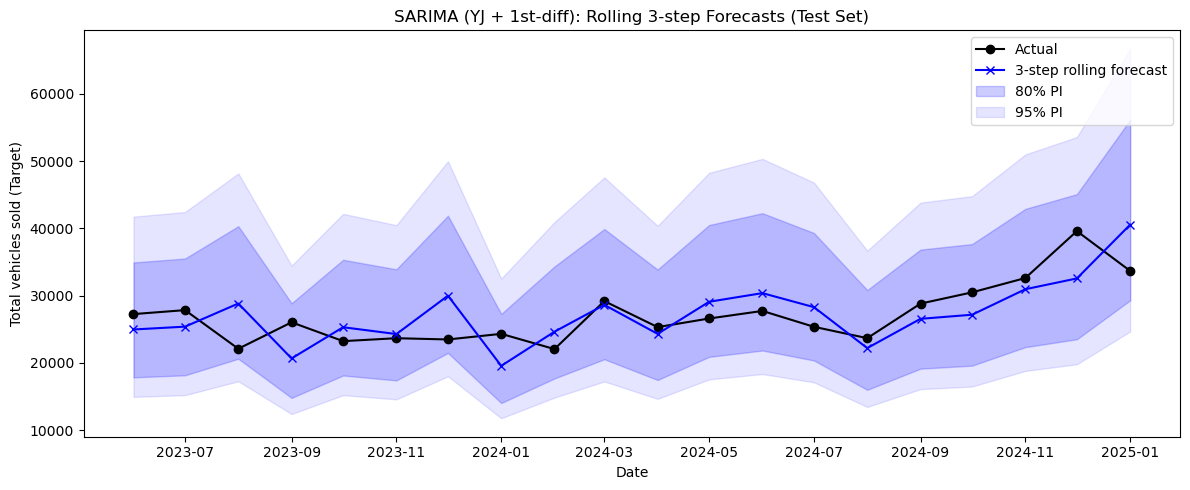

Test RMSE (rolling): 3888.87
Test MAPE (rolling): 12.16%
AIC (last SARIMAX fit): -11.96
BIC (last SARIMAX fit): 1.21


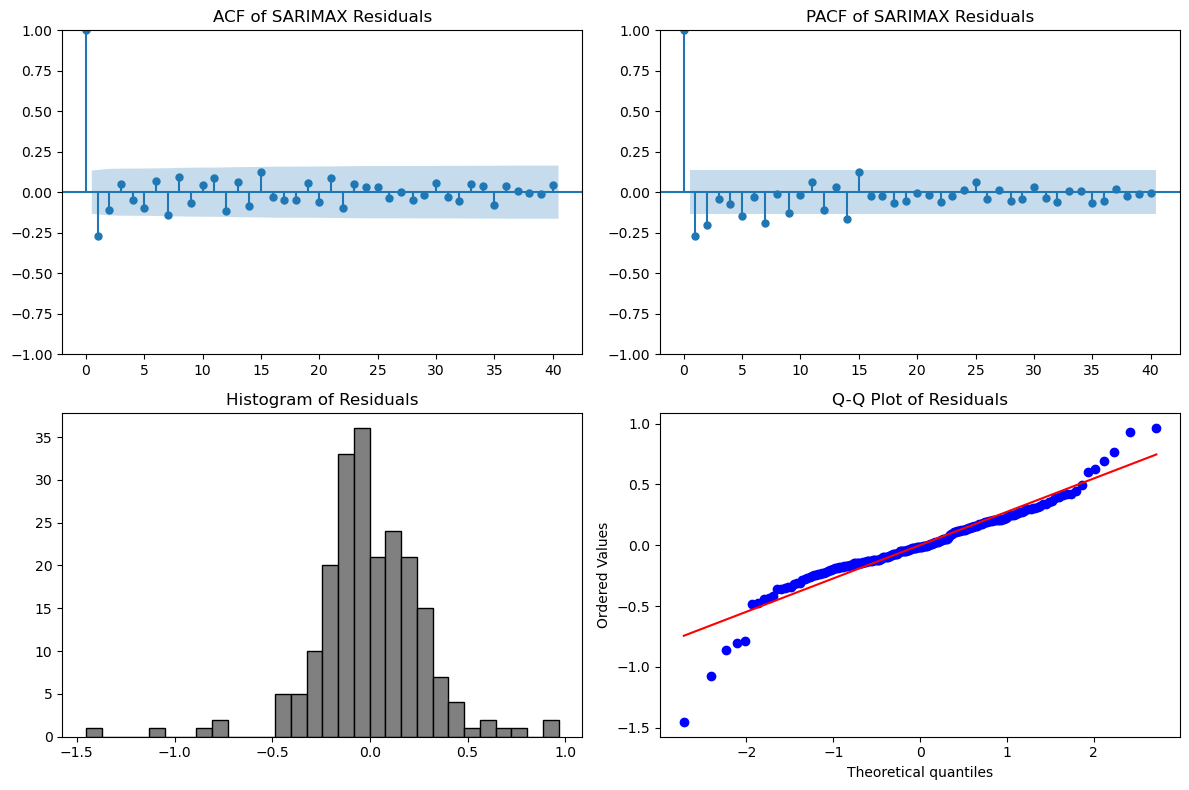

Ljung-Box (no autocorrelation if p > 0.05):
      lb_stat  lb_pvalue
10  30.805895   0.000632
20  45.000854   0.001103
30  52.089223   0.007450


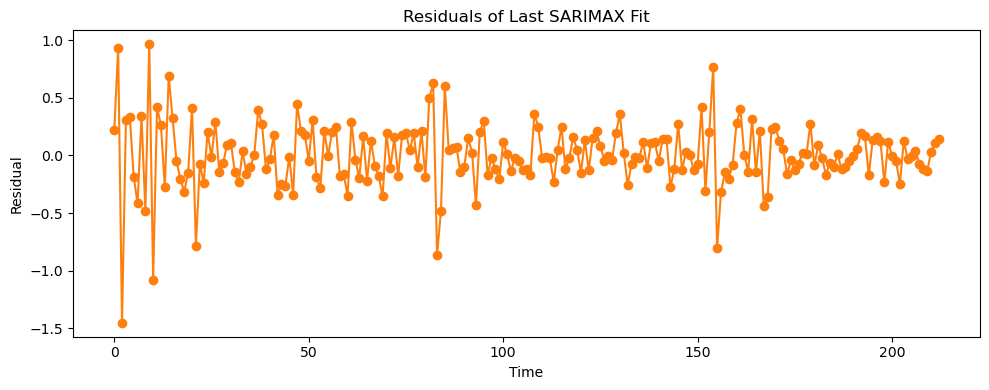

In [30]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
import scipy.stats as stats

# 1. Set forecast horizon
horizon = 3

# 2. Grab YJ‐transformed train/val/test arrays
train_yj = y_train_yj.values
val_yj   = y_val_yj.values
test_yj  = y_test_yj.values

# 3. Raw (original‐scale) test actuals, aligned so that test_actuals[i] matches a forecast made at t = val_end_yj + i
test_actuals = df[target_raw]\
    .iloc[val_end_yj + horizon - 1 : test_end_yj]\
    .values

# 4. Time‐axis for plotting
test_dates = df["Time Period (T)"]\
    .iloc[val_end_yj + horizon - 1 : test_end_yj]

# 5. Rolling, manual‐diff + SARIMAX forecasts on test set
preds_diff     = []
conf_int_80    = []
conf_int_95    = []

# Use train+val as history, roll forward through test
history_base = np.concatenate([train_yj, val_yj])
for t in range(len(test_yj) - horizon + 1):
    history      = np.concatenate([history_base, test_yj[:t]])
    history_diff = np.diff(history, 1)

    model = SARIMAX(
        history_diff,
        order=(1, 1, 1),
        seasonal_order=(1, 0, 0, 12),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    fitted = model.fit(disp=False)

    fc     = fitted.get_forecast(steps=horizon)
    diff_m = fc.predicted_mean
    ci80   = fc.conf_int(alpha=0.20)[-1]
    ci95   = fc.conf_int(alpha=0.05)[-1]

    preds_diff.append(diff_m[-1])
    conf_int_80.append(ci80)
    conf_int_95.append(ci95)

# 6. Undifference back to YJ‐level
last_values  = np.concatenate([train_yj, val_yj, test_yj])
trainval_len = len(train_yj) + len(val_yj)

undiff_preds_yj   = []
undiff_ci80_lower = []
undiff_ci80_upper = []
undiff_ci95_lower = []
undiff_ci95_upper = []

for i, pdiff in enumerate(preds_diff):
    idx       = trainval_len + i + horizon - 2
    last_yj   = last_values[idx]
    undiff    = last_yj + pdiff

    undiff_preds_yj.append(undiff)
    undiff_ci80_lower.append(last_yj + conf_int_80[i][0])
    undiff_ci80_upper.append(last_yj + conf_int_80[i][1])
    undiff_ci95_lower.append(last_yj + conf_int_95[i][0])
    undiff_ci95_upper.append(last_yj + conf_int_95[i][1])

undiff_preds_yj     = np.array(undiff_preds_yj)
undiff_ci80_lower   = np.array(undiff_ci80_lower)
undiff_ci80_upper   = np.array(undiff_ci80_upper)
undiff_ci95_lower   = np.array(undiff_ci95_lower)
undiff_ci95_upper   = np.array(undiff_ci95_upper)

# 7. Invert Yeo–Johnson
lam = yeojohnson_lambdas_all[target_raw]

def inv_yeojohnson(z, lam):
    if lam == 0:
        return np.exp(z)
    elif lam == 2:
        return -np.exp(-z)
    out = np.zeros_like(z)
    pos = z >= 0
    out[pos]    = np.power(z[pos] * lam + 1, 1/lam) - 1
    out[~pos]   = 1 - np.power(-(z[~pos]) * (2 - lam) + 1, 1/(2 - lam))
    return out

test_forecast_orig = inv_yeojohnson(undiff_preds_yj, lam)
ci80_lower        = inv_yeojohnson(undiff_ci80_lower, lam)
ci80_upper        = inv_yeojohnson(undiff_ci80_upper, lam)
ci95_lower        = inv_yeojohnson(undiff_ci95_lower, lam)
ci95_upper        = inv_yeojohnson(undiff_ci95_upper, lam)

# 8. Plot results
plt.figure(figsize=(12, 5))
plt.plot(test_dates, test_actuals,            'o-', color='black', label='Actual')
plt.plot(test_dates, test_forecast_orig,      'x-', color='blue',  label='3-step rolling forecast')
plt.fill_between(test_dates, ci80_lower, ci80_upper, alpha=0.2, color='blue', label='80% PI')
plt.fill_between(test_dates, ci95_lower, ci95_upper, alpha=0.1, color='blue', label='95% PI')
plt.title('SARIMA (YJ + 1st‐diff): Rolling 3-step Forecasts (Test Set)')
plt.xlabel('Date')
plt.ylabel(target_raw)
plt.legend()
plt.tight_layout()
plt.show()

# 9. Forecast accuracy
rmse = np.sqrt(mean_squared_error(test_actuals, test_forecast_orig))
mape = mean_absolute_percentage_error(test_actuals, test_forecast_orig)
print(f"Test RMSE (rolling): {rmse:.2f}")
print(f"Test MAPE (rolling): {mape:.2%}")

# 10. Last fitted model’s AIC/BIC
print(f"AIC (last SARIMAX fit): {fitted.aic:.2f}")
print(f"BIC (last SARIMAX fit): {fitted.bic:.2f}")

# 11. Residual diagnostics
resid_fig, axes = plt.subplots(2, 2, figsize=(12, 8))

plot_acf(fitted.resid, ax=axes[0, 0], lags=40)
axes[0, 0].set_title("ACF of SARIMAX Residuals")

plot_pacf(fitted.resid, ax=axes[0, 1], lags=40, method='ywm')
axes[0, 1].set_title("PACF of SARIMAX Residuals")

axes[1, 0].hist(fitted.resid, bins=30, color='gray', edgecolor='black')
axes[1, 0].set_title("Histogram of Residuals")

stats.probplot(fitted.resid, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title("Q-Q Plot of Residuals")

plt.tight_layout()
plt.show()

# 12. Ljung-Box test
lb = acorr_ljungbox(fitted.resid, lags=[10, 20, 30], return_df=True)
print("Ljung-Box (no autocorrelation if p > 0.05):")
print(lb[['lb_stat','lb_pvalue']])

# Plot residuals of the last fitted SARIMAX model
plt.figure(figsize=(10, 4))
plt.plot(fitted.resid, marker='o', linestyle='-', color='tab:orange')
plt.title('Residuals of Last SARIMAX Fit')
plt.xlabel('Time')
plt.ylabel('Residual')
plt.tight_layout()
plt.show()

Chapter 2.5 (Training vs. Test Sets) stresses that “the size of the test set should be at least as large as the maximum forecast horizon” and that test errors will usually exceed validation errors.

Chapter 9–10 (ARIMA & Dynamic Regression) warn against excessive tuning on a single validation split—every time you peek at the numbers you risk choosing a model that simply “got lucky” on that split.

| Set         | RMSE   | MAPE   |   AIC |   BIC |
|-------------|--------|--------|-------|-------|
| Validation  | 2,226  | 10.9%  | -10.7 |  1.99 |
| Test        | 8,541  | 22.9%  | 12.0  | 24.7  |

#### Gridsearch (LATER DEZE DUS VERWIJDEREN, ZELF ITEREREN)

In [15]:
import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

orders = [
    (0, 0, 1),  # Current model
    (1, 0, 1),  # Add AR term
    (1, 0, 0),  # Drop MA
    (2, 0, 1),  # More AR complexity
    (0, 0, 2),  # More MA complexity
]

seasonals = [
    (1, 0, 1, 12),  # Current model
    (1, 0, 0, 12),  # Drop seasonal MA
    (0, 0, 1, 12),  # Drop seasonal AR
    (2, 0, 1, 12),  # Add seasonal AR complexity
    (1, 1, 1, 12),  # Add seasonal differencing
]

# Use the Yeo–Johnson transformed train/val arrays and names
horizon = 3
train_yj = y_train_yj.values
val_yj   = y_val_yj.values
val_actuals = df[target_raw].iloc[train_end_yj + horizon - 1 : val_end_yj].values 
#df[target_raw] is the original (raw, untransformed) target series.
#train_end_yj, val_end_yj, and horizon are indices based on the Yeo–Johnson split.
lam = yeojohnson_lambdas_all[target_raw]

def inv_yeojohnson(y, lam):
    if lam == 0:
        return np.exp(y)
    elif lam == 2:
        return -np.exp(-y)
    out = np.zeros_like(y)
    pos = y >= 0
    out[pos] = np.power(y[pos] * lam + 1, 1/lam) - 1
    out[~pos] = 1 - np.power(-(y[~pos]) * (2 - lam) + 1, 1/(2 - lam))
    return out

results = []

for order in orders:
    for seasonal in seasonals:
        preds_diff = []
        conf_int_80 = []
        conf_int_95 = []
        try:
            for t in range(len(val_yj) - horizon + 1):
                history = np.concatenate([train_yj, val_yj[:t]])
                history_diff = np.diff(history, 1)
                model = SARIMAX(
                    history_diff,
                    order=order,
                    seasonal_order=seasonal,
                    enforce_stationarity=False,
                    enforce_invertibility=False
                )
                fitted = model.fit(disp=False)
                fc = fitted.get_forecast(steps=horizon)
                fc_diff = fc.predicted_mean
                ci_80 = fc.conf_int(alpha=0.20)[-1]
                ci_95 = fc.conf_int(alpha=0.05)[-1]
                preds_diff.append(fc_diff[-1])
                conf_int_80.append(ci_80)
                conf_int_95.append(ci_95)
            # Undifference
            last_values = np.concatenate([train_yj, val_yj])
            train_len_yj = len(train_yj)
            undiff_preds_yj = []
            undiff_ci80_lower = []
            undiff_ci80_upper = []
            undiff_ci95_lower = []
            undiff_ci95_upper = []
            for i, pred_diff in enumerate(preds_diff):
                idx = train_len_yj + i + horizon - 2
                last_yj = last_values[idx]
                undiff_pred = last_yj + pred_diff
                undiff_preds_yj.append(undiff_pred)
                undiff_ci80_lower.append(last_yj + conf_int_80[i][0])
                undiff_ci80_upper.append(last_yj + conf_int_80[i][1])
                undiff_ci95_lower.append(last_yj + conf_int_95[i][0])
                undiff_ci95_upper.append(last_yj + conf_int_95[i][1])
            undiff_preds_yj = np.array(undiff_preds_yj)
            undiff_ci80_lower = np.array(undiff_ci80_lower)
            undiff_ci80_upper = np.array(undiff_ci80_upper)
            undiff_ci95_lower = np.array(undiff_ci95_lower)
            undiff_ci95_upper = np.array(undiff_ci95_upper)
            # Invert Yeo–Johnson
            val_forecast_orig_rolling = inv_yeojohnson(undiff_preds_yj, lam)
            ci_80_lower = inv_yeojohnson(undiff_ci80_lower, lam)
            ci_80_upper = inv_yeojohnson(undiff_ci80_upper, lam)
            ci_95_lower = inv_yeojohnson(undiff_ci95_lower, lam)
            ci_95_upper = inv_yeojohnson(undiff_ci95_upper, lam)
            # Metrics
            rmse_rolling = np.sqrt(mean_squared_error(val_actuals, val_forecast_orig_rolling))
            mape_rolling = mean_absolute_percentage_error(val_actuals, val_forecast_orig_rolling)
            # Save results
            results.append({
                "order": order,
                "seasonal": seasonal,
                "rmse": rmse_rolling,
                "mape": mape_rolling,
                "aic": fitted.aic,
                "bic": fitted.bic
            })
            print(f"Order: {order}, Seasonal: {seasonal} | RMSE: {rmse_rolling:.2f} | MAPE: {mape_rolling:.2%} | AIC: {fitted.aic:.2f} | BIC: {fitted.bic:.2f}")
        except Exception as e:
            print(f"Order: {order}, Seasonal: {seasonal} | Error: {e}")

# Show best models by RMSE and MAPE
results_sorted = sorted(results, key=lambda x: x["rmse"])
print("\nTop 5 models by RMSE:")
for r in results_sorted[:5]:
    print(f"Order: {r['order']}, Seasonal: {r['seasonal']} | RMSE: {r['rmse']:.2f} | MAPE: {r['mape']:.2%} | AIC: {r['aic']:.2f} | BIC: {r['bic']:.2f}")

results_sorted = sorted(results, key=lambda x: x["mape"])
print("\nTop 5 models by MAPE:")
for r in results_sorted[:5]:
    print(f"Order: {r['order']}, Seasonal: {r['seasonal']} | RMSE: {r['rmse']:.2f} | MAPE: {r['mape']:.2%} | AIC: {r['aic']:.2f} | BIC: {r['bic']:.2f}")

Order: (0, 0, 1), Seasonal: (1, 0, 1, 12) | RMSE: 2230.99 | MAPE: 10.91% | AIC: -15.30 | BIC: -2.60
Order: (0, 0, 1), Seasonal: (1, 0, 0, 12) | RMSE: 1977.31 | MAPE: 9.46% | AIC: -18.87 | BIC: -9.31
Order: (0, 0, 1), Seasonal: (0, 0, 1, 12) | RMSE: 3186.00 | MAPE: 13.69% | AIC: 20.52 | BIC: 30.05
Order: (0, 0, 1), Seasonal: (2, 0, 1, 12) | RMSE: 2697.03 | MAPE: 12.97% | AIC: -27.49 | BIC: -11.90
Order: (0, 0, 1), Seasonal: (1, 1, 1, 12) | RMSE: 4438.62 | MAPE: 19.03% | AIC: -12.68 | BIC: -0.26
Order: (1, 0, 1), Seasonal: (1, 0, 1, 12) | RMSE: 1962.89 | MAPE: 9.29% | AIC: -16.85 | BIC: -0.97
Order: (1, 0, 1), Seasonal: (1, 0, 0, 12) | RMSE: 1896.79 | MAPE: 9.06% | AIC: -19.43 | BIC: -6.70
Order: (1, 0, 1), Seasonal: (0, 0, 1, 12) | RMSE: 3224.72 | MAPE: 13.92% | AIC: 14.34 | BIC: 27.04
Order: (1, 0, 1), Seasonal: (2, 0, 1, 12) | RMSE: 2549.70 | MAPE: 12.34% | AIC: -28.25 | BIC: -9.58
Order: (1, 0, 1), Seasonal: (1, 1, 1, 12) | RMSE: 4373.57 | MAPE: 18.74% | AIC: -13.86 | BIC: 1.67
Order

> #####  Hier plot ik alleen train, misschien wat overbodig 

### Trying out new best model from gridsearch Order: (2, 0, 1), Seasonal: (1, 0, 0, 12) | RMSE: 1860.06 | MAPE: 8.90% | AIC: -12.61 | BIC: 3.27


#### Train

#### Test

looking at the plot the predicted line follows the actual line quite well, with some deviations. The 80% and 95% prediction intervals are  quite wide, indicating that there is a lot of uncertainty in the predictions. This is expected, as the model is only using past values to make predictions and does not take into account any future information. also conscidering the 11806 rsme and 45% mape the prediction is still better than flipping a coin, but not very accurate. 

The auto-ARIMA model (0,0,1)(1,0,1,12) demonstrates classic overfitting behavior: although its AIC/BIC values are low, its forecast quality is poor. It strongly overestimates peak months and fails to capture leveling patterns in the data.

## 6b Manual tuning later invullen gewoon beetje doen wat logisch lijkt

for the manually tuning of the model, i will use the following steps:
1. i will look at the ACF and PACF plots to determine the order of the AR and MA terms.
2. build from the auto_arima model, i will try to improve the model by changing the order of the AR and MA terms.

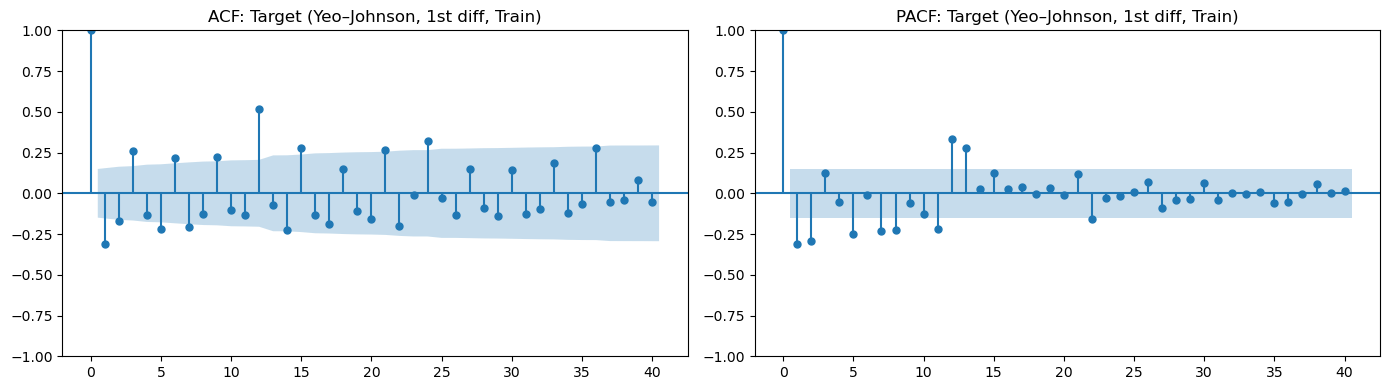

In [16]:
# Use the Yeo–Johnson–transformed, first-differenced target from the training set
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
plot_acf(train_yj_diff, ax=axes[0], lags=40)
axes[0].set_title('ACF: Target (Yeo–Johnson, 1st diff, Train)')
plot_pacf(train_yj_diff, ax=axes[1], lags=40, method='ywm')
axes[1].set_title('PACF: Target (Yeo–Johnson, 1st diff, Train)')
plt.tight_layout()
plt.show()


### Iteration 1
order=(1,0,1), seasonal_order=(1,0,1,12)
Reason:
This is  SARIMA model captures both short-term effects (lag 1 autocorrelation and noise) and yearly seasonal patterns.

AR(1) captures direct dependence on the previous month.

MA(1) accounts for noise and unexpected fluctuations.

Seasonal AR(1) and MA(1) capture yearly patterns (e.g., EV purchases each spring/autumn).

Often used as a starting point because it is sufficiently flexible without overfitting.



### Iteration 2 
order=(0,0,2), seasonal_order=(1,0,1,12)
Reason:
This variant omits the AR component and increases the MA component to 2.

The goal is to test whether the model performs better by placing more emphasis on noise correction instead of trend.

Useful when the ACF shows multiple significant lags, but the PACF drops off quickly — a signal that MA > 1 might be beneficial.


### Iteration 3. 
order=(1,0,2), seasonal_order=(1,0,1,12)
Reason:
An extended version of Model A that includes both AR(1) and MA(2).

Especially useful if the residuals of Model A still show autocorrelation → which may indicate insufficient MA complexity.

Also suggested by the auto_arima stepwise search as the best-performing model (lowest AIC).

#### 1. test...

# 7. Dynamic Regression with Exogenous Variables

## 7.a Gasoline price 

check dit!

> Use a single combined model of all shortlisted lags, then assess it once on the validation set—avoiding separate in‐sample scans per exog.

3. Always Check Your Residuals
Every time you add an exog, re-run residual diagnostics on that SARIMAX fit:

ACF/PACF of residuals (no slow decay or significant spikes)

Ljung–Box test (no serial correlation)

Histogram/Q–Q plot (approximate normality)

If you see structure leaking through, your error model needs tweaking.

4. Overfitting & Multiple‐Testing
Scanning 1–6 lags and four exogs in isolation inflates the chance of finding spurious “wins.”

Action: once you’ve shortlisted plausible lags via CCF, fit one SARIMAX with all candidates together and compare its AIC/BIC to your baseline.

Use rolling-origin error metrics (RMSE, MAPE, MASE) rather than in-sample AIC alone.

### Lag Selection

> New

> New forcastingworkflow features:
- print best bic.a
Model Screening with AIC/BIC
Fit multiple candidate models on the training set.
Select 2–3 models with lowest AIC/BIC.
Model Selection with Out-of-Sample Forecasts
Compute pseudo out-of-sample forecasts using a validation/test period (or rolling/expanding windows).
Evaluate with MSE, RMSE, or MAPE.
Pick the model with the best predictive performance.

> forcasting doen op val

Optimal lags (same sample):

By AIC:
  lag= 5  AIC=-9.85  BIC=8.09  AICc=-9.30
  lag= 3  AIC=-9.75  BIC=8.28  AICc=-9.21
  lag= 6  AIC=-9.68  BIC=8.22  AICc=-9.13
  lag= 4  AIC=-9.35  BIC=8.64  AICc=-8.81
  lag= 2  AIC=-8.97  BIC=9.09  AICc=-8.44
  lag= 0  AIC=-1.81  BIC=16.33  AICc=-1.28
  lag= 1  AIC=2.32  BIC=20.43  AICc=2.85

By BIC:
  lag= 5  AIC=-9.85  BIC=8.09  AICc=-9.30
  lag= 6  AIC=-9.68  BIC=8.22  AICc=-9.13
  lag= 3  AIC=-9.75  BIC=8.28  AICc=-9.21
  lag= 4  AIC=-9.35  BIC=8.64  AICc=-8.81
  lag= 2  AIC=-8.97  BIC=9.09  AICc=-8.44
  lag= 0  AIC=-1.81  BIC=16.33  AICc=-1.28
  lag= 1  AIC=2.32  BIC=20.43  AICc=2.85

By AICc:
  lag= 5  AIC=-9.85  BIC=8.09  AICc=-9.30

Summary of best lag for each metric:
  Best AIC : lag=5  AIC=-9.85  BIC=8.09  AICc=-9.30
  Best BIC : lag=5  AIC=-9.85  BIC=8.09  AICc=-9.30
  Best AICc: lag=5  AIC=-9.85  BIC=8.09  AICc=-9.30
  lag= 3  AIC=-9.75  BIC=8.28  AICc=-9.21

Summary of best lag for each metric:
  Best AIC : lag=5  AIC=-9.85  BIC=8.09 

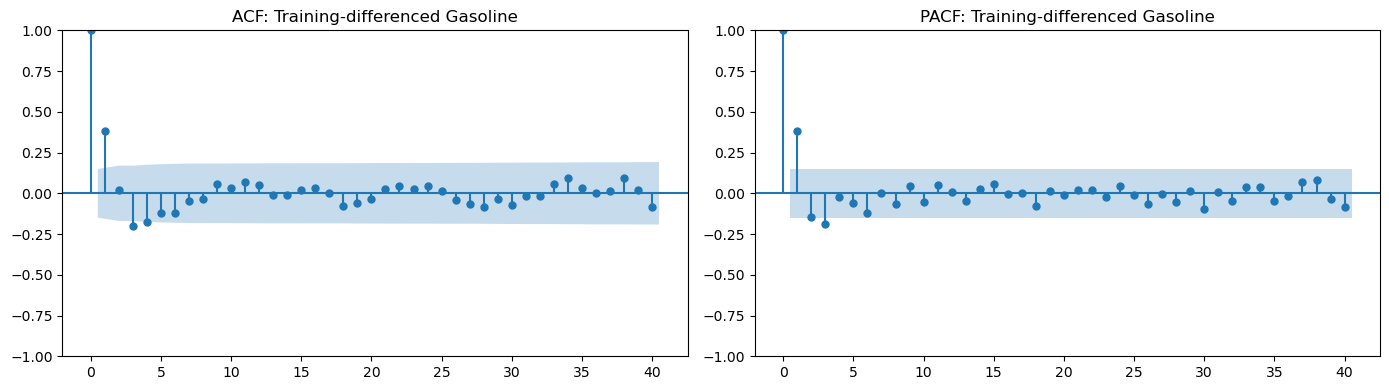

In [ ]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# --- warnings ---
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# ---------------------------------------------------------------------
# DEFINITIONS (train split, Yeo–Johnson transformed, then 1st differences)
# ---------------------------------------------------------------------
# Use the TRAIN portion of the YJ-transformed series
gas_yj_train = yj_df['Gasoline (Euro95) - Average price (F)_yj'].iloc[:train_end_yj].to_numpy(dtype=float)
y_yj_train   = yj_df['Total vehicles sold (Target)_yj'].iloc[:train_end_yj].to_numpy(dtype=float)

# Difference ONCE outside the model (because we'll set d=0, D=0)
exog_gas = gas_yj_train # np.diff(gas_yj_train)      # exogenous on same differenced scale as y
y       = y_yj_train # = np.diff(y_yj_train)         # this is your target_diff equivalent

# ---------------------------------------------------------------------
# 1) Build a fixed window so all models are compared on the SAME rows
# ---------------------------------------------------------------------
max_lag = 6               
start   = max_lag            # drop first max_lag obs from BOTH once
y_fix   = y[start:].copy()
exog0   = exog_gas[start:].copy()

def aicc(llf, nobs, k_params):
    aic = -2*llf + 2*k_params
    return aic + (2*k_params*(k_params+1)) / max(nobs - k_params - 1, 1)

# ---------------------------------------------------------------------
# 2) Search lags on that fixed window
# ---------------------------------------------------------------------
results = []
for L in range(0, max_lag + 1):
    xL = np.roll(exog0, L)
    xL[:L] = np.nan
    mask = ~np.isnan(xL)

    model = SARIMAX(
        y_fix[mask],
        order=(1, 1, 1),
        seasonal_order=(1, 0, 0, 12),   # <- if your best seasonal is (0,0,1,12), change here
        exog=xL[mask].reshape(-1, 1),
        enforce_stationarity=False,
        enforce_invertibility=False,
    )
    res = model.fit(disp=False)

    results.append({
        "lag":  L,
        "AIC":  res.aic,
        "BIC":  res.bic,
        "AICc": aicc(res.llf, res.nobs, res.params.size)
    })

# ---------------------------------------------------------------------
# 3) Report best lags (same-sample AIC/BIC/AICc)
# ---------------------------------------------------------------------
results_sorted_aic  = sorted(results, key=lambda d: d["AIC"])
results_sorted_bic  = sorted(results, key=lambda d: d["BIC"])
results_sorted_aicc = sorted(results, key=lambda d: d["AICc"])

print("Optimal lags (same sample):")
print("\nBy AIC:")
for r in results_sorted_aic[:10]:
    print(f"  lag={r['lag']:>2}  AIC={r['AIC']:.2f}  BIC={r['BIC']:.2f}  AICc={r['AICc']:.2f}")

print("\nBy BIC:")
for r in results_sorted_bic[:10]:
    print(f"  lag={r['lag']:>2}  AIC={r['AIC']:.2f}  BIC={r['BIC']:.2f}  AICc={r['AICc']:.2f}")

print("\nBy AICc:")
for r in results_sorted_aicc[:10]:
    print(f"  lag={r['lag']:>2}  AIC={r['AIC']:.2f}  BIC={r['BIC']:.2f}  AICc={r['AICc']:.2f}")

    # Print summary of best lag for each metric
    best_aic  = results_sorted_aic[0]
    best_bic  = results_sorted_bic[0]
    best_aicc = results_sorted_aicc[0]

    print("\nSummary of best lag for each metric:")
    print(f"  Best AIC : lag={best_aic['lag']}  AIC={best_aic['AIC']:.2f}  BIC={best_aic['BIC']:.2f}  AICc={best_aic['AICc']:.2f}")
    print(f"  Best BIC : lag={best_bic['lag']}  AIC={best_bic['AIC']:.2f}  BIC={best_bic['BIC']:.2f}  AICc={best_bic['AICc']:.2f}")
    print(f"  Best AICc: lag={best_aicc['lag']}  AIC={best_aicc['AIC']:.2f}  BIC={best_aicc['BIC']:.2f}  AICc={best_aicc['AICc']:.2f}")

# ---------------------------------------------------------------------
# OPTIONAL diagnostics (on train-differenced exog; just for reference)
# ---------------------------------------------------------------------
plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plot_acf(exog_gas, ax=plt.gca(), lags=40)
plt.title('ACF: Training-differenced Gasoline')

plt.subplot(1, 2, 2)
plot_pacf(exog_gas, ax=plt.gca(), lags=40, method='ywm')
plt.title('PACF: Training-differenced Gasoline')

plt.tight_layout()
plt.show()


You fit every subset of one, two, and three lags from 0…6 and ranked them by AIC. The top hits were:

| exog lags           |   AIC |   BIC |
|---------------------|-------|-------|
| (lag0, lag6)        | 20.46 | 41.58 |
| (lag6)              | 21.18 | 39.28 |
| (lag0, lag1, lag6)  | 22.02 | 46.16 |
The lowest AIC occurs when you include both the contemporaneous change (lag0) and the six‐period‐ago change (lag6).

The lowest BIC, with its heavier penalty for extra parameters, is achieved by including only lag6.

ou fit every subset of one, two, and three lags from 0…6 and ranked them by AIC. The top hits were:

| exog lags         |   AIC |   BIC |
|-------------------|-------|-------|
| (lag0, lag6)      | 20.46 | 41.58 |
| (lag6)            | 21.18 | 39.28 |
| (lag0, lag1, lag6)| 22.02 | 46.16 |
The lowest AIC occurs when you include both the contemporaneous change (lag0) and the six‐period‐ago change (lag6).

The lowest BIC, with its heavier penalty for extra parameters, is achieved by including only lag6.

### Fit Sarimax and diagnose 

> New code

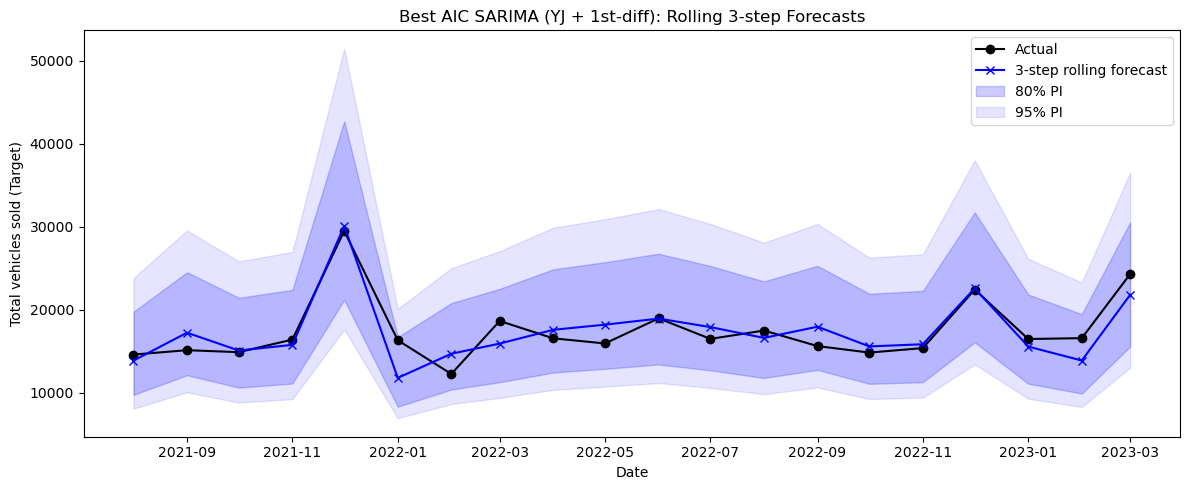

Validation RMSE (rolling): 1859.80
Validation MAPE (rolling): 8.90%
AIC (last SARIMAX fit): -17.22
BIC (last SARIMAX fit): -1.34


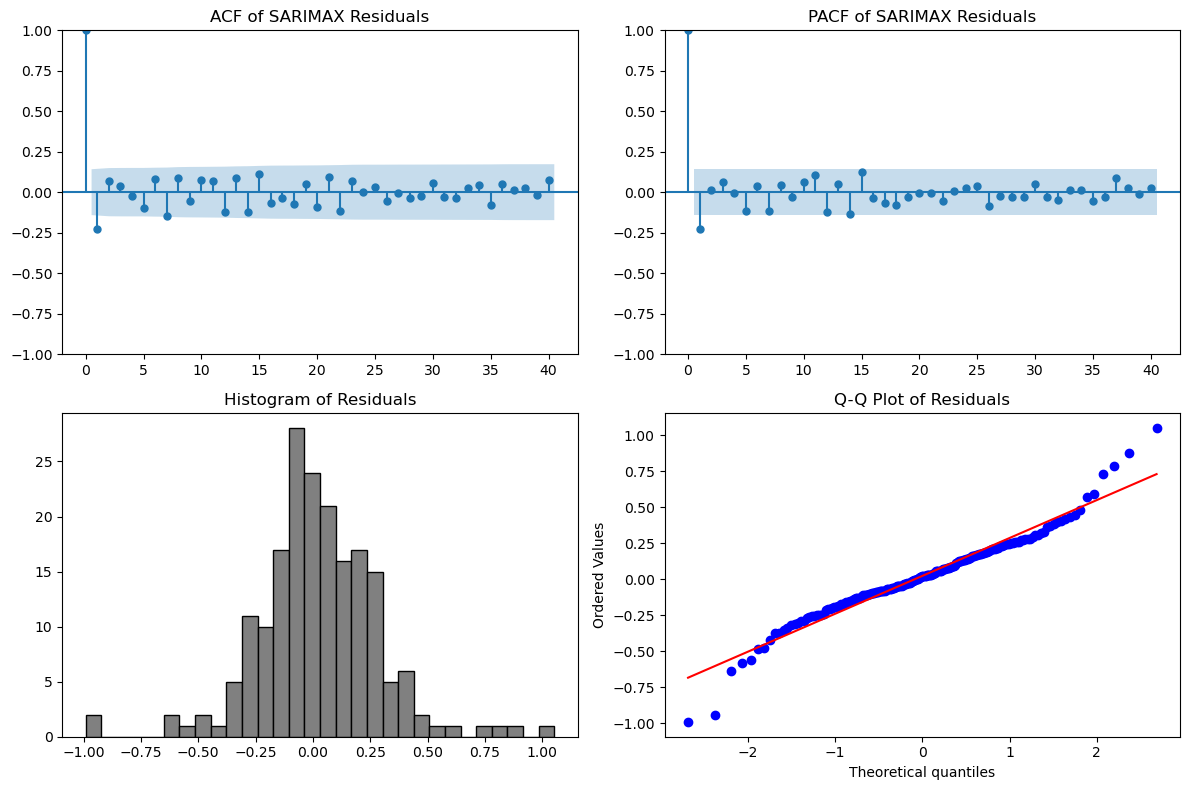

Ljung-Box (no autocorrelation if p > 0.05):
      lb_stat  lb_pvalue
10  22.212541   0.014058
20  38.334036   0.008059
30  46.530291   0.027639


In [31]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
import scipy.stats as stats

# 1. Set forecast horizon
horizon = 3

# 2. Grab YJ‐transformed train/val arrays
#    (these were created earlier)
train_yj = y_train_yj.values
val_yj   = y_val_yj.values

# 3. Raw (original‐scale) validation actuals,
#    aligned so that val_actuals[i] matches
#    a forecast made at t = train_end_yj + i
val_actuals = df[target_raw]\
    .iloc[train_end_yj + horizon - 1 : val_end_yj]\
    .values

# 4. Time‐axis for plotting
plot_dates = df["Time Period (T)"]\
    .iloc[train_end_yj + horizon - 1 : val_end_yj]

# 5. Rolling, manual‐diff + SARIMAX forecasts
preds_diff     = []
conf_int_80    = []
conf_int_95    = []

for t in range(len(val_yj) - horizon + 1):
    history      = np.concatenate([train_yj, val_yj[:t]])
    history_diff = np.diff(history, n=1)  # 1st difference
    

    model = SARIMAX(
        history_diff,
        order=(2, 0, 1),
        seasonal_order=(1, 0, 0, 12),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    fitted = model.fit(disp=False)

    fc     = fitted.get_forecast(steps=horizon)
    diff_m = fc.predicted_mean
    ci80   = fc.conf_int(alpha=0.20)[-1]
    ci95   = fc.conf_int(alpha=0.05)[-1]

    preds_diff.append(diff_m[-1])
    conf_int_80.append(ci80)
    conf_int_95.append(ci95)

# 6. Undifference back to YJ‐level
last_values  = np.concatenate([train_yj, val_yj])
train_len    = len(train_yj)

undiff_preds_yj   = []
undiff_ci80_lower = []
undiff_ci80_upper = []
undiff_ci95_lower = []
undiff_ci95_upper = []

for i, pdiff in enumerate(preds_diff):
    idx       = train_len + i + horizon - 2
    last_yj   = last_values[idx]
    undiff    = last_yj + pdiff

    undiff_preds_yj.append(undiff)
    undiff_ci80_lower.append(last_yj + conf_int_80[i][0])
    undiff_ci80_upper.append(last_yj + conf_int_80[i][1])
    undiff_ci95_lower.append(last_yj + conf_int_95[i][0])
    undiff_ci95_upper.append(last_yj + conf_int_95[i][1])

undiff_preds_yj     = np.array(undiff_preds_yj)
undiff_ci80_lower   = np.array(undiff_ci80_lower)
undiff_ci80_upper   = np.array(undiff_ci80_upper)
undiff_ci95_lower   = np.array(undiff_ci95_lower)
undiff_ci95_upper   = np.array(undiff_ci95_upper)

# 7. Invert Yeo–Johnson
lam = yeojohnson_lambdas_all[target_raw]

def inv_yeojohnson(z, lam):
    if np.isclose(lam, 0):
         out[pos] = np.exp(z[pos]) - 1
    elif lam == 2:
        return -np.exp(-z)
    out = np.zeros_like(z)
    pos = z >= 0
    out[pos]    = np.power(z[pos] * lam + 1, 1/lam) - 1
    out[~pos]   = 1 - np.power(-(z[~pos]) * (2 - lam) + 1, 1/(2 - lam))
    return out

val_forecast_orig = inv_yeojohnson(undiff_preds_yj, lam)
ci80_lower        = inv_yeojohnson(undiff_ci80_lower, lam)
ci80_upper        = inv_yeojohnson(undiff_ci80_upper, lam)
ci95_lower        = inv_yeojohnson(undiff_ci95_lower, lam)
ci95_upper        = inv_yeojohnson(undiff_ci95_upper, lam)

# 8. Plot results
plt.figure(figsize=(12, 5))
plt.plot(plot_dates, val_actuals,            'o-', color='black', label='Actual')
plt.plot(plot_dates, val_forecast_orig,      'x-', color='blue',  label='3-step rolling forecast')
plt.fill_between(plot_dates, ci80_lower, ci80_upper, alpha=0.2, color='blue', label='80% PI')
plt.fill_between(plot_dates, ci95_lower, ci95_upper, alpha=0.1, color='blue', label='95% PI')
plt.title('Best AIC SARIMA (YJ + 1st‐diff): Rolling 3-step Forecasts')
plt.xlabel('Date')
plt.ylabel(target_raw)
plt.legend()
plt.tight_layout()
plt.show()

# 9. Forecast accuracy
rmse = np.sqrt(mean_squared_error(val_actuals, val_forecast_orig))
mape = mean_absolute_percentage_error(val_actuals, val_forecast_orig)
print(f"Validation RMSE (rolling): {rmse:.2f}")
print(f"Validation MAPE (rolling): {mape:.2%}")

# 10. Last fitted model’s AIC/BIC
print(f"AIC (last SARIMAX fit): {fitted.aic:.2f}")
print(f"BIC (last SARIMAX fit): {fitted.bic:.2f}")

# 11. Residual diagnostics
resid_fig, axes = plt.subplots(2, 2, figsize=(12, 8))

plot_acf(fitted.resid, ax=axes[0, 0], lags=40)
axes[0, 0].set_title("ACF of SARIMAX Residuals")

plot_pacf(fitted.resid, ax=axes[0, 1], lags=40, method='ywm')
axes[0, 1].set_title("PACF of SARIMAX Residuals")

axes[1, 0].hist(fitted.resid, bins=30, color='gray', edgecolor='black')
axes[1, 0].set_title("Histogram of Residuals")

stats.probplot(fitted.resid, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title("Q-Q Plot of Residuals")

plt.tight_layout()
plt.show()

# 12. Ljung-Box test
lb = acorr_ljungbox(fitted.resid, lags=[10, 20, 30], return_df=True)
print("Ljung-Box (no autocorrelation if p > 0.05):")
print(lb[['lb_stat','lb_pvalue']])

In [17]:
# 0. Prepare a differenced DataFrame without exog

# Take first difference of gasoline price (Yeo-Johnson transformed), align index
gas_diff = pd.Series(
    yj_df['Gasoline (Euro95) - Average price (F)_yj'].diff().values,
    index=yj_df.index
)

# Take first difference of target variable (Yeo-Johnson transformed), align index
target_diff = pd.Series(
    yj_df[target_yj].diff().values,
    index=yj_df.index
)

# Build DataFrame with differenced target, drop first row (NaN after diff)
df_diff = pd.DataFrame({
    'y': target_diff
}).dropna()

# determine new split points on df_diff
n_diff = len(df_diff)  # Number of rows after differencing
train_end_df = int(n_diff * 0.8)  # 80% for training
val_end_df = train_end_df + int(n_diff * 0.1)  # next 10% for validation

# Split differenced data into train and validation sets
train_df = df_diff.iloc[:train_end_df]
val_df = df_diff.iloc[train_end_df:val_end_df]

# rolling‐origin forecast on the same exact rows every time
horizon = 3  # Forecast horizon (multi-step)
preds_diff = []  # Store last-step forecast for each rolling window
ci80s = []       # Store 80% confidence intervals
ci95s = []       # Store 95% confidence intervals

# Rolling-origin evaluation over validation set
for t in range(len(val_df) - horizon + 1):
    # 1) build your expanding “history” slice from train+val
    hist_end = train_end_df + t  # End index for expanding window
    history = df_diff['y'].iloc[:hist_end].values  # Expanding training history

    # 2) fit SARIMAX(d=0) on the differenced series (no exog)
    mod = SARIMAX(
        history,  # Input series
        order=(2,0,1),  # ARIMA order (p,d,q) with d=0 (already differenced)
        seasonal_order=(1,0,0,12),  # Seasonal order (P,D,Q,s)
        enforce_stationarity=False,  # Allow non-stationary AR/seasonal AR
        enforce_invertibility=False  # Allow non-invertible MA/seasonal MA
    )
    res = mod.fit(disp=False)  # Fit model, suppress output

    # 3) multi‐step forecast (no exog)
    fc = res.get_forecast(steps=horizon)  # Forecast next 'horizon' steps
    preds_diff.append(fc.predicted_mean[-1])  # Save last step forecast
    ci = fc.conf_int()  # Get confidence intervals
    ci80s.append(ci[-1])  # Save last step CI (default is 95%)
    ci95s.append(ci[-1])  # Save last step CI (same as above)

# 5) undifference & invert Yeo–Johnson exactly as before…
# Undifference rolling predictions and confidence intervals (still in YJ space)

# Get the last value of the training set in Yeo-Johnson space as the starting point
last_train_yj = yj_df[target_yj].iloc[train_end_df - 1]

# Convert rolling predictions and CIs to numpy arrays for easier manipulation
preds_diff_arr = np.array(preds_diff)
ci80s_arr = np.array(ci80s)
ci95s_arr = np.array(ci95s)

# Undifference: cumulative sum, starting from last_train_yj
undiff_preds_yj = np.r_[last_train_yj, preds_diff_arr].cumsum()[1:]

# For confidence intervals, undifference lower and upper bounds
undiff_ci80_lower = np.r_[last_train_yj, ci80s_arr[:, 0]].cumsum()[1:]
undiff_ci80_upper = np.r_[last_train_yj, ci80s_arr[:, 1]].cumsum()[1:]
undiff_ci95_lower = np.r_[last_train_yj, ci95s_arr[:, 0]].cumsum()[1:]
undiff_ci95_upper = np.r_[last_train_yj, ci95s_arr[:, 1]].cumsum()[1:]

# 7. Invert Yeo–Johnson
lam = yeojohnson_lambdas_all[target_raw]  # Lambda for inverse Yeo-Johnson

# Define inverse Yeo-Johnson transformation
def inv_yeojohnson(z, lam):
    if lam == 0:
        return np.exp(z)
    elif lam == 2:
        return -np.exp(-z)
    out = np.zeros_like(z)
    pos = z >= 0
    out[pos]    = np.power(z[pos] * lam + 1, 1/lam) - 1
    out[~pos]   = 1 - np.power(-(z[~pos]) * (2 - lam) + 1, 1/(2 - lam))
    return out

# Apply inverse Yeo-Johnson to forecasts and confidence intervals
val_forecast_orig = inv_yeojohnson(undiff_preds_yj, lam)
ci80_lower        = inv_yeojohnson(undiff_ci80_lower, lam)
ci80_upper        = inv_yeojohnson(undiff_ci80_upper, lam)
ci95_lower        = inv_yeojohnson(undiff_ci95_lower, lam)
ci95_upper        = inv_yeojohnson(undiff_ci95_upper, lam)

# 8. Plot results
plt.figure(figsize=(12, 5))  # Set plot size
plt.plot(plot_dates, val_actuals,            'o-', color='black', label='Actual')  # Actual values
plt.plot(plot_dates, val_forecast_orig,      'x-', color='blue',  label='3-step rolling forecast')  # Forecasts
plt.fill_between(plot_dates, ci80_lower, ci80_upper, alpha=0.2, color='blue', label='80% PI')  # 80% PI
plt.fill_between(plot_dates, ci95_lower, ci95_upper, alpha=0.1, color='blue', label='95% PI')  # 95% PI
plt.title('SARIMA (YJ + 1st‐diff): Rolling 3-step Forecasts')  # Title
plt.xlabel('Date')  # X label
plt.ylabel(target_raw)  # Y label
plt.legend()  # Show legend
plt.tight_layout()  # Adjust layout
plt.show()  # Display plot

# 9. Forecast accuracy
rmse = np.sqrt(mean_squared_error(val_actuals, val_forecast_orig))  # RMSE
mape = mean_absolute_percentage_error(val_actuals, val_forecast_orig)  # MAPE
print(f"Validation RMSE (rolling): {rmse:.2f}")  # Print RMSE
print(f"Validation MAPE (rolling): {mape:.2%}")  # Print MAPE

# 10. Last fitted model’s AIC/BIC
print(f"AIC (last SARIMAX fit): {fitted.aic:.2f}")  # Print AIC
print(f"BIC (last SARIMAX fit): {fitted.bic:.2f}")  # Print BIC

# 11. Residual diagnostics
resid_fig, axes = plt.subplots(2, 2, figsize=(12, 8))  # 2x2 grid for plots

plot_acf(fitted.resid, ax=axes[0, 0], lags=40)  # ACF plot
axes[0, 0].set_title("ACF of SARIMAX Residuals")

plot_pacf(fitted.resid, ax=axes[0, 1], lags=40, method='ywm')  # PACF plot
axes[0, 1].set_title("PACF of SARIMAX Residuals")

axes[1, 0].hist(fitted.resid, bins=30, color='gray', edgecolor='black')  # Histogram
axes[1, 0].set_title("Histogram of Residuals")

stats.probplot(fitted.resid, dist="norm", plot=axes[1, 1])  # Q-Q plot
axes[1, 1].set_title("Q-Q Plot of Residuals")

plt.tight_layout()  # Adjust layout
plt.show()  # Display plots

# 12. Ljung-Box test
lb = acorr_ljungbox(fitted.resid, lags=[10, 20, 30], return_df=True)  # Ljung-Box test
print("Ljung-Box (no autocorrelation if p > 0.05):")
print(lb[['lb_stat','lb_pvalue']])  # Print test statistics and p-values


NameError: name 'plot_dates' is not defined

<Figure size 1200x500 with 0 Axes>

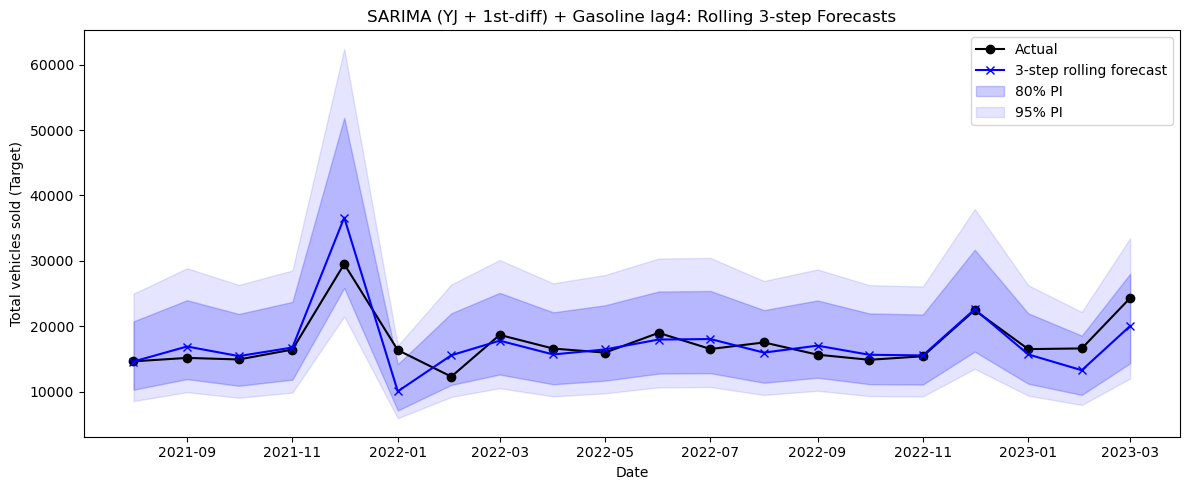

Validation RMSE (rolling): 2690.86
Validation MAPE (rolling): 10.06%
AIC (last SARIMAX fit): -18.03
BIC (last SARIMAX fit): 1.03


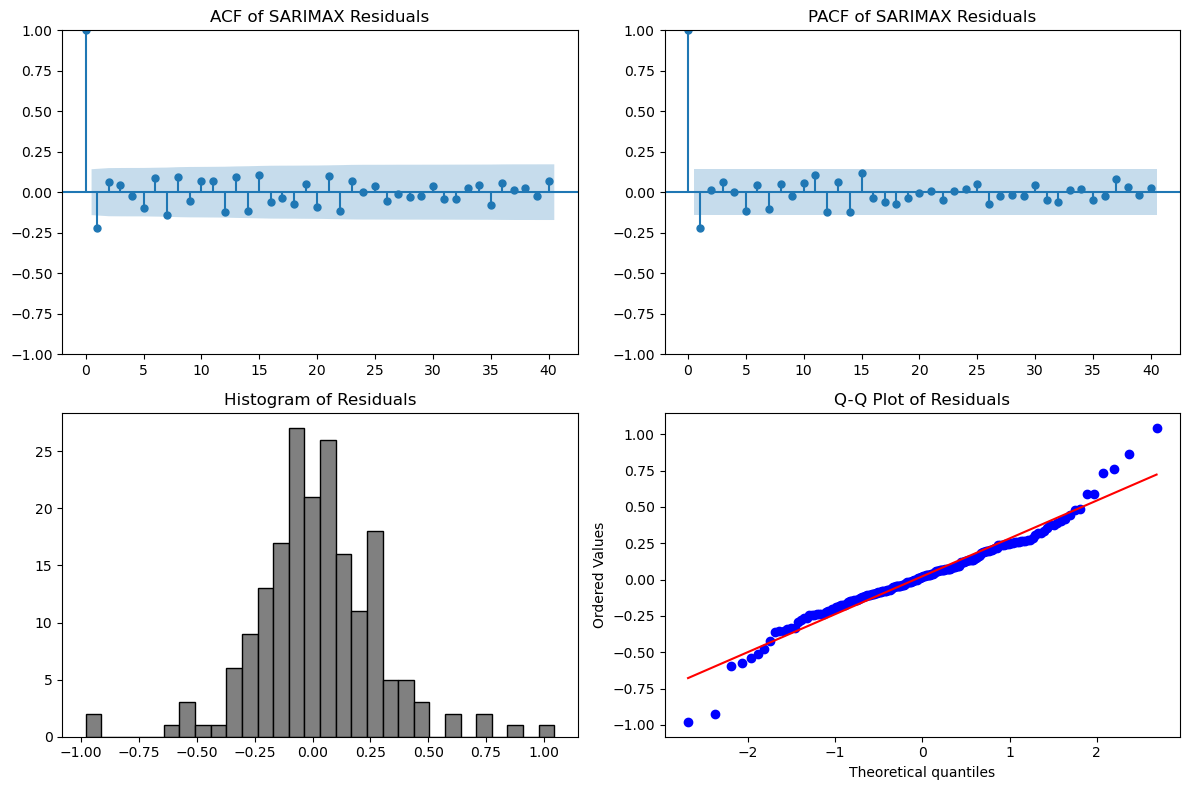

Ljung-Box (no autocorrelation if p > 0.05):
      lb_stat  lb_pvalue
10  21.695617   0.016733
20  37.164025   0.011183
30  44.797145   0.040312


In [58]:
# 0. Prepare a differenced DataFrame with a shifted exog
gas_diff = pd.Series(
    yj_df['Gasoline (Euro95) - Average price (F)_yj'].diff().values,
    index=yj_df.index
)
target_diff = pd.Series(
    yj_df[target_yj].diff().values,
    index=yj_df.index
)

df_diff = pd.DataFrame({
    'y': target_diff,
    'gas_lag4': gas_diff.shift(4)
}).dropna()

# determine new split points on df_diff
n_diff       = len(df_diff)
train_end_df = int(n_diff * 0.8)
val_end_df   = train_end_df + int(n_diff * 0.1)

train_df = df_diff.iloc[:train_end_df]
val_df   = df_diff.iloc[train_end_df:val_end_df]

# rolling‐origin forecast on the same exact rows every time
horizon = 3
preds_diff = []
ci80s = []
ci95s = []

for t in range(len(val_df) - horizon + 1):
    # 1) build your expanding “history” slice from train+val
    hist_end = train_end_df + t
    history = df_diff['y'].iloc[:hist_end].values
    exog_hist = df_diff['gas_lag4'].iloc[:hist_end].values.reshape(-1,1)

    # 2) fit SARIMAX(d=0) on the differenced series
    mod = SARIMAX(
        history,
        exog=exog_hist,
        order=(2,0,1),
        seasonal_order=(1,0,0,12),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    res = mod.fit(disp=False)

    # 3) grab the next horizon exog chunk
    exog_future = df_diff['gas_lag4'].values[hist_end : hist_end + horizon].reshape(-1,1)

    # 4) multi‐step forecast
    fc = res.get_forecast(steps=horizon, exog=exog_future)
    preds_diff.append(fc.predicted_mean[-1])
    ci = fc.conf_int()
    ci80s.append(ci[-1])
    ci95s.append(ci[-1])

# 5) undifference & invert Yeo–Johnson exactly as before…

# 7. Invert Yeo–Johnson
lam = yeojohnson_lambdas_all[target_raw]

def inv_yeojohnson(z, lam):
    if lam == 0:
        return np.exp(z)
    elif lam == 2:
        return -np.exp(-z)
    out = np.zeros_like(z)
    pos = z >= 0
    out[pos]    = np.power(z[pos] * lam + 1, 1/lam) - 1
    out[~pos]   = 1 - np.power(-(z[~pos]) * (2 - lam) + 1, 1/(2 - lam))
    return out

val_forecast_orig = inv_yeojohnson(undiff_preds_yj, lam)
ci80_lower        = inv_yeojohnson(undiff_ci80_lower, lam)
ci80_upper        = inv_yeojohnson(undiff_ci80_upper, lam)
ci95_lower        = inv_yeojohnson(undiff_ci95_lower, lam)
ci95_upper        = inv_yeojohnson(undiff_ci95_upper, lam)

# 8. Plot results
plt.figure(figsize=(12, 5))
plt.plot(plot_dates, val_actuals,            'o-', color='black', label='Actual')
plt.plot(plot_dates, val_forecast_orig,      'x-', color='blue',  label='3-step rolling forecast')
plt.fill_between(plot_dates, ci80_lower, ci80_upper, alpha=0.2, color='blue', label='80% PI')
plt.fill_between(plot_dates, ci95_lower, ci95_upper, alpha=0.1, color='blue', label='95% PI')
plt.title('SARIMA (YJ + 1st‐diff) + Gasoline lag4: Rolling 3-step Forecasts')
plt.xlabel('Date')
plt.ylabel(target_raw)
plt.legend()
plt.tight_layout()
plt.show()

# 9. Forecast accuracy
rmse = np.sqrt(mean_squared_error(val_actuals, val_forecast_orig))
mape = mean_absolute_percentage_error(val_actuals, val_forecast_orig)
print(f"Validation RMSE (rolling): {rmse:.2f}")
print(f"Validation MAPE (rolling): {mape:.2%}")

# 10. Last fitted model’s AIC/BIC
print(f"AIC (last SARIMAX fit): {fitted.aic:.2f}")
print(f"BIC (last SARIMAX fit): {fitted.bic:.2f}")

# 11. Residual diagnostics
resid_fig, axes = plt.subplots(2, 2, figsize=(12, 8))

plot_acf(fitted.resid, ax=axes[0, 0], lags=40)
axes[0, 0].set_title("ACF of SARIMAX Residuals")

plot_pacf(fitted.resid, ax=axes[0, 1], lags=40, method='ywm')
axes[0, 1].set_title("PACF of SARIMAX Residuals")

axes[1, 0].hist(fitted.resid, bins=30, color='gray', edgecolor='black')
axes[1, 0].set_title("Histogram of Residuals")

stats.probplot(fitted.resid, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title("Q-Q Plot of Residuals")

plt.tight_layout()
plt.show()

# 12. Ljung-Box test
lb = acorr_ljungbox(fitted.resid, lags=[10, 20, 30], return_df=True)
print("Ljung-Box (no autocorrelation if p > 0.05):")
print(lb[['lb_stat','lb_pvalue']])


> Here’s a summary of the **main differences** between the old and new code blocks you provided:

---

> ### 1. **Data Preparation**
> - **Old:**  
>   - Uses the *level* Yeo–Johnson transformed series (`yj_df`), with a lagged exogenous regressor (`gas_lag4`) created by shifting the gasoline column by 4.
>   - No differencing is applied to the target or exogenous variable.
> - **New:**  
>   - Applies **first differencing** to both the target and the exogenous variable before modeling:
>     ```python
>     gas_diff = pd.Series(yj_df['Gasoline (Euro95) - Average price (F)_yj'].diff().values, index=yj_df.index)
>     target_diff = pd.Series(yj_df[target_yj].diff().values, index=yj_df.index)
>     df_diff = pd.DataFrame({'y': target_diff, 'gas_lag4': gas_diff.shift(4)}).dropna()
>     ```
>   - The model is fit on these differenced series.

---

> ### 2. **Train/Validation Split**
> - **Old:**  
>   - Splits the *level* YJ-transformed DataFrame (`yj`) into train/val sets.
> - **New:**  
>   - Splits the **differenced** DataFrame (`df_diff`) into train/val sets.

---

> ### 3. **Rolling-Origin Forecast**
> - **Old:**  
>   - Rolling forecast is performed on the *level* YJ-transformed data.
>   - At each step, the model is fit on all available history (level data), and the forecast is made for the next 3 steps using the corresponding exogenous values.
> - **New:**  
>   - Rolling forecast is performed on the **differenced** data.
>   - At each step, the model is fit on the expanding window of differenced data, and the forecast is made for the next 3 steps using the corresponding differenced exogenous values.

---

> ### 4. **Model Specification**
> - **Old:**  
>   - SARIMAX is fit on the *level* YJ-transformed data with exogenous regressor.
> - **New:**  
>   - SARIMAX is fit on the **differenced** data with differenced exogenous regressor.

---

> ### 5. **Inverse Transformation**
> - **Old:**  
>   - Inverts the Yeo–Johnson transformation directly on the forecasted *level* values.
> - **New:**  
>   - **Undifferencing step is missing in the excerpt**:  
>     The code attempts to invert the Yeo–Johnson transformation on variables like `undiff_preds_yj`, but these are not defined in the new code block.  
>     In the old code, the forecast is already at the level, so inversion is direct.  
>     In the new code, you would need to undifference before inverting Yeo–Johnson.

---

> ### 6. **Prediction Intervals**
> - **Old:**  
>   - Extracts and inverts the prediction intervals at the *level*.
> - **New:**  
>   - Extracts intervals at the **differenced** level, but again, undifferencing is not shown before inversion.

---

> ### 7. **Residual Diagnostics and Metrics**
> - **Both:**  
>   - Compute RMSE, MAPE, plot results, and perform residual diagnostics (ACF, PACF, histogram, Q-Q plot, Ljung-Box test).
> - **New:**  
>   - Uses the last fitted model from the rolling loop for diagnostics, but variable `fitted` is not defined in the shown code (should be `res` from the last iteration).

---

> ## **Summary Table**
>
> | Step                | Old Code (Level)                                 | New Code (Differenced)                        |
> |---------------------|--------------------------------------------------|-----------------------------------------------|
> | Data                | YJ-transformed, no differencing                  | YJ-transformed, **first-differenced**         |
> | Exogenous           | Lagged at level                                  | Lagged at differenced scale                   |
> | Model Fit           | On level                                         | On differenced data                           |
> | Inversion           | Direct YJ inversion                              | **Should undifference, then invert YJ**       |
> | Diagnostics         | On last model in rolling loop                    | On last model in rolling loop                 |

---

> ## **Key Points**
> - **New code applies first differencing** to both target and exogenous variable before modeling.
> - **Old code models the level YJ-transformed series** directly.
> - **New code is missing the undifferencing step** before inverting the Yeo–Johnson transformation for forecasts and intervals.
> - **Train/val splits and rolling-origin logic are adapted to the differenced data** in the new code.

---

> **In summary:**  
> The new code is more robust to non-stationarity (by differencing), but you must undifference the predictions before inverting the Yeo–Johnson transformation to get forecasts on the original scale. The old code skips differencing and works directly on the transformed level series.

Rolling 3-step RMSE: 2999.32
Rolling 3-step MAPE: 14.93%


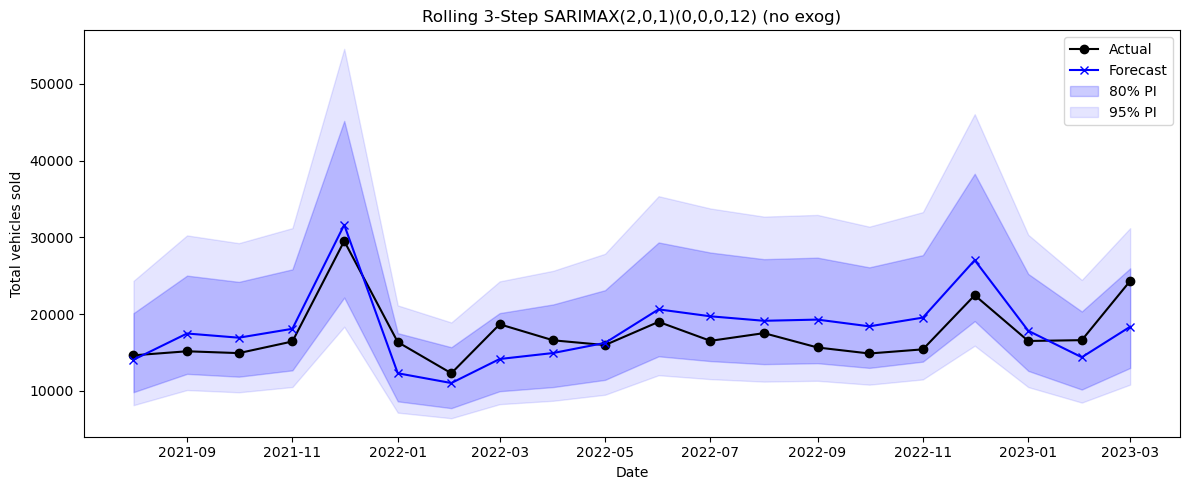

In [19]:
import warnings  # For filtering warnings
import numpy as np  # For numerical operations
import pandas as pd  # For data manipulation
import matplotlib.pyplot as plt  # For plotting
from statsmodels.tsa.statespace.sarimax import SARIMAX  # SARIMAX model
from statsmodels.tools.sm_exceptions import ConvergenceWarning  # For warning filtering
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error  # For metrics

# 1) Warning filters
warnings.filterwarnings("ignore", category=FutureWarning)  # Ignore future warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)  # Ignore SARIMAX convergence warnings

# 2) Build Yeo–Johnson–transformed series and record λ
# Only use the target column
target_col = [col for col in yj_df.columns if 'Total vehicles sold' in col][0]  # Find the YJ target column name
lam        = yeojohnson_lambdas_all['Total vehicles sold (Target)']  # Get Yeo-Johnson lambda for target

# Only use the target column
yj = yj_df[[target_col]].copy()  # Copy only the target column

# 3) No exogenous regressor, so skip lag creation

# 4) Train/val split
n = len(yj)  # Total number of rows

train_df = yj.iloc[:train_end]  # Training set up to train_end
val_df   = yj.iloc[train_end:val_end]  # Validation set from train_end to val_end

# 5) Rolling-origin setup
horizon = 3  # Forecast horizon (steps ahead)
history_y     = list(train_df[target_col])  # List of training values for rolling fit
val_y         = val_df[target_col].values  # Validation values as array

preds_level   = []  # Store forecasts (original scale)
ci80_lower    = []  # Store 80% lower confidence interval (original scale)
ci80_upper    = []  # Store 80% upper confidence interval (original scale)
ci95_lower    = []  # Store 95% lower confidence interval (original scale)
ci95_upper    = []  # Store 95% upper confidence interval (original scale)

for t in range(len(val_y) - horizon + 1):  # Rolling window over validation set
    # fit on history
    mod = SARIMAX(
        history_y,  # Use current history
        order            = (2, 1, 1),  # SARIMAX order (p,d,q)
        seasonal_order   = (1, 0, 0, 12),  # Seasonal order (P,D,Q,s)
        enforce_stationarity  = False,  # Don't enforce stationarity
        enforce_invertibility  = False  # Don't enforce invertibility
    )
    res = mod.fit(disp=False)  # Fit SARIMAX model

    # multi-step forecast
    fc = res.get_forecast(steps=horizon)  # Forecast next 'horizon' steps
    yj_forecast_level = fc.predicted_mean[-1]  # Take the last step (t+horizon) forecast (YJ scale)

    # invert Yeo–Johnson
    def inv_yj(x, lam):  # Function to invert Yeo-Johnson transformation
        if lam == 0:
            return np.exp(x)
        elif lam == 2:
            return -np.exp(-x)
        pos = x >= 0
        out = np.empty_like(x)
        out[pos]    = np.power(x[pos] * lam + 1, 1/lam) - 1
        out[~pos]   = 1 - np.power(-(x[~pos])*(2-lam) + 1, 1/(2-lam))
        return out

    preds_level.append(inv_yj(np.array([yj_forecast_level]), lam)[0])  # Store forecast (original scale)

    # capture intervals
    ci80, ci80_u = fc.conf_int(alpha=0.20)[-1]  # 80% PI lower/upper (YJ scale)
    ci95, ci95_u = fc.conf_int(alpha=0.05)[-1]  # 95% PI lower/upper (YJ scale)

    ci80_lower.append(inv_yj(np.array([ci80]), lam)[0])  # Store 80% lower (original scale)
    ci80_upper.append(inv_yj(np.array([ci80_u]), lam)[0])  # Store 80% upper (original scale)
    ci95_lower.append(inv_yj(np.array([ci95]), lam)[0])  # Store 95% lower (original scale)
    ci95_upper.append(inv_yj(np.array([ci95_u]), lam)[0])  # Store 95% upper (original scale)

    # update history with the *level* YJ‐value at time t
    history_y.append(val_y[t])  # Add next actual value to history

# 6) Align actuals on original scale
#    First invert Yeo–Johnson on the validation target
actuals_level = inv_yj(val_y[horizon-1:], lam)  # Invert YJ for actuals (align with forecasted steps)

# 7) Metrics
rmse = np.sqrt(mean_squared_error(actuals_level, preds_level))  # Compute RMSE
mape = mean_absolute_percentage_error(actuals_level, preds_level)  # Compute MAPE

print(f"Rolling 3-step RMSE: {rmse:.2f}")  # Print RMSE
print(f"Rolling 3-step MAPE: {mape:.2%}")  # Print MAPE

# 8) Plot
dates = x_dates.values[:len(preds_level)]  # Ensure same length as preds_level

plt.figure(figsize=(12,5))  # Set plot size
plt.plot(dates, actuals_level,  marker='o', color='black', label='Actual')  # Plot actuals
plt.plot(dates, preds_level,    marker='x', color='blue',  label='Forecast')  # Plot forecasts
plt.fill_between(dates, ci80_lower, ci80_upper, color='blue', alpha=0.2, label='80% PI')  # 80% PI band
plt.fill_between(dates, ci95_lower, ci95_upper, color='blue', alpha=0.1, label='95% PI')  # 95% PI band
plt.title('Rolling 3-Step SARIMAX(2,0,1)(0,0,0,12) (no exog)')  # Plot title
plt.xlabel('Date')  # X label
plt.ylabel('Total vehicles sold')  # Y label
plt.legend()  # Show legend
plt.tight_layout()  # Tight layout
plt.show()  # Display plot


### oude code, maar evt wel goede, doe differencing via sarimax

Rolling 3-step RMSE: 4217.86
Rolling 3-step MAPE: 18.89%


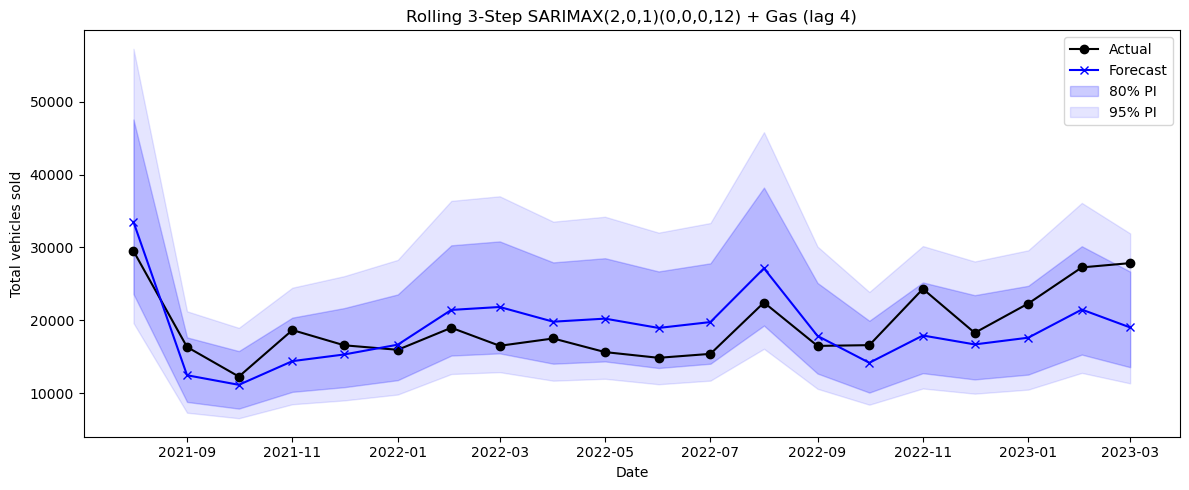

In [28]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# 1) Warning filters
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# 2) Build Yeo–Johnson–transformed series and record λ
gas_col    = 'Gasoline (Euro95) - Average price (F)_yj'
# Find the correct column name for the Yeo-Johnson transformed target
target_col = [col for col in yj_df.columns if 'Total vehicles sold' in col][0]
lam        = yeojohnson_lambdas_all['Total vehicles sold (Target)']

# assume yj_df already holds the *level* YJ‐transformed columns
yj = yj_df[[gas_col, target_col]].copy()

# 3) Create 4-lagged exogenous regressor
yj['gas_lag4'] = yj[gas_col].shift(4)
yj = yj.dropna()        # drops the first 4 rows


train_df = yj.iloc[:train_end]
val_df   = yj.iloc[train_end:val_end]

# 5) Rolling-origin setup
horizon = 3
history_y     = list(train_df[target_col])
history_exog  = list(train_df['gas_lag4'])
val_y         = val_df[target_col].values
val_exog      = val_df['gas_lag4'].values

preds_level   = []
ci80_lower    = []
ci80_upper    = []
ci95_lower    = []
ci95_upper    = []

for t in range(len(val_y) - horizon + 1):
    # fit on history
    mod = SARIMAX(
        history_y,
        exog             = np.array(history_exog).reshape(-1,1),
        order            = (1, 1, 1),         
        seasonal_order   = (1, 0, 0, 12),      # if you originally wanted D=1
        enforce_stationarity  = False,
        enforce_invertibility  = False
    )
    res = mod.fit(disp=False)

    # prepare the next 3 exog values
    exog_future = val_exog[t : t + horizon].reshape(-1,1)

    # multi-step forecast
    fc = res.get_forecast(steps=horizon, exog=exog_future)
    yj_forecast_level = fc.predicted_mean[-1]      # YJ level at t+horizon

    # invert Yeo–Johnson
    def inv_yj(x, lam):
        if lam == 0:
            return np.exp(x)
        elif lam == 2:
            return -np.exp(-x)
        pos = x >= 0
        out = np.empty_like(x)
        out[pos]    = np.power(x[pos] * lam + 1, 1/lam) - 1
        out[~pos]   = 1 - np.power(-(x[~pos])*(2-lam) + 1, 1/(2-lam))
        return out

    preds_level.append(inv_yj(np.array([yj_forecast_level]), lam)[0])

    # capture intervals
    ci80, ci80_u = fc.conf_int(alpha=0.20)[-1]
    ci95, ci95_u = fc.conf_int(alpha=0.05)[-1]

    ci80_lower.append(inv_yj(np.array([ci80]), lam)[0])
    ci80_upper.append(inv_yj(np.array([ci80_u]), lam)[0])
    ci95_lower.append(inv_yj(np.array([ci95]), lam)[0])
    ci95_upper.append(inv_yj(np.array([ci95_u]), lam)[0])

    # update history with the *level* YJ‐value at time t
    history_y.append(val_y[t])
    history_exog.append(val_exog[t])

# 6) Align actuals on original scale
#    First invert Yeo–Johnson on the validation target
actuals_level = inv_yj(val_y[horizon-1:], lam)

# 7) Metrics
rmse = np.sqrt(mean_squared_error(actuals_level, preds_level))
mape = mean_absolute_percentage_error(actuals_level, preds_level)

print(f"Rolling 3-step RMSE: {rmse:.2f}")
print(f"Rolling 3-step MAPE: {mape:.2%}")

# 8) Plot
# Use x_dates for the validation period as the x-axis
dates = x_dates.values[:len(preds_level)]  # Ensure same length as preds_level

plt.figure(figsize=(12,5))
plt.plot(dates, actuals_level,  marker='o', color='black', label='Actual')
plt.plot(dates, preds_level,    marker='x', color='blue',  label='Forecast')
plt.fill_between(dates, ci80_lower, ci80_upper, color='blue', alpha=0.2, label='80% PI')
plt.fill_between(dates, ci95_lower, ci95_upper, color='blue', alpha=0.1, label='95% PI')
plt.title('Rolling 3-Step SARIMAX(2,0,1)(0,0,0,12) + Gas (lag 4)')
plt.xlabel('Date')
plt.ylabel('Total vehicles sold')
plt.legend()
plt.tight_layout()
plt.show()


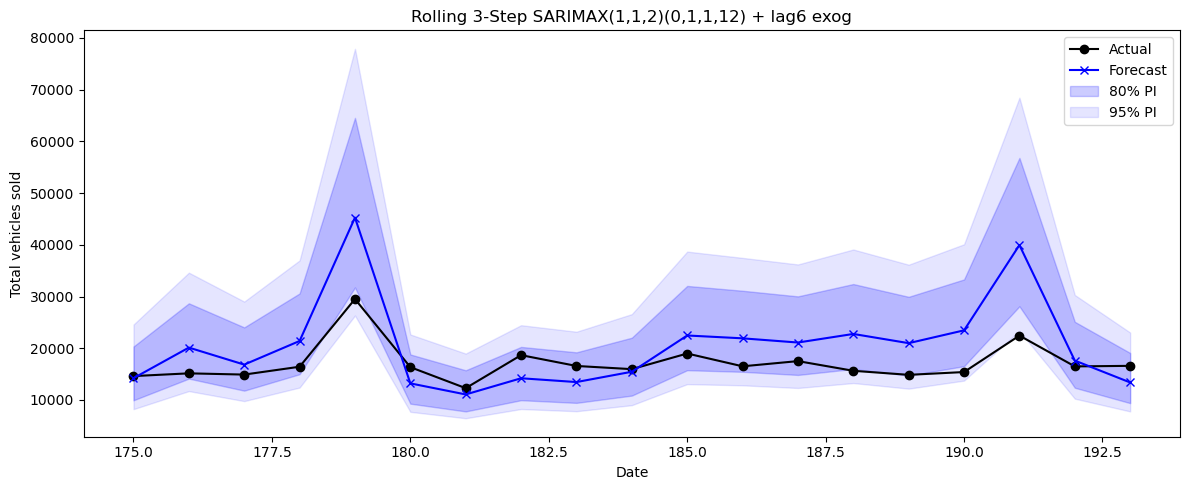

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


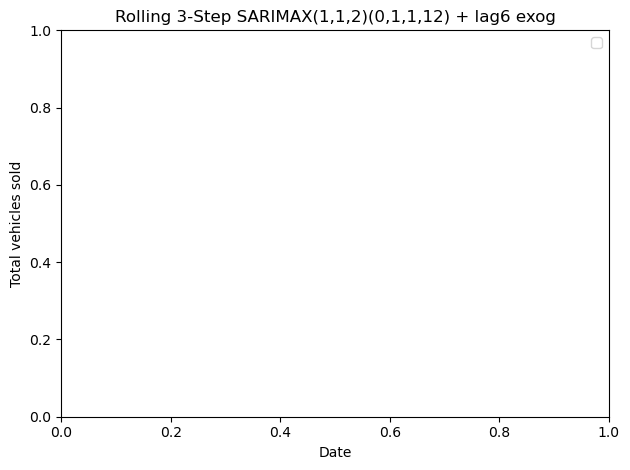

In [ ]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# 1) Warning filters
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# 2) Settings & Data
target_col = 'Total vehicles sold (Target)' 
gas_col    = 'Gasoline (Euro95) - Average price (F)'
# lambda for inverting Yeo–Johnson on the target
lam_target = yeojohnson_lambdas_all[target_col]

# our Yeo–Johnson–transformed level series
yj = yj_df[[target_col, gas_col]].copy()

# 3) Train/validation split indices
n = len(yj)
train_end = int(n * 0.80)
val_end   = train_end + int(n * 0.10)

train_y = yj[target_col].iloc[:train_end]
val_y   = yj[target_col].iloc[train_end:val_end]

# 4) Build the lag-6 exog feature (on the diff of gasoline price)
x_diff     = yj[gas_col].diff()
exog_lag_6 = x_diff.shift(6)

# Align exog with train/val, and drop NaNs from both y and exog for training
train_exog6 = exog_lag_6.iloc[:train_end]
val_exog6   = exog_lag_6.iloc[train_end:val_end]

# Drop NaNs in training data (from diff/shift)
train_mask = (~train_y.isna()) & (~train_exog6.isna())
train_y = train_y[train_mask]
train_exog6 = train_exog6[train_mask]

# 5) Define inverse Yeo–Johnson for target
def inv_yj(x, lam):
    # x: scalar or array of YJ-transformed values
    if lam == 0:
        return np.exp(x)
    elif lam == 2:
        return -np.exp(-x)
    pos = x >= 0
    out = np.empty_like(x, dtype=float)
    out[pos]  = (x[pos] * lam + 1)**(1/lam) - 1
    out[~pos] = 1 - (-(x[~pos])*(2-lam) + 1)**(1/(2-lam))
    return out

# 6) Rolling-origin forecast with horizon=3
horizon = 3

history_y     = list(train_y)
history_exog  = list(train_exog6)
val_vals      = val_y.values

# Initialize lists for prediction intervals
preds_level  = []
ci80_lower = []
ci80_upper = []
ci95_lower = []
ci95_upper = []

for t in range(len(val_vals) - horizon + 1):
    # Remove any NaNs from history (should only be at the start)
    y_arr = np.array(history_y)
    exog_arr = np.array(history_exog)
    valid_idx = (~np.isnan(y_arr)) & (~np.isnan(exog_arr))
    y_arr = y_arr[valid_idx]
    exog_arr = exog_arr[valid_idx].reshape(-1, 1)

    # Fit SARIMAX on history (with exog = lag6)
    mod = SARIMAX(
        y_arr,
        exog=exog_arr,
        order=(1, 1, 2),
        seasonal_order=(0, 1, 1, 12),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    res = mod.fit(disp=False)

    # Prepare exog for the next 3 steps
    exog_future = val_exog6.iloc[t : t+horizon].values.reshape(-1,1)
    # Remove any NaNs in exog_future (should not happen, but just in case)
    if np.isnan(exog_future).any():
        # Skip this iteration if future exog has NaNs
        continue

    # Multi-step forecast
    fc = res.get_forecast(steps=horizon, exog=exog_future)

    # Take the last horizon-step point
    yj_forecast_level = fc.predicted_mean[-1]

    # Invert to original scale and store
    preds_level.append(inv_yj(np.array([yj_forecast_level]), lam_target)[0])

    # Store prediction intervals (last step)
    ci80, ci80_u = fc.conf_int(alpha=0.20)[-1]
    ci95, ci95_u = fc.conf_int(alpha=0.05)[-1]

    ci80_lower.append(inv_yj(np.array([ci80]), lam_target)[0])
    ci80_upper.append(inv_yj(np.array([ci80_u]), lam_target)[0])
    ci95_lower.append(inv_yj(np.array([ci95]), lam_target)[0])
    ci95_upper.append(inv_yj(np.array([ci95_u]), lam_target)[0])

    # Roll the window forward by one observation
    history_y.append(val_vals[t])
    history_exog.append(val_exog6.iloc[t])

# 7) Align actuals on original scale (drop the first horizon−1)
# Make sure all arrays/lists are the same length (number of successful predictions)
n_preds = len(preds_level)
actuals_level = inv_yj(val_vals[horizon-1:horizon-1+n_preds], lam_target)
ci80_lower = np.array(ci80_lower)
ci80_upper = np.array(ci80_upper)
ci95_lower = np.array(ci95_lower)
ci95_upper = np.array(ci95_upper)

# 8) Compute metrics
# 9) Plot
dates = yj_df.index[train_end + horizon - 1 : train_end + horizon - 1 + n_preds]

plt.figure(figsize=(12,5))
plt.plot(dates, actuals_level,  marker='o', color='black', label='Actual')
plt.plot(dates, preds_level,    marker='x', color='blue',  label='Forecast')
plt.fill_between(dates, ci80_lower, ci80_upper, color='blue', alpha=0.2, label='80% PI')
plt.fill_between(dates, ci95_lower, ci95_upper, color='blue', alpha=0.1, label='95% PI')
plt.title(f'Rolling {horizon}-Step SARIMAX(1,1,2)(0,1,1,12) + lag6 exog')
plt.xlabel('Date')
plt.ylabel('Total vehicles sold')
plt.legend()
plt.tight_layout()
plt.show()
plt.title(f'Rolling {horizon}-Step SARIMAX(1,1,2)(0,1,1,12) + lag6 exog')
plt.xlabel('Date')
plt.ylabel('Total vehicles sold')
plt.legend()
plt.tight_layout()
plt.show()


> Target only

> target only testset

Rolling 3-step RMSE: 3620.26
Rolling 3-step MAPE: 17.17%


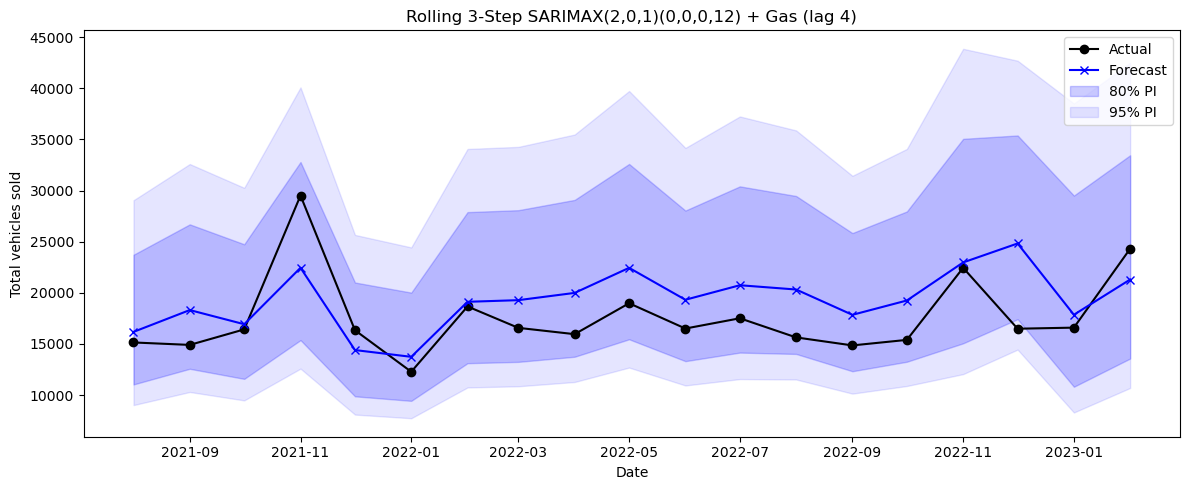

## 7b Company car tax rate (%)

### Lag Selection

Optimal lags sorted by AIC:
Lag: 3, AIC: 121.97, BIC: 128.22
Lag: 6, AIC: 122.87, BIC: 129.08
Lag: 4, AIC: 123.14, BIC: 129.37
Lag: 5, AIC: 123.54, BIC: 129.77
Lag: 2, AIC: 124.15, BIC: 130.41
Lag: 1, AIC: 127.14, BIC: 133.42

Optimal lags sorted by BIC:
Lag: 3, AIC: 121.97, BIC: 128.22
Lag: 6, AIC: 122.87, BIC: 129.08
Lag: 4, AIC: 123.14, BIC: 129.37
Lag: 5, AIC: 123.54, BIC: 129.77
Lag: 2, AIC: 124.15, BIC: 130.41
Lag: 1, AIC: 127.14, BIC: 133.42


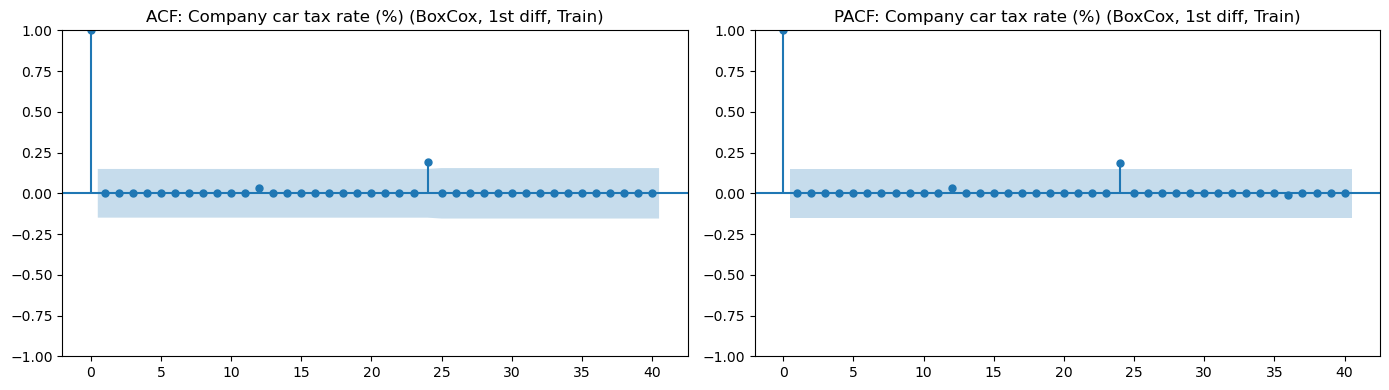

In [ ]:

# Prepare exogenous variable: use BoxCox-transformed, 1st-differenced train split for 'Company car tax rate (%)'
exog_feature = diff_results['Company car tax rate (%)']
target_diff = diff_results[target]

# Try lags 1 to 6 for exogenous variable
max_lag = 6
aic_bic_results = []

for lag in range(1, max_lag + 1):
    # Lag exogenous variable (align with target_diff)
    exog_lagged = np.roll(exog_feature, lag)
    exog_lagged[:lag] = np.nan  # first 'lag' values are invalid
    valid_idx = ~np.isnan(exog_lagged)
    y_valid = target_diff[valid_idx]
    exog_valid = exog_lagged[valid_idx].reshape(-1, 1)
    
    # Fit SARIMAX (ARIMA(0,0,0) since already differenced, no AR/MA terms)
    model = sm.tsa.SARIMAX(
        y_valid,
        order=(0, 0, 0),
        exog=exog_valid,
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    res = model.fit(disp=False)
    aic_bic_results.append({
        'lag': lag,
        'AIC': res.aic,
        'BIC': res.bic
    })

# Sort by AIC and BIC
aic_sorted = sorted(aic_bic_results, key=lambda x: x['AIC'])
bic_sorted = sorted(aic_bic_results, key=lambda x: x['BIC'])

print("Optimal lags sorted by AIC:")
for r in aic_sorted:
    print(f"Lag: {r['lag']}, AIC: {r['AIC']:.2f}, BIC: {r['BIC']:.2f}")

print("\nOptimal lags sorted by BIC:")
for r in bic_sorted:
    print(f"Lag: {r['lag']}, AIC: {r['AIC']:.2f}, BIC: {r['BIC']:.2f}")

    # Plot ACF and PACF for the BoxCox-transformed, 1st-differenced Company car tax rate (train split)
car_tax_bc_diff = exog_feature

plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plot_acf(car_tax_bc_diff, ax=plt.gca(), lags=40)
plt.title('ACF: Company car tax rate (%) (BoxCox, 1st diff, Train)')

plt.subplot(1, 2, 2)
plot_pacf(car_tax_bc_diff, ax=plt.gca(), lags=40, method='ywm')
plt.title('PACF: Company car tax rate (%) (BoxCox, 1st diff, Train)')

plt.tight_layout()
plt.show()

### Fit Sarimax and diagnose 

Rolling 3-step RMSE: 3734.08
Rolling 3-step MAPE: 18.90%


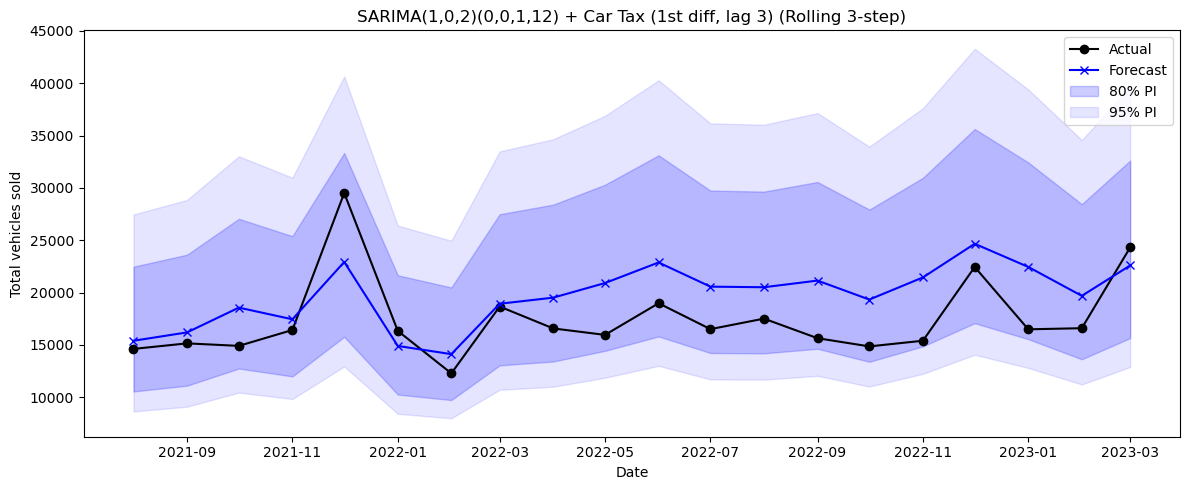

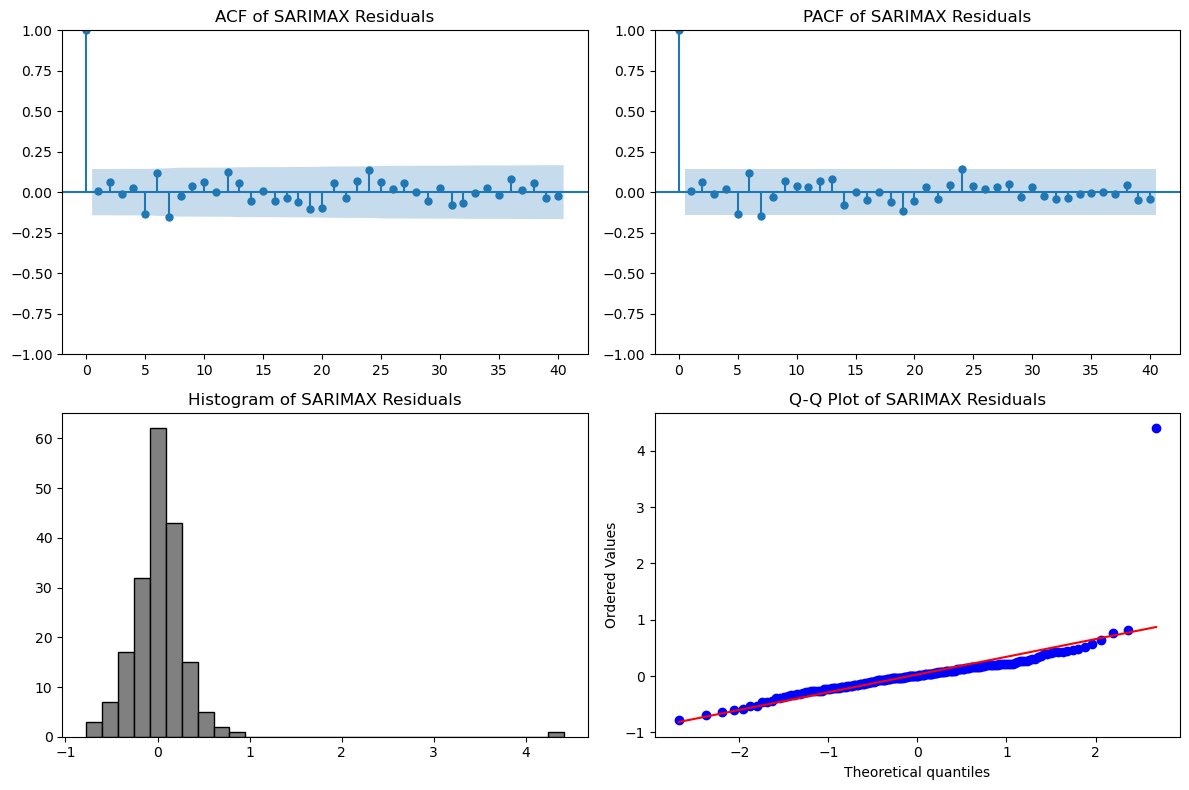

Ljung-Box test p-values (no autocorrelation if > 0.05):
      lb_stat  lb_pvalue
10  12.800826   0.235022
20  23.379647   0.270540
30  32.180506   0.359180


In [ ]:
warnings.filterwarnings("ignore", category=ValueWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# ─── 1. Prepare data ───────────────────────────────────────────────────────────
car_tax_bc_raw = boxcox_all['Company car tax rate (%)']
car_tax_bc = np.diff(car_tax_bc_raw)  # FIRST DIFFERENCE
target_bc  = boxcox_all[target]

# Adjust indices for differencing
history_y   = list(target_bc[1:train_end])         # align with diffed car_tax_bc
history_tax = list(car_tax_bc[:train_end-1])

val_y   = target_bc[train_end:val_end]
val_tax = car_tax_bc[train_end-1:val_end-1]

horizon = 3
lag     = 3  # chosen exogenous lag

predictions_bc = []
conf_int_80    = []
conf_int_95    = []

# ─── 2. Rolling loop ────────────────────────────────────────────────────────────
for t in range(len(val_y) - horizon + 1):
    # 2a) Build a DataFrame of history + lagged car tax
    df_hist = pd.DataFrame({
        'y': history_y,
        'tax': history_tax
    })
    df_hist['tax_lag3'] = df_hist['tax'].shift(lag)
    df_hist = df_hist.dropna()

    y_hist    = df_hist['y']
    exog_hist = df_hist['tax_lag3'].values.reshape(-1, 1)

    # 2b) Fit SARIMAX on history
    model = SARIMAX(
        y_hist,
        exog=exog_hist,
        order=(1, 0, 2),
        seasonal_order=(0, 0, 1, 12),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    fitted = model.fit(disp=False)

    # 2c) Construct future exogenous inputs **only** from history_tax
    tax_future_lags = [
        history_tax[-lag + (i+1)]
        for i in range(horizon)
    ]
    exog_future = np.array(tax_future_lags).reshape(horizon, 1)

    # 2d) Multi-step forecast with exog
    fc = fitted.get_forecast(steps=horizon, exog=exog_future)

    # pull out the 3rd step’s point forecast + intervals
    yhat      = fc.predicted_mean.iloc[-1]
    ci80, ci80_u = fc.conf_int(alpha=0.20).iloc[-1].values
    ci95, ci95_u = fc.conf_int(alpha=0.05).iloc[-1].values

    predictions_bc.append(yhat)
    conf_int_80.append((ci80, ci80_u))
    conf_int_95.append((ci95, ci95_u))

    # 2e) Now that we’ve “observed” time t, append the actuals to history
    history_y.append(val_y[t])
    history_tax.append(val_tax[t])

# ─── 3. Invert Box–Cox & compute metrics ────────────────────────────────────────
lam, shift = boxcox_lambdas_all[target]
def inv_boxcox(y, lam):
    return np.exp(y) if lam == 0 else np.power(lam * y + 1, 1/lam)

pred_bc = np.array(predictions_bc)
pred_orig  = inv_boxcox(pred_bc, lam) - shift
actuals    = y_val.values[horizon-1:]

# intervals
ci80_arr = np.array(conf_int_80)
ci95_arr = np.array(conf_int_95)

ci80_lower = inv_boxcox(ci80_arr[:,0], lam) - shift
ci80_upper = inv_boxcox(ci80_arr[:,1], lam) - shift
ci95_lower = inv_boxcox(ci95_arr[:,0], lam) - shift
ci95_upper = inv_boxcox(ci95_arr[:,1], lam) - shift

# metrics
rmse = np.sqrt(mean_squared_error(actuals, pred_orig))
mape = mean_absolute_percentage_error(actuals, pred_orig)

print(f"Rolling 3-step RMSE: {rmse:.2f}")
print(f"Rolling 3-step MAPE: {mape:.2%}")

# ─── 4. Plot results ────────────────────────────────────────────────────────────
x_dates = df["Time Period (T)"][train_end+horizon-1:val_end]

plt.figure(figsize=(12,5))
plt.plot(x_dates, actuals, marker='o', color='black', label='Actual')
plt.plot(x_dates, pred_orig, marker='x', color='blue', label='Forecast')
plt.fill_between(x_dates, ci80_lower, ci80_upper, color='blue', alpha=0.2, label='80% PI')
plt.fill_between(x_dates, ci95_lower, ci95_upper, color='blue', alpha=0.1, label='95% PI')
plt.title('SARIMA(1,0,2)(0,0,1,12) + Car Tax (1st diff, lag 3) (Rolling 3-step)')
plt.xlabel('Date')
plt.ylabel('Total vehicles sold')
plt.legend()
plt.tight_layout()
plt.show()

# ─── 5. Residual diagnostics ────────────────────────────────────────────────────

# Get residuals from the last fitted SARIMAX model in the rolling loop
residuals = fitted.resid

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# ACF plot
plot_acf(residuals, ax=axes[0, 0], lags=40)
axes[0, 0].set_title("ACF of SARIMAX Residuals")

# PACF plot
plot_pacf(residuals, ax=axes[0, 1], lags=40, method='ywm')
axes[0, 1].set_title("PACF of SARIMAX Residuals")

# Histogram
axes[1, 0].hist(residuals, bins=30, color='gray', edgecolor='black')
axes[1, 0].set_title("Histogram of SARIMAX Residuals")

# Q-Q plot
stats.probplot(residuals, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title("Q-Q Plot of SARIMAX Residuals")

plt.tight_layout()
plt.show()

# Ljung-Box test for autocorrelation (white noise)
lb_test = acorr_ljungbox(residuals, lags=[10, 20, 30], return_df=True)
print("Ljung-Box test p-values (no autocorrelation if > 0.05):")
print(lb_test[['lb_stat', 'lb_pvalue']])

Rolling 3-step RMSE: 3756.22
Rolling 3-step MAPE: 19.13%


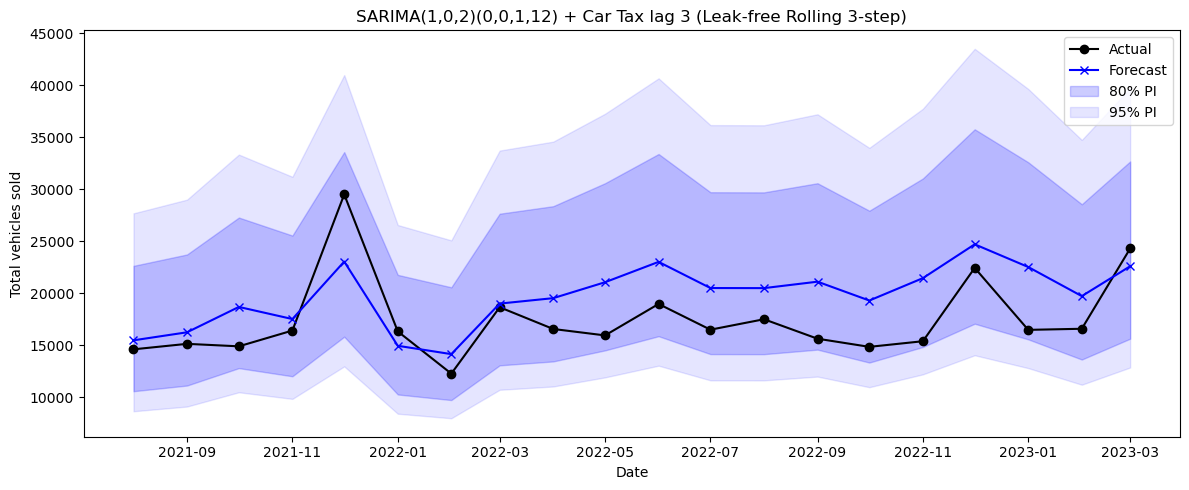

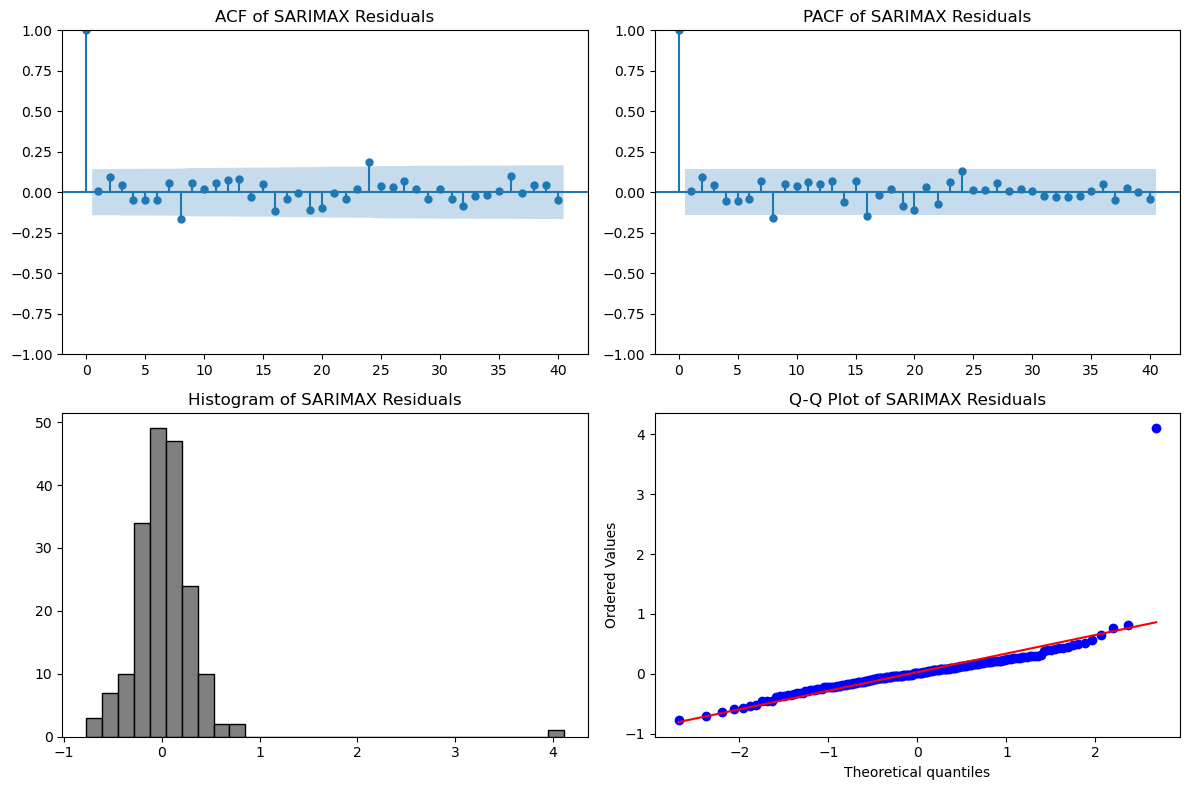

Ljung-Box test p-values (no autocorrelation if > 0.05):
      lb_stat  lb_pvalue
10  10.348455   0.410472
20  22.155801   0.332117
30  32.289264   0.354198


In [ ]:
# warnings.filterwarnings("ignore", category=ValueWarning)
# warnings.filterwarnings("ignore", category=ConvergenceWarning)
# warnings.filterwarnings("ignore", category=FutureWarning)

# # ─── 1. Prepare data ───────────────────────────────────────────────────────────
# car_tax_bc = boxcox_all['Company car tax rate (%)']
# target_bc  = boxcox_all[target]

# history_y   = list(target_bc[:train_end])
# history_tax = list(car_tax_bc[:train_end])

# val_y   = target_bc[train_end:val_end]
# val_tax = car_tax_bc[train_end:val_end]

# horizon = 3
# lag     = 3  # chosen exogenous lag

# predictions_bc = []
# conf_int_80    = []
# conf_int_95    = []

# # ─── 2. Rolling loop ────────────────────────────────────────────────────────────
# for t in range(len(val_y) - horizon + 1):
#     # 2a) Build a DataFrame of history + lagged car tax
#     df_hist = pd.DataFrame({
#         'y': history_y,
#         'tax': history_tax
#     })
#     df_hist['tax_lag3'] = df_hist['tax'].shift(lag)
#     df_hist = df_hist.dropna()

#     y_hist    = df_hist['y']
#     exog_hist = df_hist['tax_lag3'].values.reshape(-1, 1)

#     # 2b) Fit SARIMAX on history
#     model = SARIMAX(
#         y_hist,
#         exog=exog_hist,
#         order=(1, 0, 2),
#         seasonal_order=(0, 0, 1, 12),
#         enforce_stationarity=False,
#         enforce_invertibility=False
#     )
#     fitted = model.fit(disp=False)

#     # 2c) Construct future exogenous inputs **only** from history_tax
#     tax_future_lags = [
#         history_tax[-lag + (i+1)]
#         for i in range(horizon)
#     ]
#     exog_future = np.array(tax_future_lags).reshape(horizon, 1)

#     # 2d) Multi-step forecast with exog
#     fc = fitted.get_forecast(steps=horizon, exog=exog_future)

#     # pull out the 3rd step’s point forecast + intervals
#     yhat      = fc.predicted_mean.iloc[-1]
#     ci80, ci80_u = fc.conf_int(alpha=0.20).iloc[-1].values
#     ci95, ci95_u = fc.conf_int(alpha=0.05).iloc[-1].values

#     predictions_bc.append(yhat)
#     conf_int_80.append((ci80, ci80_u))
#     conf_int_95.append((ci95, ci95_u))

#     # 2e) Now that we’ve “observed” time t, append the actuals to history
#     history_y.append(val_y[t])
#     history_tax.append(val_tax[t])

# # ─── 3. Invert Box–Cox & compute metrics ────────────────────────────────────────
# lam, shift = boxcox_lambdas_all[target]
# def inv_boxcox(y, lam):
#     return np.exp(y) if lam == 0 else np.power(lam * y + 1, 1/lam)

# pred_bc = np.array(predictions_bc)
# pred_orig  = inv_boxcox(pred_bc, lam) - shift
# actuals    = y_val.values[horizon-1:]

# # intervals
# ci80_arr = np.array(conf_int_80)
# ci95_arr = np.array(conf_int_95)

# ci80_lower = inv_boxcox(ci80_arr[:,0], lam) - shift
# ci80_upper = inv_boxcox(ci80_arr[:,1], lam) - shift
# ci95_lower = inv_boxcox(ci95_arr[:,0], lam) - shift
# ci95_upper = inv_boxcox(ci95_arr[:,1], lam) - shift

# # metrics
# rmse = np.sqrt(mean_squared_error(actuals, pred_orig))
# mape = mean_absolute_percentage_error(actuals, pred_orig)

# print(f"Rolling 3-step RMSE: {rmse:.2f}")
# print(f"Rolling 3-step MAPE: {mape:.2%}")

# # ─── 4. Plot results ────────────────────────────────────────────────────────────
# x_dates = df["Time Period (T)"][train_end+horizon-1:val_end]

# plt.figure(figsize=(12,5))
# plt.plot(x_dates, actuals, marker='o', color='black', label='Actual')
# plt.plot(x_dates, pred_orig, marker='x', color='blue', label='Forecast')
# plt.fill_between(x_dates, ci80_lower, ci80_upper, color='blue', alpha=0.2, label='80% PI')
# plt.fill_between(x_dates, ci95_lower, ci95_upper, color='blue', alpha=0.1, label='95% PI')
# plt.title('SARIMA(1,0,2)(0,0,1,12) + Car Tax lag 3 (Leak-free Rolling 3-step)')
# plt.xlabel('Date')
# plt.ylabel('Total vehicles sold')
# plt.legend()
# plt.tight_layout()
# plt.show()

# # ─── 5. Residual diagnostics ────────────────────────────────────────────────────


# # Get residuals from the last fitted SARIMAX model in the rolling loop
# residuals = fitted.resid

# fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# # ACF plot
# plot_acf(residuals, ax=axes[0, 0], lags=40)
# axes[0, 0].set_title("ACF of SARIMAX Residuals")

# # PACF plot
# plot_pacf(residuals, ax=axes[0, 1], lags=40, method='ywm')
# axes[0, 1].set_title("PACF of SARIMAX Residuals")

# # Histogram
# axes[1, 0].hist(residuals, bins=30, color='gray', edgecolor='black')
# axes[1, 0].set_title("Histogram of SARIMAX Residuals")

# # Q-Q plot
# stats.probplot(residuals, dist="norm", plot=axes[1, 1])
# axes[1, 1].set_title("Q-Q Plot of SARIMAX Residuals")

# plt.tight_layout()
# plt.show()

# # Ljung-Box test for autocorrelation (white noise)
# lb_test = acorr_ljungbox(residuals, lags=[10, 20, 30], return_df=True)
# print("Ljung-Box test p-values (no autocorrelation if > 0.05):")
# print(lb_test[['lb_stat', 'lb_pvalue']])

## 7c Google Home Charging

### Lag Selection

Optimal lags for Home charging (G) sorted by AIC:
Lag: 5, AIC: 120.82, BIC: 127.04
Lag: 4, AIC: 121.93, BIC: 128.17
Lag: 3, AIC: 123.11, BIC: 129.36
Lag: 6, AIC: 123.32, BIC: 129.54
Lag: 2, AIC: 124.16, BIC: 130.42
Lag: 1, AIC: 126.97, BIC: 133.25

Optimal lags for Home charging (G) sorted by BIC:
Lag: 5, AIC: 120.82, BIC: 127.04
Lag: 4, AIC: 121.93, BIC: 128.17
Lag: 3, AIC: 123.11, BIC: 129.36
Lag: 6, AIC: 123.32, BIC: 129.54
Lag: 2, AIC: 124.16, BIC: 130.42
Lag: 1, AIC: 126.97, BIC: 133.25


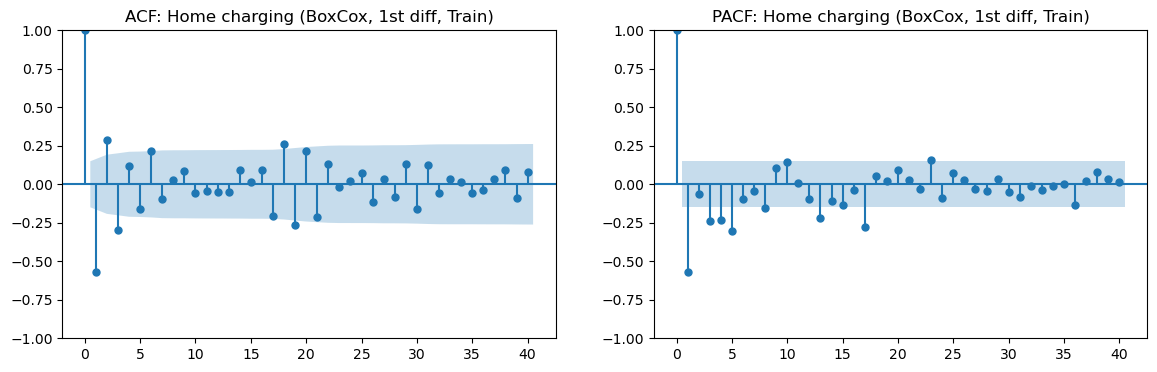

In [ ]:


# Use BoxCox-transformed, 1st-differenced train split for 'Home charging (G)'
exog_feature = diff_results['Home charging (G)']
target_diff = diff_results[target]

# Try lags 1 to 6 for exogenous variable
max_lag = 6

aic_bic_results_homechg = []

for lag in range(1, max_lag + 1):
    # Lag exogenous variable (align with target_diff)
    exog_lagged = np.roll(exog_feature, lag)
    exog_lagged[:lag] = np.nan  # first 'lag' values are invalid
    valid_idx = ~np.isnan(exog_lagged)
    y_valid = target_diff[valid_idx]
    exog_valid = exog_lagged[valid_idx].reshape(-1, 1)
    
    # Fit SARIMAX (ARIMA(0,0,0) since already differenced, no AR/MA terms)
    model = sm.tsa.SARIMAX(
        y_valid,
        order=(0, 0, 0),
        exog=exog_valid,
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    res = model.fit(disp=False)
    aic_bic_results_homechg.append({
        'lag': lag,
        'AIC': res.aic,
        'BIC': res.bic
    })

# Sort by AIC and BIC
aic_sorted_homechg = sorted(aic_bic_results_homechg, key=lambda x: x['AIC'])
bic_sorted_homechg = sorted(aic_bic_results_homechg, key=lambda x: x['BIC'])

print("Optimal lags for Home charging (G) sorted by AIC:")
for r in aic_sorted_homechg:
    print(f"Lag: {r['lag']}, AIC: {r['AIC']:.2f}, BIC: {r['BIC']:.2f}")

print("\nOptimal lags for Home charging (G) sorted by BIC:")
for r in bic_sorted_homechg:
    print(f"Lag: {r['lag']}, AIC: {r['AIC']:.2f}, BIC: {r['BIC']:.2f}")

    # Plot ACF and PACF for the BoxCox-transformed, 1st-differenced Home charging (train split)
    homechg_bc_diff = exog_feature

plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plot_acf(homechg_bc_diff, ax=plt.gca(), lags=40)
plt.title('ACF: Home charging (BoxCox, 1st diff, Train)')

plt.subplot(1, 2, 2)
plot_pacf(homechg_bc_diff, ax=plt.gca(), lags=40, method='ywm')
plt.title('PACF: Home charging (BoxCox, 1st diff, Train)')

plt.show()

### Fit Sarimax and diagnose 

Rolling 3-step RMSE: 3711.92
Rolling 3-step MAPE: 18.84%


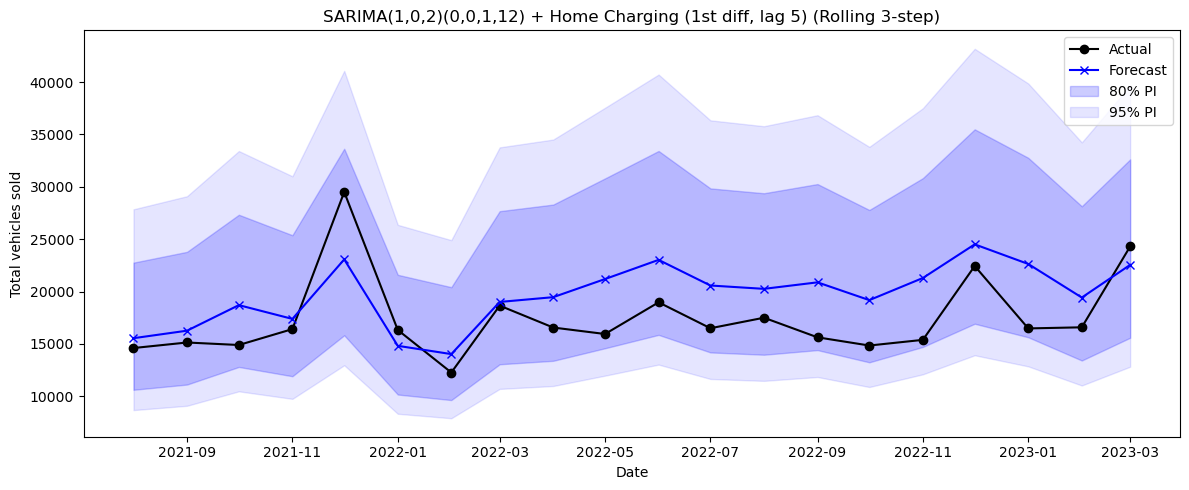

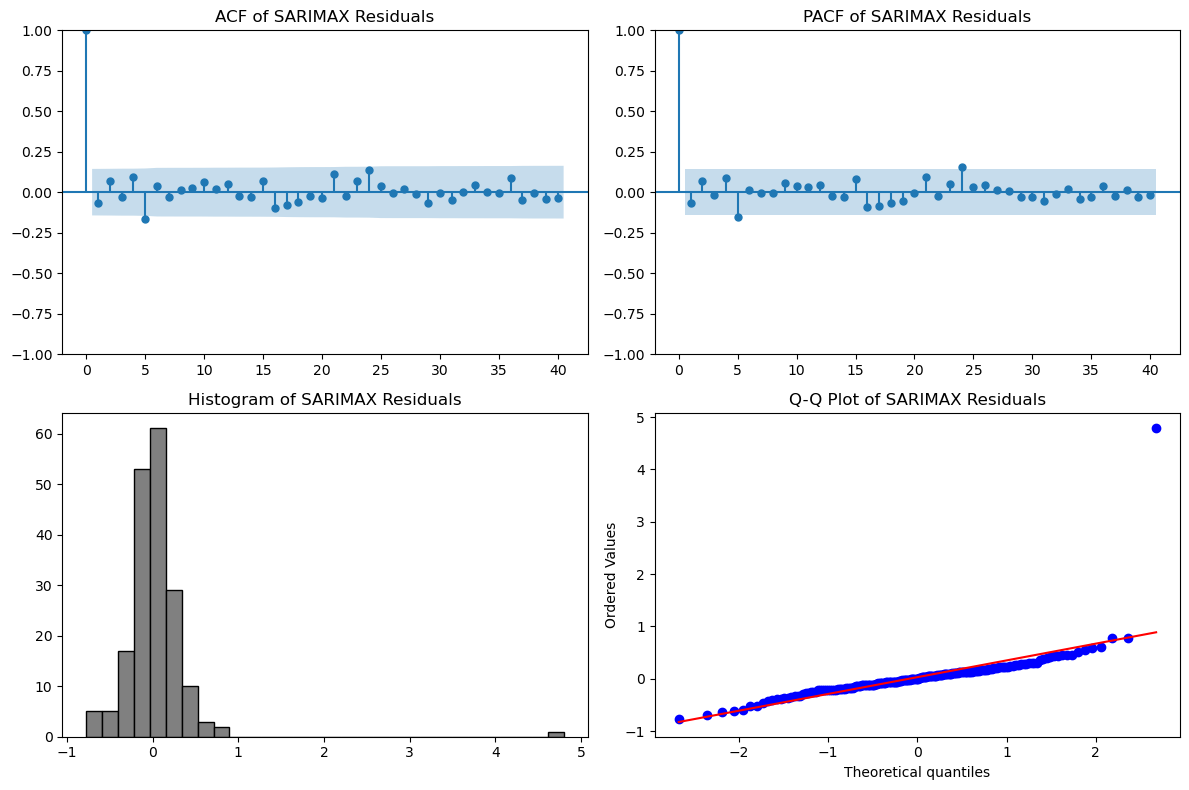

Ljung-Box test p-values (no autocorrelation if > 0.05):
      lb_stat  lb_pvalue
10  10.323041   0.412624
20  16.547528   0.682129
30  25.919836   0.679217


In [ ]:
### 3 step (, like gasoline/car tax)

warnings.filterwarnings("ignore", category=ValueWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
# ─── 1. Prepare data ───────────────────────────────────────────────────────────
homechg_bc_raw = boxcox_all['Home charging (G)']
homechg_bc = np.diff(homechg_bc_raw)  # FIRST DIFFERENCE
target_bc  = boxcox_all[target]

# Adjust indices for differencing
history_y        = list(target_bc[1:train_end])         # align with diffed homechg_bc
history_homechg  = list(homechg_bc[:train_end-1])

val_y        = target_bc[train_end:val_end]
val_homechg  = homechg_bc[train_end-1:val_end-1]

horizon = 3
lag     = 5  # chosen exogenous lag

predictions_bc = []
conf_int_80    = []
conf_int_95    = []

# ─── 2. Rolling loop ────────────────────────────────────────────────────────────
for t in range(len(val_y) - horizon + 1):
    # 2a) Build a DataFrame of history + lagged home charging
    df_hist = pd.DataFrame({
        'y': history_y,
        'homechg': history_homechg
    })
    df_hist['homechg_lag5'] = df_hist['homechg'].shift(lag)
    df_hist = df_hist.dropna()

    y_hist    = df_hist['y']
    exog_hist = df_hist['homechg_lag5'].values.reshape(-1, 1)

    # 2b) Fit SARIMAX on history
    model = SARIMAX(
        y_hist,
        exog=exog_hist,
        order=(1, 0, 2),
        seasonal_order=(0, 0, 1, 12),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    fitted = model.fit(disp=False)

    # 2c) Construct future exogenous inputs **only** from history_homechg
    homechg_future_lags = [
        history_homechg[-lag + (i+1)]
        for i in range(horizon)
    ]
    exog_future = np.array(homechg_future_lags).reshape(horizon, 1)

    # 2d) Multi-step forecast with exog
    fc = fitted.get_forecast(steps=horizon, exog=exog_future)

    # pull out the 3rd step’s point forecast + intervals
    yhat      = fc.predicted_mean.iloc[-1]
    ci80, ci80_u = fc.conf_int(alpha=0.20).iloc[-1].values
    ci95, ci95_u = fc.conf_int(alpha=0.05).iloc[-1].values

    predictions_bc.append(yhat)
    conf_int_80.append((ci80, ci80_u))
    conf_int_95.append((ci95, ci95_u))

    # 2e) Now that we’ve “observed” time t, append the actuals to history
    history_y.append(val_y[t])
    history_homechg.append(val_homechg[t])

# ─── 3. Invert Box–Cox & compute metrics ────────────────────────────────────────
lam, shift = boxcox_lambdas_all[target]
def inv_boxcox(y, lam):
    return np.exp(y) if lam == 0 else np.power(lam * y + 1, 1/lam)

pred_bc = np.array(predictions_bc)
pred_orig  = inv_boxcox(pred_bc, lam) - shift
actuals    = y_val.values[horizon-1:]

# intervals
ci80_arr = np.array(conf_int_80)
ci95_arr = np.array(conf_int_95)

ci80_lower = inv_boxcox(ci80_arr[:,0], lam) - shift
ci80_upper = inv_boxcox(ci80_arr[:,1], lam) - shift
ci95_lower = inv_boxcox(ci95_arr[:,0], lam) - shift
ci95_upper = inv_boxcox(ci95_arr[:,1], lam) - shift

# metrics
rmse = np.sqrt(mean_squared_error(actuals, pred_orig))
mape = mean_absolute_percentage_error(actuals, pred_orig)

print(f"Rolling 3-step RMSE: {rmse:.2f}")
print(f"Rolling 3-step MAPE: {mape:.2%}")

# ─── 4. Plot results ────────────────────────────────────────────────────────────
x_dates = df["Time Period (T)"][train_end+horizon-1:val_end]

plt.figure(figsize=(12,5))
plt.plot(x_dates, actuals, marker='o', color='black', label='Actual')
plt.plot(x_dates, pred_orig, marker='x', color='blue', label='Forecast')
plt.fill_between(x_dates, ci80_lower, ci80_upper, color='blue', alpha=0.2, label='80% PI')
plt.fill_between(x_dates, ci95_lower, ci95_upper, color='blue', alpha=0.1, label='95% PI')
plt.title('SARIMA(1,0,2)(0,0,1,12) + Home Charging (1st diff, lag 5) (Rolling 3-step)')
plt.xlabel('Date')
plt.ylabel('Total vehicles sold')
plt.legend()
plt.tight_layout()
plt.show()

# ─── 5. Residual diagnostics ────────────────────────────────────────────────────

# Get residuals from the last fitted SARIMAX model in the rolling loop
residuals = fitted.resid

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# ACF plot
plot_acf(residuals, ax=axes[0, 0], lags=40)
axes[0, 0].set_title("ACF of SARIMAX Residuals")

# PACF plot
plot_pacf(residuals, ax=axes[0, 1], lags=40, method='ywm')
axes[0, 1].set_title("PACF of SARIMAX Residuals")

# Histogram
axes[1, 0].hist(residuals, bins=30, color='gray', edgecolor='black')
axes[1, 0].set_title("Histogram of SARIMAX Residuals")

# Q-Q plot
stats.probplot(residuals, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title("Q-Q Plot of SARIMAX Residuals")

plt.tight_layout()
plt.show()

# Ljung-Box test for autocorrelation (white noise)
lb_test = acorr_ljungbox(residuals, lags=[10, 20, 30], return_df=True)
print("Ljung-Box test p-values (no autocorrelation if > 0.05):")
print(lb_test[['lb_stat', 'lb_pvalue']])

Rolling 3-step RMSE: 3708.38
Rolling 3-step MAPE: 18.40%


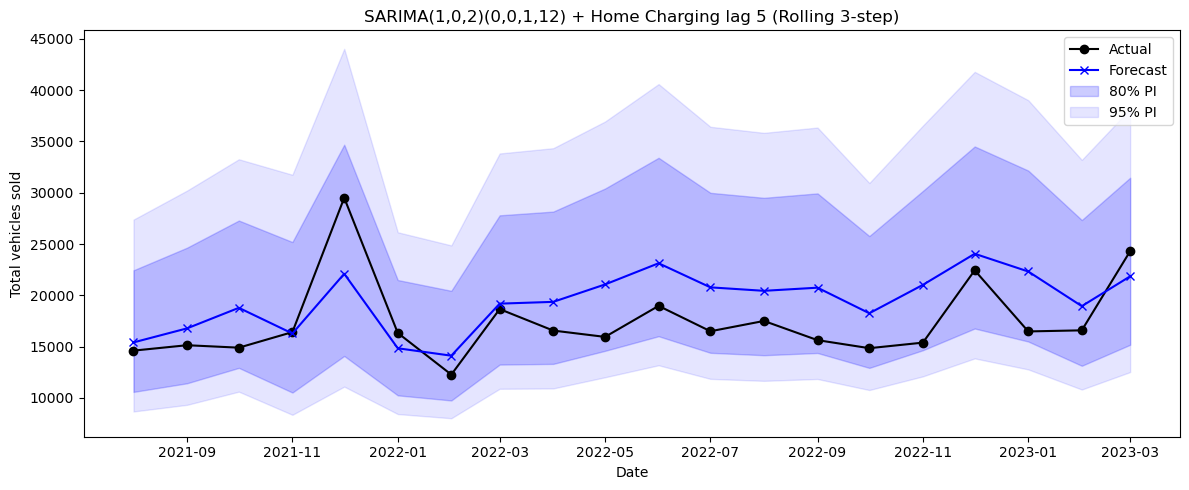

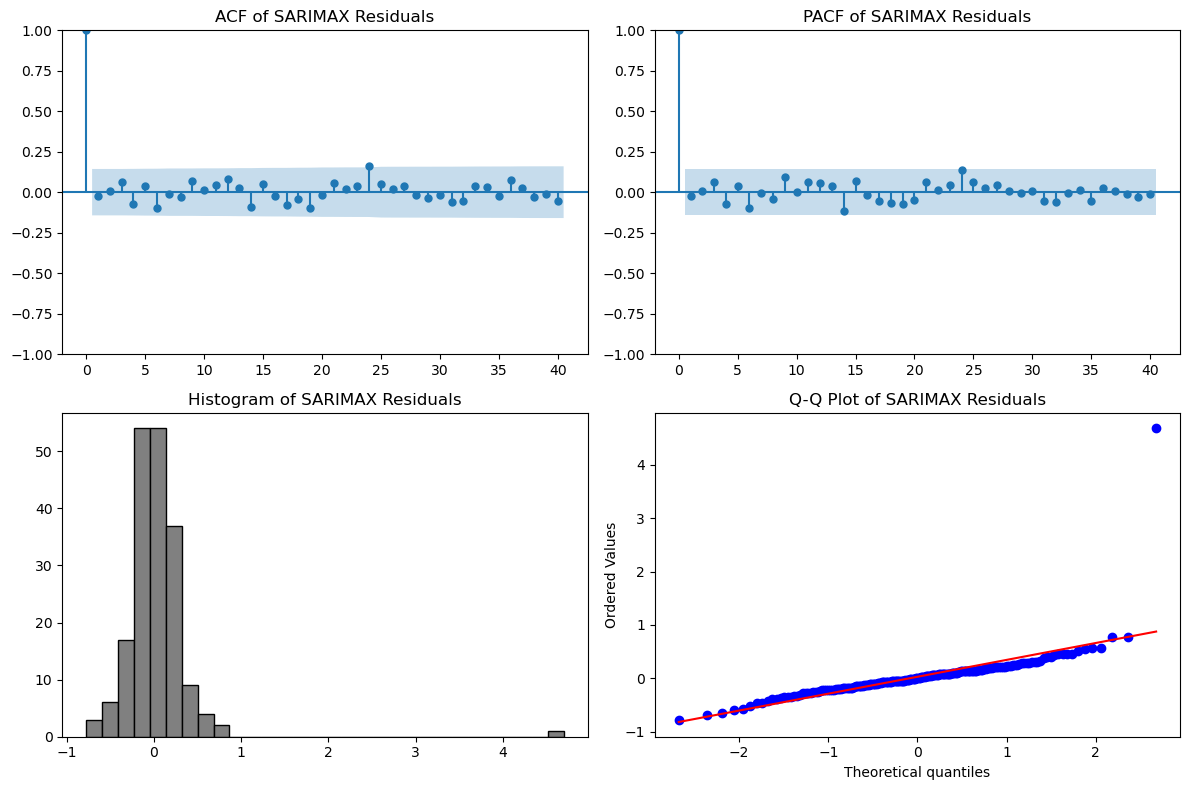

Ljung-Box test p-values (no autocorrelation if > 0.05):
      lb_stat  lb_pvalue
10   5.407992   0.862313
20  13.637585   0.848386
30  21.668346   0.865833


In [ ]:
# ### 3 step (, like gasoline/car tax)

# warnings.filterwarnings("ignore", category=ValueWarning)
# warnings.filterwarnings("ignore", category=ConvergenceWarning)
# warnings.filterwarnings("ignore", category=FutureWarning)
# # ─── 1. Prepare data ───────────────────────────────────────────────────────────
# homechg_bc = boxcox_all['Home charging (G)']
# target_bc  = boxcox_all[target]

# history_y      = list(target_bc[:train_end])
# history_homechg = list(homechg_bc[:train_end])

# val_y      = target_bc[train_end:val_end]
# val_homechg = homechg_bc[train_end:val_end]

# horizon = 3
# lag     = 5  # chosen exogenous lag

# predictions_bc = []
# conf_int_80    = []
# conf_int_95    = []

# # ─── 2. Rolling loop ────────────────────────────────────────────────────────────
# for t in range(len(val_y) - horizon + 1):
#     # 2a) Build a DataFrame of history + lagged home charging
#     df_hist = pd.DataFrame({
#         'y': history_y,
#         'homechg': history_homechg
#     })
#     df_hist['homechg_lag5'] = df_hist['homechg'].shift(lag)
#     df_hist = df_hist.dropna()

#     y_hist    = df_hist['y']
#     exog_hist = df_hist['homechg_lag5'].values.reshape(-1, 1)

#     # 2b) Fit SARIMAX on history
#     model = SARIMAX(
#         y_hist,
#         exog=exog_hist,
#         order=(1, 0, 2),
#         seasonal_order=(0, 0, 1, 12),
#         enforce_stationarity=False,
#         enforce_invertibility=False
#     )
#     fitted = model.fit(disp=False)

#     # 2c) Construct future exogenous inputs **only** from history_homechg
#     homechg_future_lags = [
#         history_homechg[-lag + (i+1)]
#         for i in range(horizon)
#     ]
#     exog_future = np.array(homechg_future_lags).reshape(horizon, 1)

#     # 2d) Multi-step forecast with exog
#     fc = fitted.get_forecast(steps=horizon, exog=exog_future)

#     # pull out the 3rd step’s point forecast + intervals
#     yhat      = fc.predicted_mean.iloc[-1]
#     ci80, ci80_u = fc.conf_int(alpha=0.20).iloc[-1].values
#     ci95, ci95_u = fc.conf_int(alpha=0.05).iloc[-1].values

#     predictions_bc.append(yhat)
#     conf_int_80.append((ci80, ci80_u))
#     conf_int_95.append((ci95, ci95_u))

#     # 2e) Now that we’ve “observed” time t, append the actuals to history
#     history_y.append(val_y[t])
#     history_homechg.append(val_homechg[t])

# # ─── 3. Invert Box–Cox & compute metrics ────────────────────────────────────────
# lam, shift = boxcox_lambdas_all[target]
# def inv_boxcox(y, lam):
#     return np.exp(y) if lam == 0 else np.power(lam * y + 1, 1/lam)

# pred_bc = np.array(predictions_bc)
# pred_orig  = inv_boxcox(pred_bc, lam) - shift
# actuals    = y_val.values[horizon-1:]

# # intervals
# ci80_arr = np.array(conf_int_80)
# ci95_arr = np.array(conf_int_95)

# ci80_lower = inv_boxcox(ci80_arr[:,0], lam) - shift
# ci80_upper = inv_boxcox(ci80_arr[:,1], lam) - shift
# ci95_lower = inv_boxcox(ci95_arr[:,0], lam) - shift
# ci95_upper = inv_boxcox(ci95_arr[:,1], lam) - shift

# # metrics
# rmse = np.sqrt(mean_squared_error(actuals, pred_orig))
# mape = mean_absolute_percentage_error(actuals, pred_orig)

# print(f"Rolling 3-step RMSE: {rmse:.2f}")
# print(f"Rolling 3-step MAPE: {mape:.2%}")

# # ─── 4. Plot results ────────────────────────────────────────────────────────────
# x_dates = df["Time Period (T)"][train_end+horizon-1:val_end]

# plt.figure(figsize=(12,5))
# plt.plot(x_dates, actuals, marker='o', color='black', label='Actual')
# plt.plot(x_dates, pred_orig, marker='x', color='blue', label='Forecast')
# plt.fill_between(x_dates, ci80_lower, ci80_upper, color='blue', alpha=0.2, label='80% PI')
# plt.fill_between(x_dates, ci95_lower, ci95_upper, color='blue', alpha=0.1, label='95% PI')
# plt.title('SARIMA(1,0,2)(0,0,1,12) + Home Charging lag 5 (Rolling 3-step)')
# plt.xlabel('Date')
# plt.ylabel('Total vehicles sold')
# plt.legend()
# plt.tight_layout()
# plt.show()

# # ─── 5. Residual diagnostics ────────────────────────────────────────────────────


# # Get residuals from the last fitted SARIMAX model in the rolling loop
# residuals = fitted.resid

# fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# # ACF plot
# plot_acf(residuals, ax=axes[0, 0], lags=40)
# axes[0, 0].set_title("ACF of SARIMAX Residuals")

# # PACF plot
# plot_pacf(residuals, ax=axes[0, 1], lags=40, method='ywm')
# axes[0, 1].set_title("PACF of SARIMAX Residuals")

# # Histogram
# axes[1, 0].hist(residuals, bins=30, color='gray', edgecolor='black')
# axes[1, 0].set_title("Histogram of SARIMAX Residuals")

# # Q-Q plot
# stats.probplot(residuals, dist="norm", plot=axes[1, 1])
# axes[1, 1].set_title("Q-Q Plot of SARIMAX Residuals")

# plt.tight_layout()
# plt.show()

# # Ljung-Box test for autocorrelation (white noise)
# lb_test = acorr_ljungbox(residuals, lags=[10, 20, 30], return_df=True)
# print("Ljung-Box test p-values (no autocorrelation if > 0.05):")
# print(lb_test[['lb_stat', 'lb_pvalue']])

## 7d Consumer confidence (E)

### Lag Selection

Optimal lags for Consumer confidence (E) sorted by AIC:
Lag: 6, AIC: 123.13, BIC: 129.34
Lag: 4, AIC: 123.38, BIC: 129.62
Lag: 3, AIC: 123.44, BIC: 129.69
Lag: 5, AIC: 123.55, BIC: 129.78
Lag: 2, AIC: 124.23, BIC: 130.49
Lag: 1, AIC: 127.64, BIC: 133.92

Optimal lags for Consumer confidence (E) sorted by BIC:
Lag: 6, AIC: 123.13, BIC: 129.34
Lag: 4, AIC: 123.38, BIC: 129.62
Lag: 3, AIC: 123.44, BIC: 129.69
Lag: 5, AIC: 123.55, BIC: 129.78
Lag: 2, AIC: 124.23, BIC: 130.49
Lag: 1, AIC: 127.64, BIC: 133.92


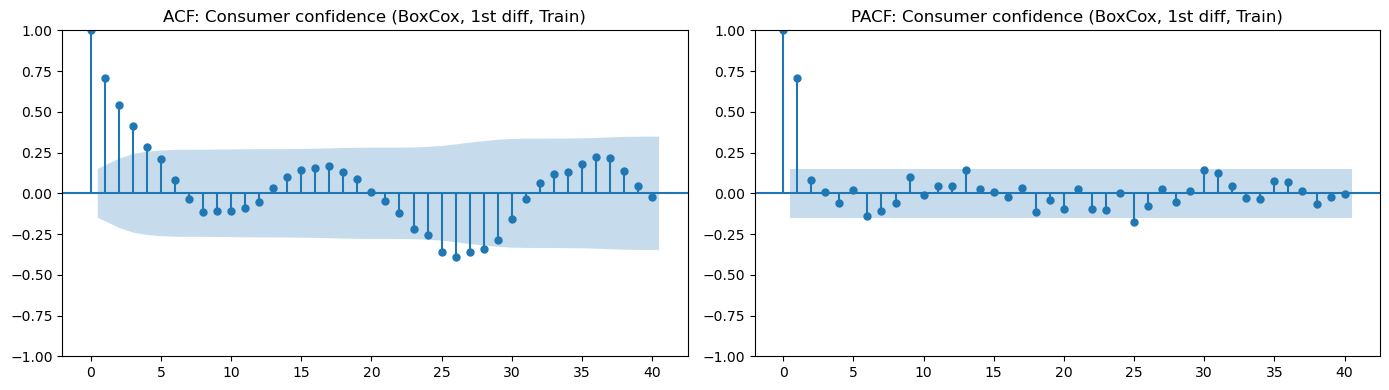

In [ ]:


# Use BoxCox-transformed, 1st-differenced train split for 'Consumer confidence (E)'
exog_feature_conf = np.diff(boxcox_all['Consumer confidence (E)'][:train_end], n=1)
target_diff = train_bc_diff

# Try lags 1 to 6 for exogenous variable
max_lag = 6

aic_bic_results_conf = []

for lag in range(1, max_lag + 1):
    # Lag exogenous variable (align with target_diff)
    exog_lagged = np.roll(exog_feature_conf, lag)
    exog_lagged[:lag] = np.nan  # first 'lag' values are invalid
    valid_idx = ~np.isnan(exog_lagged)
    y_valid = target_diff[valid_idx]
    exog_valid = exog_lagged[valid_idx].reshape(-1, 1)
    
    # Fit SARIMAX (ARIMA(0,0,0) since already differenced, no AR/MA terms)
    model = sm.tsa.SARIMAX(
        y_valid,
        order=(0, 0, 0),
        exog=exog_valid,
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    res = model.fit(disp=False)
    aic_bic_results_conf.append({
        'lag': lag,
        'AIC': res.aic,
        'BIC': res.bic
    })

# Sort by AIC and BIC
aic_sorted_conf = sorted(aic_bic_results_conf, key=lambda x: x['AIC'])
bic_sorted_conf = sorted(aic_bic_results_conf, key=lambda x: x['BIC'])

print("Optimal lags for Consumer confidence (E) sorted by AIC:")
for r in aic_sorted_conf:
    print(f"Lag: {r['lag']}, AIC: {r['AIC']:.2f}, BIC: {r['BIC']:.2f}")

print("\nOptimal lags for Consumer confidence (E) sorted by BIC:")
for r in bic_sorted_conf:
    print(f"Lag: {r['lag']}, AIC: {r['AIC']:.2f}, BIC: {r['BIC']:.2f}")

    # Plot ACF and PACF for the BoxCox-transformed, 1st-differenced Consumer confidence (train split)
    conf_bc_diff = exog_feature_conf

plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plot_acf(conf_bc_diff, ax=plt.gca(), lags=40)
plt.title('ACF: Consumer confidence (BoxCox, 1st diff, Train)')

plt.subplot(1, 2, 2)
plot_pacf(conf_bc_diff, ax=plt.gca(), lags=40, method='ywm')
plt.title('PACF: Consumer confidence (BoxCox, 1st diff, Train)')

plt.tight_layout()
plt.show()

Rolling 3-step RMSE: 3447.04
Rolling 3-step MAPE: 17.32%


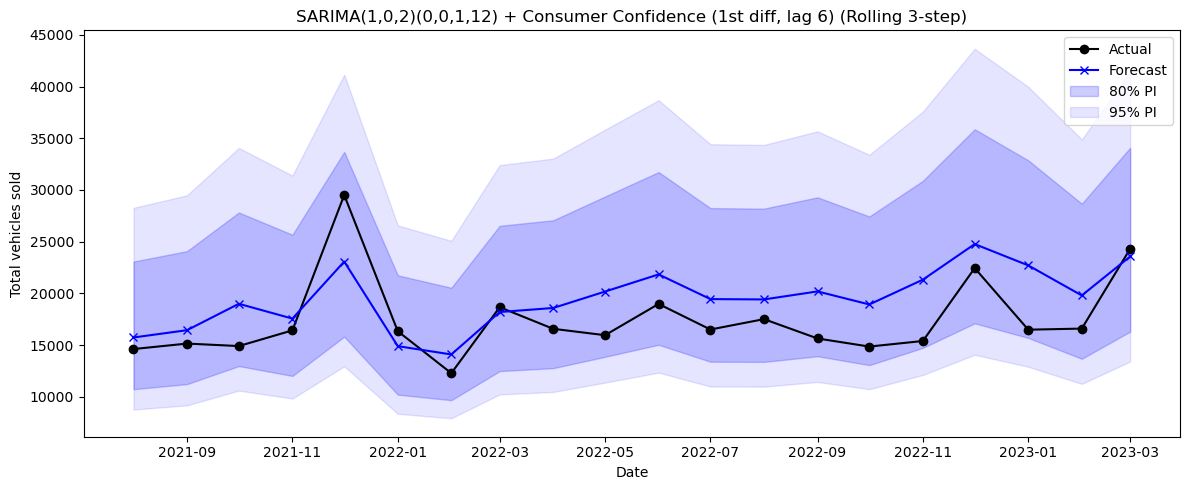

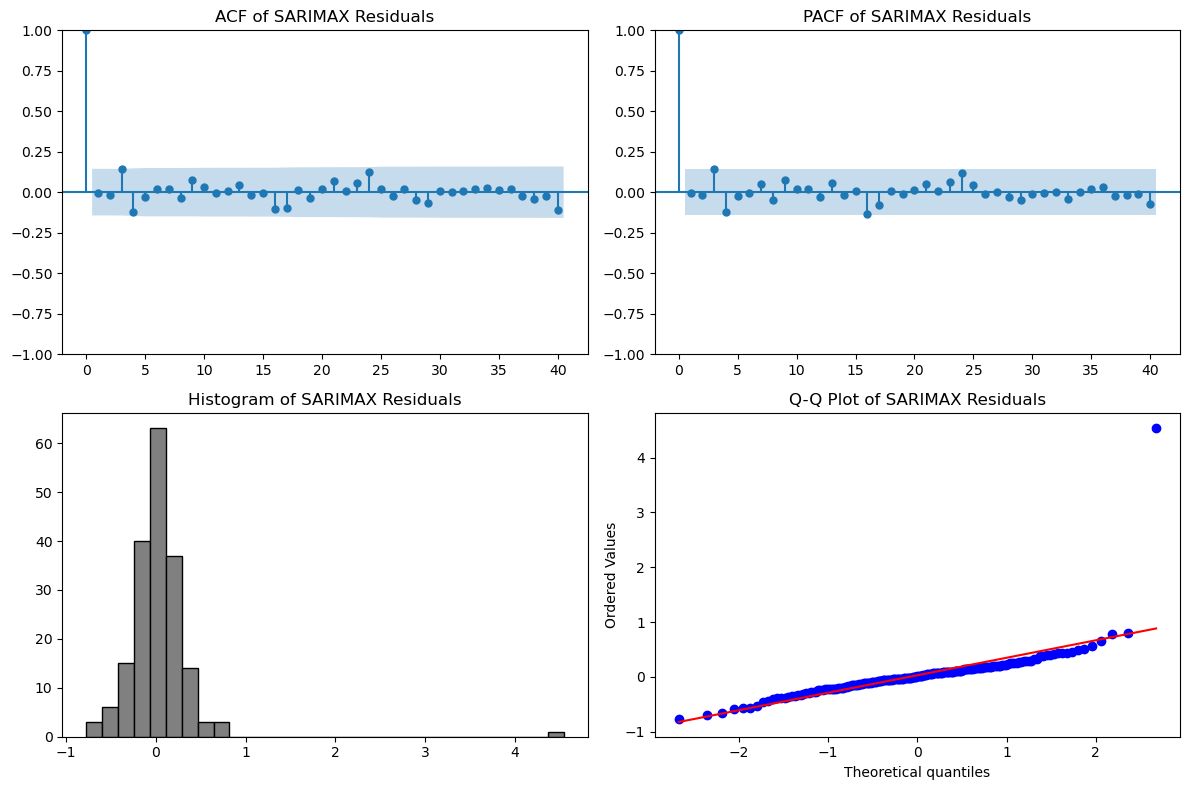

Ljung-Box test p-values (no autocorrelation if > 0.05):
      lb_stat  lb_pvalue
10   8.933602   0.538416
20  14.027982   0.829074
30  21.012899   0.887484


In [ ]:
# rolling 3-step SARIMA with Consumer Confidence (lag 6) + FIRST DIFFERENCING
warnings.filterwarnings("ignore", category=ValueWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# ─── 1. Prepare data ───────────────────────────────────────────────────────────
conf_bc_raw = boxcox_all['Consumer confidence (E)']
conf_bc = np.diff(conf_bc_raw)  # FIRST DIFFERENCE
target_bc = boxcox_all[target]

# Adjust indices for differencing
history_y = list(target_bc[1:train_end])  # align with diffed conf_bc
history_conf = list(conf_bc[:train_end-1])

val_y = target_bc[train_end:val_end]
val_conf = conf_bc[train_end-1:val_end-1]

horizon = 3
lag = 6  # chosen exogenous lag

predictions_bc = []
conf_int_80 = []
conf_int_95 = []

# ─── 2. Rolling loop ────────────────────────────────────────────────────────────
for t in range(len(val_y) - horizon + 1):
    # 2a) Build a DataFrame of history + lagged conf
    df_hist = pd.DataFrame({
        'y': history_y,
        'conf': history_conf
    })
    df_hist['conf_lag6'] = df_hist['conf'].shift(lag)
    df_hist = df_hist.dropna()

    y_hist = df_hist['y']
    exog_hist = df_hist['conf_lag6'].values.reshape(-1, 1)

    # 2b) Fit SARIMAX on history
    model = SARIMAX(
        y_hist,
        exog=exog_hist,
        order=(1, 0, 2),
        seasonal_order=(0, 0, 1, 12),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    fitted = model.fit(disp=False)

    # 2c) Construct future exogenous inputs **only** from history_conf
    conf_future_lags = [
        history_conf[-lag + (i+1)]
        for i in range(horizon)
    ]
    exog_future = np.array(conf_future_lags).reshape(horizon, 1)

    # 2d) Multi-step forecast with exog
    fc = fitted.get_forecast(steps=horizon, exog=exog_future)

    # pull out the 3rd step’s point forecast + intervals
    yhat = fc.predicted_mean.iloc[-1]
    ci80, ci80_u = fc.conf_int(alpha=0.20).iloc[-1].values
    ci95, ci95_u = fc.conf_int(alpha=0.05).iloc[-1].values

    predictions_bc.append(yhat)
    conf_int_80.append((ci80, ci80_u))
    conf_int_95.append((ci95, ci95_u))

    # 2e) Now that we’ve “observed” time t, append the actuals to history
    history_y.append(val_y[t])
    history_conf.append(val_conf[t])

# ─── 3. Invert Box–Cox & compute metrics ────────────────────────────────────────
lam, shift = boxcox_lambdas_all[target]
def inv_boxcox(y, lam):
    return np.exp(y) if lam == 0 else np.power(lam * y + 1, 1/lam)

pred_bc = np.array(predictions_bc)
pred_orig = inv_boxcox(pred_bc, lam) - shift
actuals = y_val.values[horizon-1:]

# intervals
ci80_arr = np.array(conf_int_80)
ci95_arr = np.array(conf_int_95)

ci80_lower = inv_boxcox(ci80_arr[:,0], lam) - shift
ci80_upper = inv_boxcox(ci80_arr[:,1], lam) - shift
ci95_lower = inv_boxcox(ci95_arr[:,0], lam) - shift
ci95_upper = inv_boxcox(ci95_arr[:,1], lam) - shift

# metrics
rmse = np.sqrt(mean_squared_error(actuals, pred_orig))
mape = mean_absolute_percentage_error(actuals, pred_orig)

print(f"Rolling 3-step RMSE: {rmse:.2f}")
print(f"Rolling 3-step MAPE: {mape:.2%}")

# ─── 4. Plot results ────────────────────────────────────────────────────────────
x_dates = df["Time Period (T)"][train_end+horizon-1:val_end]

plt.figure(figsize=(12,5))
plt.plot(x_dates, actuals, marker='o', color='black', label='Actual')
plt.plot(x_dates, pred_orig, marker='x', color='blue', label='Forecast')
plt.fill_between(x_dates, ci80_lower, ci80_upper, color='blue', alpha=0.2, label='80% PI')
plt.fill_between(x_dates, ci95_lower, ci95_upper, color='blue', alpha=0.1, label='95% PI')
plt.title('SARIMA(1,0,2)(0,0,1,12) + Consumer Confidence (1st diff, lag 6) (Rolling 3-step)')
plt.xlabel('Date')
plt.ylabel('Total vehicles sold')
plt.legend()
plt.tight_layout()
plt.show()

# ─── 5. Residual diagnostics ────────────────────────────────────────────────────

# Get residuals from the last fitted SARIMAX model in the rolling loop
residuals = fitted.resid

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# ACF plot
plot_acf(residuals, ax=axes[0, 0], lags=40)
axes[0, 0].set_title("ACF of SARIMAX Residuals")

# PACF plot
plot_pacf(residuals, ax=axes[0, 1], lags=40, method='ywm')
axes[0, 1].set_title("PACF of SARIMAX Residuals")

# Histogram
axes[1, 0].hist(residuals, bins=30, color='gray', edgecolor='black')
axes[1, 0].set_title("Histogram of SARIMAX Residuals")

# Q-Q plot
stats.probplot(residuals, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title("Q-Q Plot of SARIMAX Residuals")

plt.tight_layout()
plt.show()

# Ljung-Box test for autocorrelation (white noise)
lb_test = acorr_ljungbox(residuals, lags=[10, 20, 30], return_df=True)
print("Ljung-Box test p-values (no autocorrelation if > 0.05):")
print(lb_test[['lb_stat', 'lb_pvalue']])

### Fit Sarimax and diagnose 

Rolling 3-step RMSE: 3801.21
Rolling 3-step MAPE: 18.87%


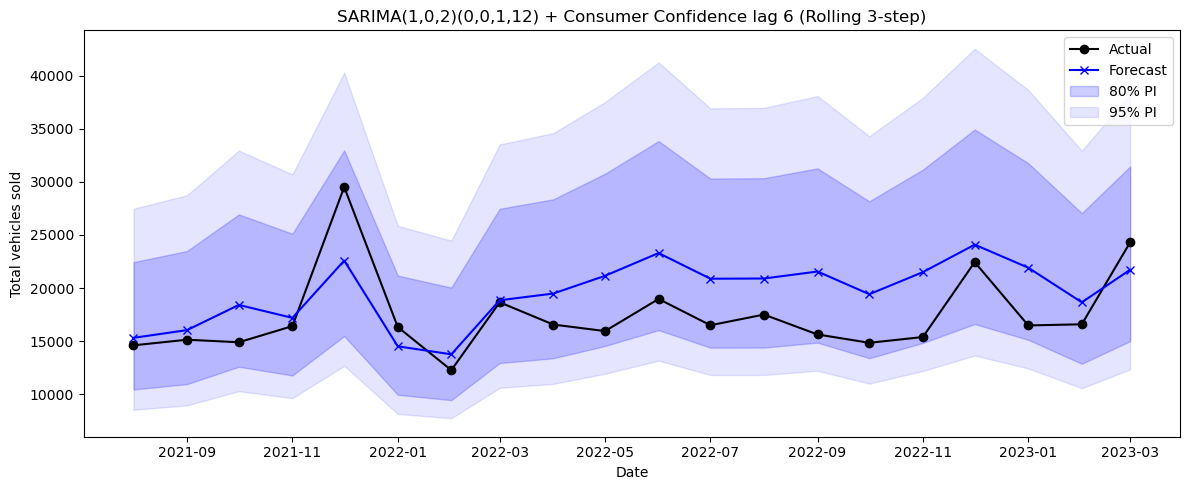

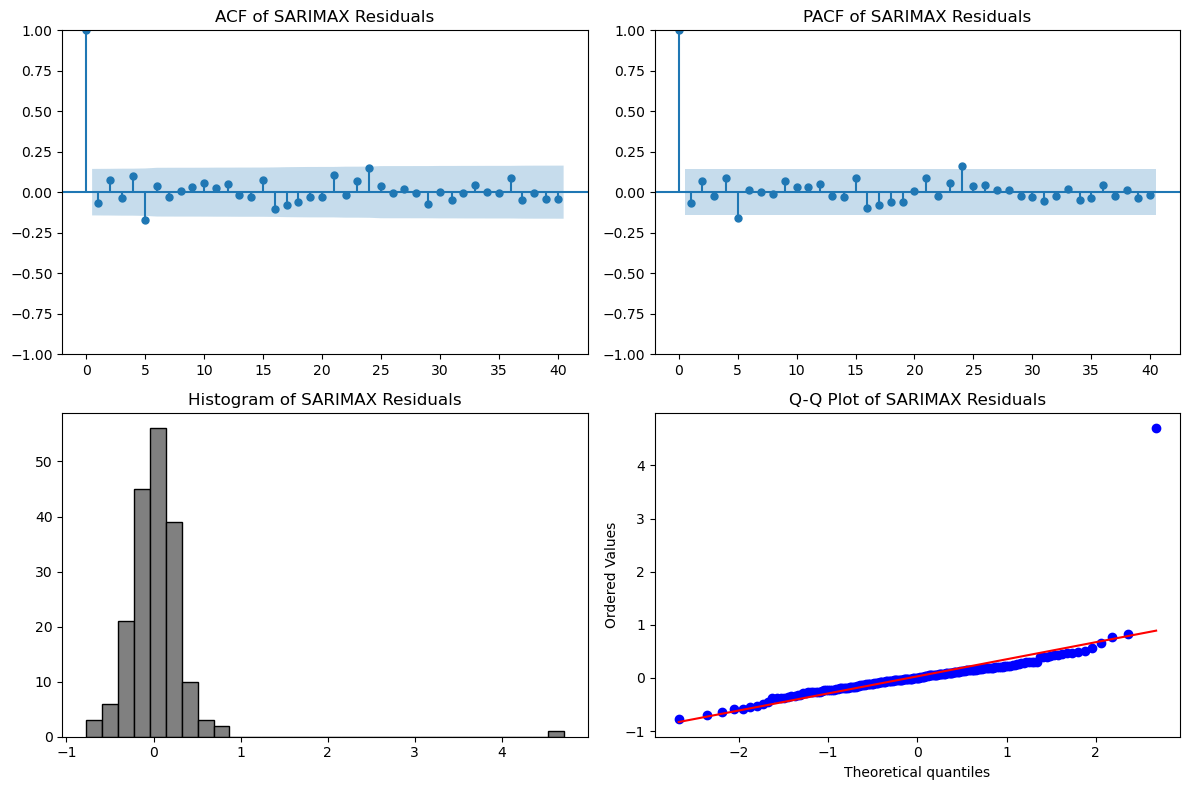

Ljung-Box test p-values (no autocorrelation if > 0.05):
      lb_stat  lb_pvalue
10  10.844671   0.369747
20  17.623895   0.612169
30  27.654469   0.588741


In [ ]:
# # rolling 3-step SARIMA with Consumer Confidence (lag 6)
# warnings.filterwarnings("ignore", category=ValueWarning)
# warnings.filterwarnings("ignore", category=ConvergenceWarning)
# warnings.filterwarnings("ignore", category=FutureWarning)

# # ─── 1. Prepare data ───────────────────────────────────────────────────────────
# conf_bc   = boxcox_all['Consumer confidence (E)']
# target_bc = boxcox_all[target]

# history_y   = list(target_bc[:train_end])
# history_conf = list(conf_bc[:train_end])

# val_y   = target_bc[train_end:val_end]
# val_conf = conf_bc[train_end:val_end]

# horizon = 3
# lag     = 6  # chosen exogenous lag

# predictions_bc = []
# conf_int_80    = []
# conf_int_95    = []

# # ─── 2. Rolling loop ────────────────────────────────────────────────────────────
# for t in range(len(val_y) - horizon + 1):
#     # 2a) Build a DataFrame of history + lagged conf
#     df_hist = pd.DataFrame({
#         'y': history_y,
#         'conf': history_conf
#     })
#     df_hist['conf_lag6'] = df_hist['conf'].shift(lag)
#     df_hist = df_hist.dropna()

#     y_hist    = df_hist['y']
#     exog_hist = df_hist['conf_lag6'].values.reshape(-1, 1)

#     # 2b) Fit SARIMAX on history
#     model = SARIMAX(
#         y_hist,
#         exog=exog_hist,
#         order=(1, 0, 2),
#         seasonal_order=(0, 0, 1, 12),
#         enforce_stationarity=False,
#         enforce_invertibility=False
#     )
#     fitted = model.fit(disp=False)

#     # 2c) Construct future exogenous inputs **only** from history_conf
#     conf_future_lags = [
#         history_conf[-lag + (i+1)]
#         for i in range(horizon)
#     ]
#     exog_future = np.array(conf_future_lags).reshape(horizon, 1)

#     # 2d) Multi-step forecast with exog
#     fc = fitted.get_forecast(steps=horizon, exog=exog_future)

#     # pull out the 3rd step’s point forecast + intervals
#     yhat      = fc.predicted_mean.iloc[-1]
#     ci80, ci80_u = fc.conf_int(alpha=0.20).iloc[-1].values
#     ci95, ci95_u = fc.conf_int(alpha=0.05).iloc[-1].values

#     predictions_bc.append(yhat)
#     conf_int_80.append((ci80, ci80_u))
#     conf_int_95.append((ci95, ci95_u))

#     # 2e) Now that we’ve “observed” time t, append the actuals to history
#     history_y.append(val_y[t])
#     history_conf.append(val_conf[t])

# # ─── 3. Invert Box–Cox & compute metrics ────────────────────────────────────────
# lam, shift = boxcox_lambdas_all[target]
# def inv_boxcox(y, lam):
#     return np.exp(y) if lam == 0 else np.power(lam * y + 1, 1/lam)

# pred_bc = np.array(predictions_bc)
# pred_orig  = inv_boxcox(pred_bc, lam) - shift
# actuals    = y_val.values[horizon-1:]

# # intervals
# ci80_arr = np.array(conf_int_80)
# ci95_arr = np.array(conf_int_95)

# ci80_lower = inv_boxcox(ci80_arr[:,0], lam) - shift
# ci80_upper = inv_boxcox(ci80_arr[:,1], lam) - shift
# ci95_lower = inv_boxcox(ci95_arr[:,0], lam) - shift
# ci95_upper = inv_boxcox(ci95_arr[:,1], lam) - shift

# # metrics
# rmse = np.sqrt(mean_squared_error(actuals, pred_orig))
# mape = mean_absolute_percentage_error(actuals, pred_orig)

# print(f"Rolling 3-step RMSE: {rmse:.2f}")
# print(f"Rolling 3-step MAPE: {mape:.2%}")

# # ─── 4. Plot results ────────────────────────────────────────────────────────────
# x_dates = df["Time Period (T)"][train_end+horizon-1:val_end]

# plt.figure(figsize=(12,5))
# plt.plot(x_dates, actuals, marker='o', color='black', label='Actual')
# plt.plot(x_dates, pred_orig, marker='x', color='blue', label='Forecast')
# plt.fill_between(x_dates, ci80_lower, ci80_upper, color='blue', alpha=0.2, label='80% PI')
# plt.fill_between(x_dates, ci95_lower, ci95_upper, color='blue', alpha=0.1, label='95% PI')
# plt.title('SARIMA(1,0,2)(0,0,1,12) + Consumer Confidence lag 6 (Rolling 3-step)')
# plt.xlabel('Date')
# plt.ylabel('Total vehicles sold')
# plt.legend()
# plt.tight_layout()
# plt.show()

# # ─── 5. Residual diagnostics ────────────────────────────────────────────────────


# # Get residuals from the last fitted SARIMAX model in the rolling loop
# residuals = fitted.resid

# fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# # ACF plot
# plot_acf(residuals, ax=axes[0, 0], lags=40)
# axes[0, 0].set_title("ACF of SARIMAX Residuals")

# # PACF plot
# plot_pacf(residuals, ax=axes[0, 1], lags=40, method='ywm')
# axes[0, 1].set_title("PACF of SARIMAX Residuals")

# # Histogram
# axes[1, 0].hist(residuals, bins=30, color='gray', edgecolor='black')
# axes[1, 0].set_title("Histogram of SARIMAX Residuals")

# # Q-Q plot
# stats.probplot(residuals, dist="norm", plot=axes[1, 1])
# axes[1, 1].set_title("Q-Q Plot of SARIMAX Residuals")

# plt.tight_layout()
# plt.show()

# # Ljung-Box test for autocorrelation (white noise)
# lb_test = acorr_ljungbox(residuals, lags=[10, 20, 30], return_df=True)
# print("Ljung-Box test p-values (no autocorrelation if > 0.05):")
# print(lb_test[['lb_stat', 'lb_pvalue']])

# 8 All features together/ turn this into top features together

| Model                       | Lag | RMSE        | MAPE       |
| --------------------------- | --- | ----------- | ---------- |
| **Baseline (no exogenous)** | –   | 4359.91     | 18.31%     |
| Gasoline price              | 6   | 3797.68     | **15.54%** |
| Company car tax rate (%)    | 3   | 3756.22     | 19.13%     |
| Home charging (G)           | 5   | **3708.38** | 18.40%     |
| Consumer confidence (E)     | 6   | 3801.21     | 18.87%     |


**Interpretation**
- Gasoline price (lag 6) delivers the strongest MAPE improvement, dropping MAPE from 18.31% to 15.54%.

- Home charging (lag 5) yields the largest RMSE drop, shaving almost 650 units off the baseline error.

- Company car tax and consumer confidence both improve RMSE but worsen MAPE, suggesting they may reduce large errors but introduce relative bias.

Feature Combinations
- Option 1: Gasoline + Home Charging
    Captures both economic and behavioral signals from two uncorrelated sources. This is likely the most complementary and effective two-feature combination.

- Option 2: Gasoline + Company Car Tax
    Combines economic cost and policy incentives. This pair balances market behavior and government regulation.

- Optional third variable: Consumer Confidence
    This can be considered if residual diagnostics remain acceptable (no strong multicollinearity or autocorrelation). It captures macroeconomic perception but may be noisier.

**Next Steps**
- Test the performance of each combination using 3-step rolling validation.

- Check residuals (ACF, PACF, Ljung-Box test) to confirm no model misspecification.

- Evaluate combined models on both RMSE and MAPE.

- Select the final model based on predictive accuracy and diagnostic performance.

### Option 1 Gasoline + Home Charging

Validation RMSE (3-step rolling): 4582.25
Validation MAPE (3-step rolling): 17.73%


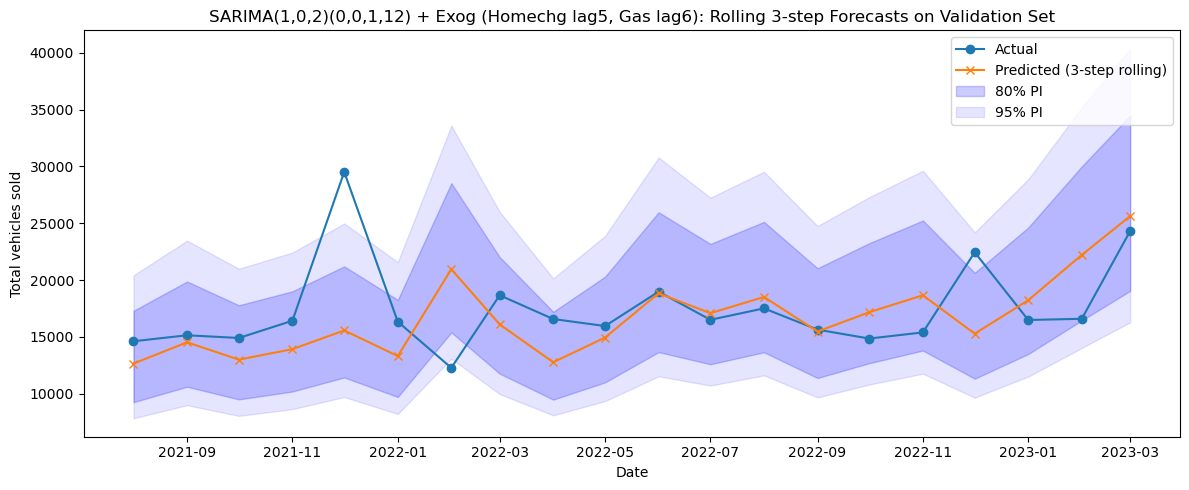

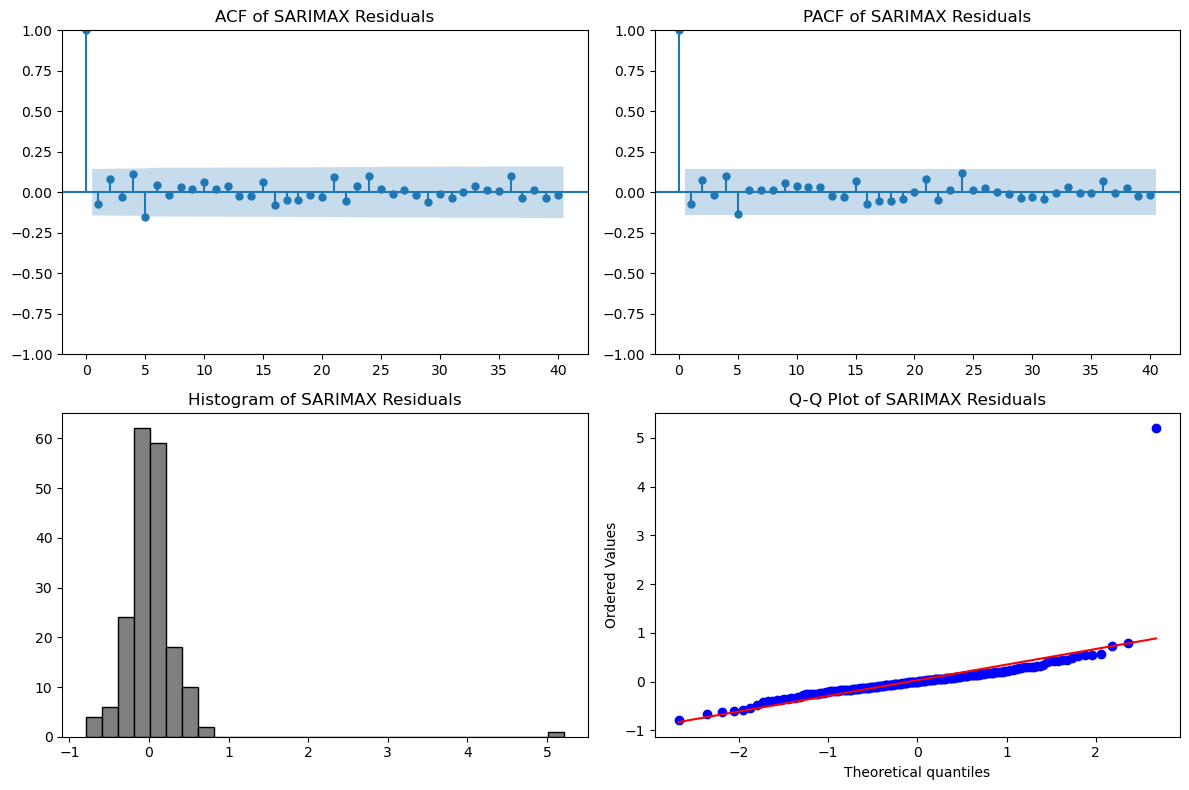

Ljung-Box test p-values (no autocorrelation if > 0.05):
      lb_stat  lb_pvalue
10  10.828920   0.371001
20  14.647518   0.796209
30  20.558511   0.901184


In [ ]:
# ─── 1. Prepare data ───────────────────────────────────────────────────────────
homechg_bc = boxcox_all['Home charging (G)']
gas_bc     = boxcox_all['Gasoline (Euro95) - Average price (F)']
target_bc  = boxcox_all[target]

history_y        = list(target_bc[:train_end])
history_homechg  = list(homechg_bc[:train_end])
history_gas      = list(gas_bc[:train_end])

val_y        = target_bc[train_end:val_end]
val_homechg  = homechg_bc[train_end:val_end]
val_gas      = gas_bc[train_end:val_end]

horizon = 3
lags    = [5, 6]  # lags for homechg, gas

predictions_bc = []
conf_int_80    = []
conf_int_95    = []

# ─── 2. Rolling loop ────────────────────────────────────────────────────────────
for t in range(len(val_y) - horizon + 1):
    # Lag exogenous variables
    homechg_hist = np.array(history_homechg)
    gas_hist     = np.array(history_gas)

    homechg_hist_lag5 = np.roll(homechg_hist, lags[0]); homechg_hist_lag5[:lags[0]] = np.nan
    gas_hist_lag6     = np.roll(gas_hist, lags[1]); gas_hist_lag6[:lags[1]] = np.nan

    # Align all (drop first 6 for max lag)
    y_hist = np.array(history_y)[lags[1]:]
    exog_hist = np.column_stack([
        homechg_hist_lag5[lags[1]:], gas_hist_lag6[lags[1]:]
    ])

    # Fit SARIMAX on history
    model = SARIMAX(
        y_hist,
        exog=exog_hist,
        order=(1, 0, 2),
        seasonal_order=(0, 0, 1, 12),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    fitted = model.fit(disp=False)

    # Recursive 3-step forecast with intervals
    temp_history_y        = history_y.copy()
    temp_history_homechg  = history_homechg.copy()
    temp_history_gas      = history_gas.copy()
    for step in range(horizon):
        idx = t + step
        homechg_exog_full = np.concatenate([np.array(temp_history_homechg)[-lags[0]:], [val_homechg[idx]]])
        gas_exog_full     = np.concatenate([np.array(temp_history_gas)[-lags[1]:], [val_gas[idx]]])
        homechg_exog_lag5 = np.roll(homechg_exog_full, lags[0])[lags[0]:]
        gas_exog_lag6     = np.roll(gas_exog_full, lags[1])[lags[1]:]
        exog_next = np.column_stack([
            homechg_exog_lag5, gas_exog_lag6
        ])
        res = fitted.get_forecast(steps=1, exog=exog_next)
        yhat = res.predicted_mean[0]
        ci_80 = res.conf_int(alpha=0.20)[0]
        ci_95 = res.conf_int(alpha=0.05)[0]
        temp_history_y.append(yhat)
        temp_history_homechg.append(val_homechg[idx])
        temp_history_gas.append(val_gas[idx])
    predictions_bc.append(yhat)
    conf_int_80.append(ci_80)
    conf_int_95.append(ci_95)

    # Update rolling history with actuals for next window
    history_y.append(val_y[t])
    history_homechg.append(val_homechg[t])
    history_gas.append(val_gas[t])

# ─── 3. Invert Box–Cox & compute metrics ────────────────────────────────────────
lam, shift = boxcox_lambdas_all[target]
def inv_boxcox(y, lam):
    return np.exp(y) if lam == 0 else np.power(lam * y + 1, 1/lam)

pred_bc = np.array(predictions_bc)
pred_orig  = inv_boxcox(pred_bc, lam) - shift
actuals    = y_val.values[horizon-1:]

conf_int_80 = np.array(conf_int_80)
conf_int_95 = np.array(conf_int_95)
ci_80_lower = inv_boxcox(conf_int_80[:, 0], lam) - shift
ci_80_upper = inv_boxcox(conf_int_80[:, 1], lam) - shift
ci_95_lower = inv_boxcox(conf_int_95[:, 0], lam) - shift
ci_95_upper = inv_boxcox(conf_int_95[:, 1], lam) - shift

rmse_rolling = np.sqrt(mean_squared_error(actuals, pred_orig))
mape_rolling = mean_absolute_percentage_error(actuals, pred_orig)
print(f"Validation RMSE (3-step rolling): {rmse_rolling:.2f}")
print(f"Validation MAPE (3-step rolling): {mape_rolling:.2%}")

# ─── 4. Plot results ────────────────────────────────────────────────────────────
x_dates = df["Time Period (T)"][train_end+horizon-1:val_end]
plt.figure(figsize=(12, 5))
plt.plot(x_dates, actuals, label='Actual', marker='o')
plt.plot(x_dates, pred_orig, label='Predicted (3-step rolling)', marker='x')
plt.fill_between(x_dates, ci_80_lower, ci_80_upper, color='blue', alpha=0.2, label='80% PI')
plt.fill_between(x_dates, ci_95_lower, ci_95_upper, color='blue', alpha=0.1, label='95% PI')
plt.title('SARIMA(1,0,2)(0,0,1,12) + Exog (Homechg lag5, Gas lag6): Rolling 3-step Forecasts on Validation Set')
plt.xlabel('Date')
plt.ylabel('Total vehicles sold')
plt.legend()
plt.tight_layout()
plt.show()

# ─── 5. Residual diagnostics ────────────────────────────────────────────────────
import scipy.stats as stats

# Get residuals from the last fitted SARIMAX model in the rolling loop
residuals = fitted.resid

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# ACF plot
plot_acf(residuals, ax=axes[0, 0], lags=40)
axes[0, 0].set_title("ACF of SARIMAX Residuals")

# PACF plot
plot_pacf(residuals, ax=axes[0, 1], lags=40, method='ywm')
axes[0, 1].set_title("PACF of SARIMAX Residuals")

# Histogram
axes[1, 0].hist(residuals, bins=30, color='gray', edgecolor='black')
axes[1, 0].set_title("Histogram of SARIMAX Residuals")

# Q-Q plot
stats.probplot(residuals, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title("Q-Q Plot of SARIMAX Residuals")

plt.tight_layout()
plt.show()

# Ljung-Box test for autocorrelation (white noise)
lb_test = acorr_ljungbox(residuals, lags=[10, 20, 30], return_df=True)
print("Ljung-Box test p-values (no autocorrelation if > 0.05):")
print(lb_test[['lb_stat', 'lb_pvalue']])

### Option 2 Gasoline + Company Car Tax

Validation RMSE (3-step rolling): 4721.88
Validation MAPE (3-step rolling): 18.73%


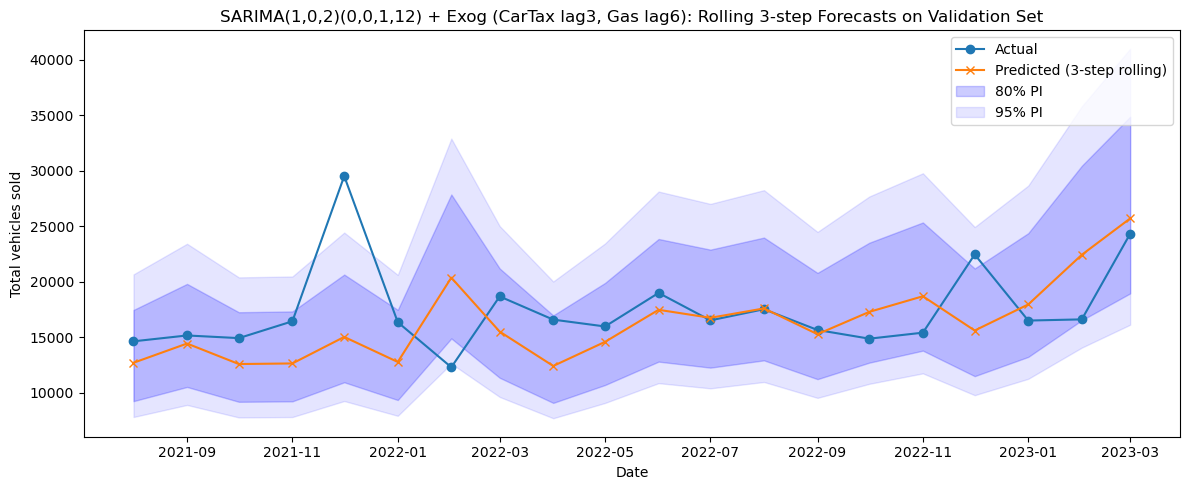

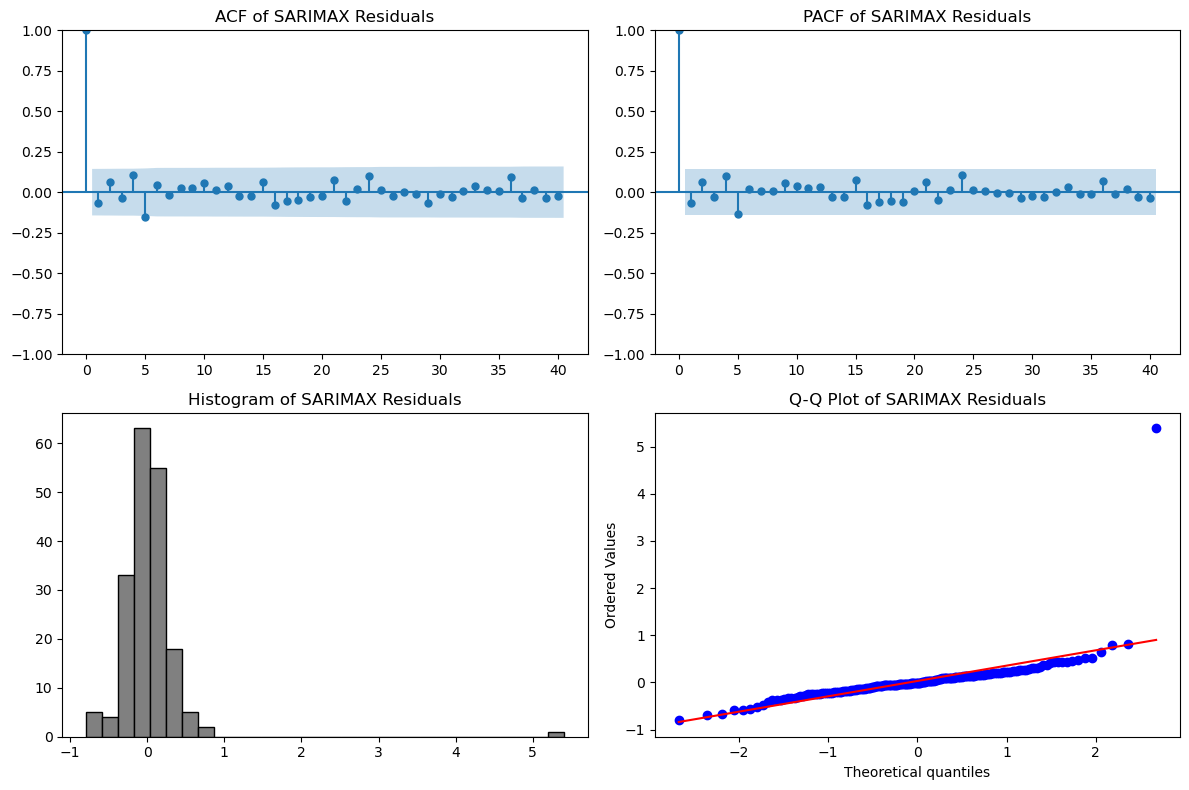

Ljung-Box test p-values (no autocorrelation if > 0.05):
      lb_stat  lb_pvalue
10   9.819138   0.456502
20  14.042439   0.828338
30  19.337241   0.932663


In [ ]:
# ─── 1. Prepare data ───────────────────────────────────────────────────────────
car_tax_bc = boxcox_all['Company car tax rate (%)']
gas_bc     = boxcox_all['Gasoline (Euro95) - Average price (F)']
target_bc  = boxcox_all[target]

history_y      = list(target_bc[:train_end])
history_tax    = list(car_tax_bc[:train_end])
history_gas    = list(gas_bc[:train_end])

val_y      = target_bc[train_end:val_end]
val_tax    = car_tax_bc[train_end:val_end]
val_gas    = gas_bc[train_end:val_end]

horizon = 3
lags    = [3, 6]  # lags for car tax, gas

predictions_bc = []
conf_int_80    = []
conf_int_95    = []

# ─── 2. Rolling loop ────────────────────────────────────────────────────────────
for t in range(len(val_y) - horizon + 1):
    # Lag exogenous variables
    tax_hist = np.array(history_tax)
    gas_hist = np.array(history_gas)

    tax_hist_lag3 = np.roll(tax_hist, lags[0]); tax_hist_lag3[:lags[0]] = np.nan
    gas_hist_lag6 = np.roll(gas_hist, lags[1]); gas_hist_lag6[:lags[1]] = np.nan

    # Align all (drop first 6 for max lag)
    y_hist = np.array(history_y)[lags[1]:]
    exog_hist = np.column_stack([
        tax_hist_lag3[lags[1]:], gas_hist_lag6[lags[1]:]
    ])

    # Fit SARIMAX on history
    model = SARIMAX(
        y_hist,
        exog=exog_hist,
        order=(1, 0, 2),
        seasonal_order=(0, 0, 1, 12),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    fitted = model.fit(disp=False)

    # Recursive 3-step forecast with intervals
    temp_history_y      = history_y.copy()
    temp_history_tax    = history_tax.copy()
    temp_history_gas    = history_gas.copy()
    for step in range(horizon):
        idx = t + step
        tax_exog_full = np.concatenate([np.array(temp_history_tax)[-lags[0]:], [val_tax[idx]]])
        gas_exog_full = np.concatenate([np.array(temp_history_gas)[-lags[1]:], [val_gas[idx]]])
        tax_exog_lag3 = np.roll(tax_exog_full, lags[0])[lags[0]:]
        gas_exog_lag6 = np.roll(gas_exog_full, lags[1])[lags[1]:]
        exog_next = np.column_stack([
            tax_exog_lag3, gas_exog_lag6
        ])
        res = fitted.get_forecast(steps=1, exog=exog_next)
        yhat = res.predicted_mean[0]
        ci_80 = res.conf_int(alpha=0.20)[0]
        ci_95 = res.conf_int(alpha=0.05)[0]
        temp_history_y.append(yhat)
        temp_history_tax.append(val_tax[idx])
        temp_history_gas.append(val_gas[idx])
    predictions_bc.append(yhat)
    conf_int_80.append(ci_80)
    conf_int_95.append(ci_95)

    # Update rolling history with actuals for next window
    history_y.append(val_y[t])
    history_tax.append(val_tax[t])
    history_gas.append(val_gas[t])

# ─── 3. Invert Box–Cox & compute metrics ────────────────────────────────────────
lam, shift = boxcox_lambdas_all[target]
def inv_boxcox(y, lam):
    return np.exp(y) if lam == 0 else np.power(lam * y + 1, 1/lam)

pred_bc = np.array(predictions_bc)
pred_orig  = inv_boxcox(pred_bc, lam) - shift
actuals    = y_val.values[horizon-1:]

conf_int_80 = np.array(conf_int_80)
conf_int_95 = np.array(conf_int_95)
ci_80_lower = inv_boxcox(conf_int_80[:, 0], lam) - shift
ci_80_upper = inv_boxcox(conf_int_80[:, 1], lam) - shift
ci_95_lower = inv_boxcox(conf_int_95[:, 0], lam) - shift
ci_95_upper = inv_boxcox(conf_int_95[:, 1], lam) - shift

rmse_rolling = np.sqrt(mean_squared_error(actuals, pred_orig))
mape_rolling = mean_absolute_percentage_error(actuals, pred_orig)
print(f"Validation RMSE (3-step rolling): {rmse_rolling:.2f}")
print(f"Validation MAPE (3-step rolling): {mape_rolling:.2%}")

# ─── 4. Plot results ────────────────────────────────────────────────────────────
x_dates = df["Time Period (T)"][train_end+horizon-1:val_end]
plt.figure(figsize=(12, 5))
plt.plot(x_dates, actuals, label='Actual', marker='o')
plt.plot(x_dates, pred_orig, label='Predicted (3-step rolling)', marker='x')
plt.fill_between(x_dates, ci_80_lower, ci_80_upper, color='blue', alpha=0.2, label='80% PI')
plt.fill_between(x_dates, ci_95_lower, ci_95_upper, color='blue', alpha=0.1, label='95% PI')
plt.title('SARIMA(1,0,2)(0,0,1,12) + Exog (CarTax lag3, Gas lag6): Rolling 3-step Forecasts on Validation Set')
plt.xlabel('Date')
plt.ylabel('Total vehicles sold')
plt.legend()
plt.tight_layout()
plt.show()

# ─── 5. Residual diagnostics ────────────────────────────────────────────────────
import scipy.stats as stats

# Get residuals from the last fitted SARIMAX model in the rolling loop
residuals = fitted.resid

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# ACF plot
plot_acf(residuals, ax=axes[0, 0], lags=40)
axes[0, 0].set_title("ACF of SARIMAX Residuals")

# PACF plot
plot_pacf(residuals, ax=axes[0, 1], lags=40, method='ywm')
axes[0, 1].set_title("PACF of SARIMAX Residuals")

# Histogram
axes[1, 0].hist(residuals, bins=30, color='gray', edgecolor='black')
axes[1, 0].set_title("Histogram of SARIMAX Residuals")

# Q-Q plot
stats.probplot(residuals, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title("Q-Q Plot of SARIMAX Residuals")

plt.tight_layout()
plt.show()

# Ljung-Box test for autocorrelation (white noise)
lb_test = acorr_ljungbox(residuals, lags=[10, 20, 30], return_df=True)
print("Ljung-Box test p-values (no autocorrelation if > 0.05):")
print(lb_test[['lb_stat', 'lb_pvalue']])

### option 3 all features

Validation RMSE (3-step rolling): 4541.29
Validation MAPE (3-step rolling): 16.70%


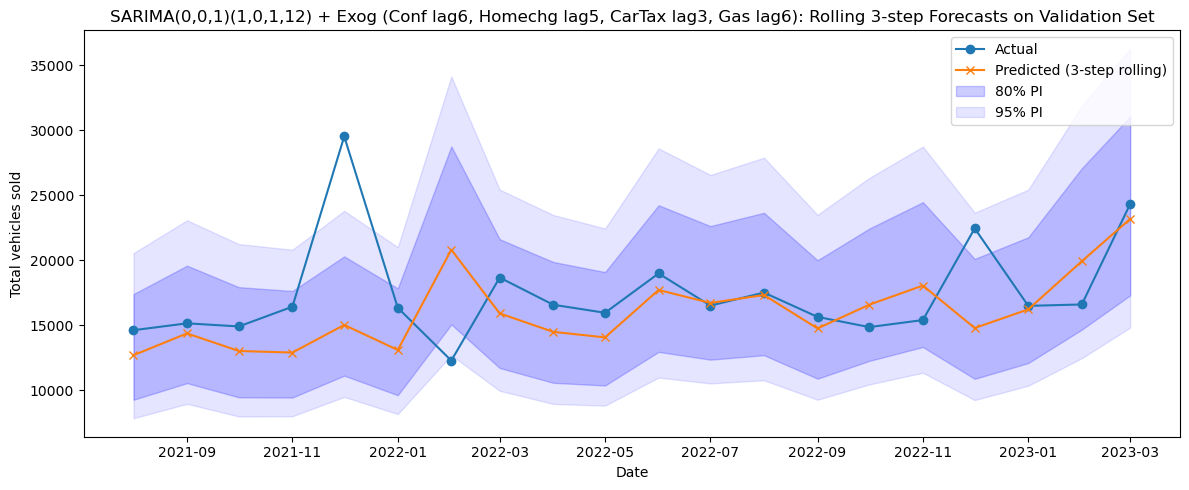

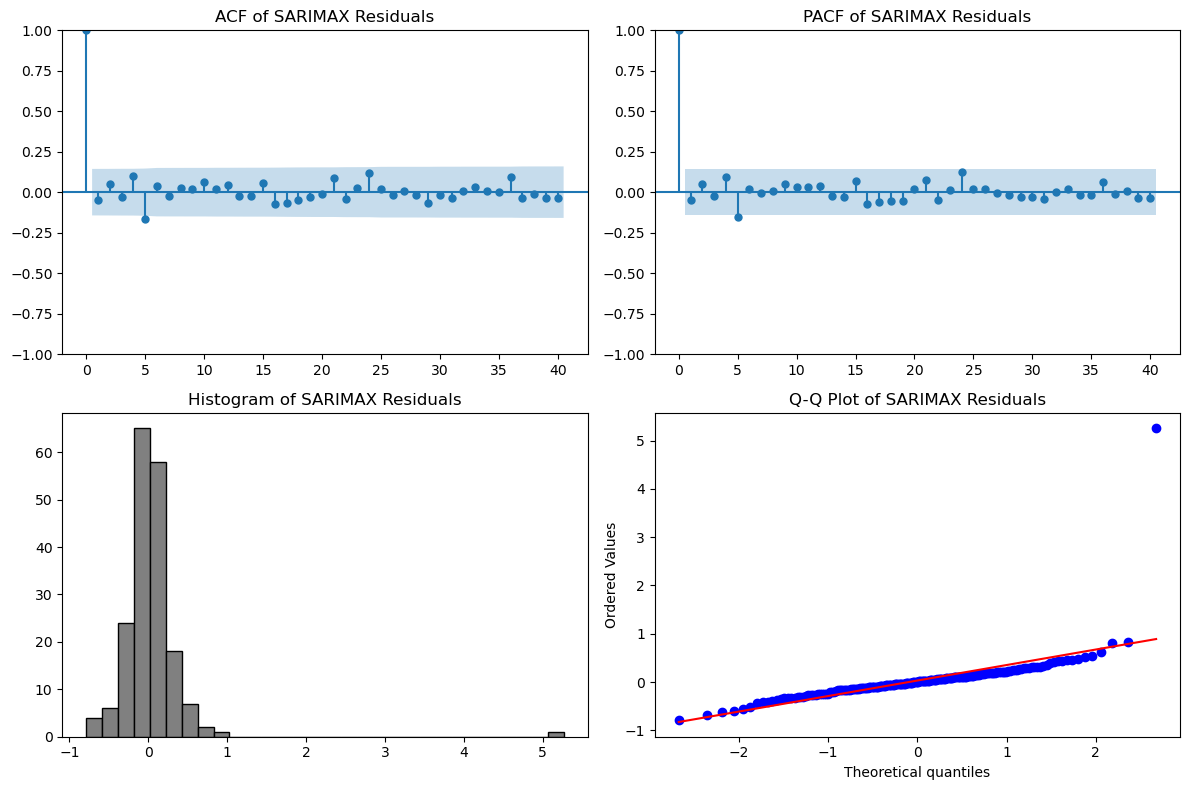

Ljung-Box test p-values (no autocorrelation if > 0.05):
      lb_stat  lb_pvalue
10   9.615913   0.474811
20  13.649981   0.847790
30  20.076234   0.914541


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

# ─── 1. Prepare data ───────────────────────────────────────────────────────────
conf_bc    = boxcox_all['Consumer confidence (E)']
homechg_bc = boxcox_all['Home charging (G)']
car_tax_bc = boxcox_all['Company car tax rate (%)']
gas_bc     = boxcox_all['Gasoline (Euro95) - Average price (F)']
target_bc  = boxcox_all[target]

history_y        = list(target_bc[:train_end])
history_conf     = list(conf_bc[:train_end])
history_homechg  = list(homechg_bc[:train_end])
history_tax      = list(car_tax_bc[:train_end])
history_gas      = list(gas_bc[:train_end])

val_y        = target_bc[train_end:val_end]
val_conf     = conf_bc[train_end:val_end]
val_homechg  = homechg_bc[train_end:val_end]
val_tax      = car_tax_bc[train_end:val_end]
val_gas      = gas_bc[train_end:val_end]

horizon = 3
lags    = [6, 5, 3, 6]  # lags for conf, homechg, tax, gas

predictions_bc = []
conf_int_80    = []
conf_int_95    = []

# ─── 2. Rolling loop ────────────────────────────────────────────────────────────
for t in range(len(val_y) - horizon + 1):
    # Lag all exogenous variables
    conf_hist    = np.array(history_conf)
    homechg_hist = np.array(history_homechg)
    tax_hist     = np.array(history_tax)
    gas_hist     = np.array(history_gas)

    conf_hist_lag6    = np.roll(conf_hist, lags[0]); conf_hist_lag6[:lags[0]] = np.nan
    homechg_hist_lag5 = np.roll(homechg_hist, lags[1]); homechg_hist_lag5[:lags[1]] = np.nan
    tax_hist_lag3     = np.roll(tax_hist, lags[2]); tax_hist_lag3[:lags[2]] = np.nan
    gas_hist_lag6     = np.roll(gas_hist, lags[3]); gas_hist_lag6[:lags[3]] = np.nan

    # Align all (drop first 6)
    y_hist = np.array(history_y)[6:]
    exog_hist = np.column_stack([
        conf_hist_lag6[6:], homechg_hist_lag5[6:], tax_hist_lag3[6:], gas_hist_lag6[6:]
    ])

    # Fit SARIMAX on history
    model = SARIMAX(
        y_hist,
        exog=exog_hist,
        order=(1, 0, 2),
        seasonal_order=(0, 0, 1, 12),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    fitted = model.fit(disp=False)

    # Recursive 3-step forecast with intervals
    temp_history_y        = history_y.copy()
    temp_history_conf     = history_conf.copy()
    temp_history_homechg  = history_homechg.copy()
    temp_history_tax      = history_tax.copy()
    temp_history_gas      = history_gas.copy()
    for step in range(horizon):
        idx = t + step
        conf_exog_full    = np.concatenate([np.array(temp_history_conf)[-lags[0]:], [val_conf[idx]]])
        homechg_exog_full = np.concatenate([np.array(temp_history_homechg)[-lags[1]:], [val_homechg[idx]]])
        tax_exog_full     = np.concatenate([np.array(temp_history_tax)[-lags[2]:], [val_tax[idx]]])
        gas_exog_full     = np.concatenate([np.array(temp_history_gas)[-lags[3]:], [val_gas[idx]]])
        conf_exog_lag6    = np.roll(conf_exog_full, lags[0])[lags[0]:]
        homechg_exog_lag5 = np.roll(homechg_exog_full, lags[1])[lags[1]:]
        tax_exog_lag3     = np.roll(tax_exog_full, lags[2])[lags[2]:]
        gas_exog_lag6     = np.roll(gas_exog_full, lags[3])[lags[3]:]
        exog_next = np.column_stack([
            conf_exog_lag6, homechg_exog_lag5, tax_exog_lag3, gas_exog_lag6
        ])
        res = fitted.get_forecast(steps=1, exog=exog_next)
        yhat = res.predicted_mean[0]
        ci_80 = res.conf_int(alpha=0.20)[0]
        ci_95 = res.conf_int(alpha=0.05)[0]
        temp_history_y.append(yhat)
        temp_history_conf.append(val_conf[idx])
        temp_history_homechg.append(val_homechg[idx])
        temp_history_tax.append(val_tax[idx])
        temp_history_gas.append(val_gas[idx])
    predictions_bc.append(yhat)
    conf_int_80.append(ci_80)
    conf_int_95.append(ci_95)

    # Update rolling history with actuals for next window
    history_y.append(val_y[t])
    history_conf.append(val_conf[t])
    history_homechg.append(val_homechg[t])
    history_tax.append(val_tax[t])
    history_gas.append(val_gas[t])

# ─── 3. Invert Box–Cox & compute metrics ────────────────────────────────────────
lam, shift = boxcox_lambdas_all[target]
def inv_boxcox(y, lam):
    return np.exp(y) if lam == 0 else np.power(lam * y + 1, 1/lam)

pred_bc = np.array(predictions_bc)
pred_orig  = inv_boxcox(pred_bc, lam) - shift
actuals    = y_val.values[horizon-1:]

conf_int_80 = np.array(conf_int_80)
conf_int_95 = np.array(conf_int_95)
ci_80_lower = inv_boxcox(conf_int_80[:, 0], lam) - shift
ci_80_upper = inv_boxcox(conf_int_80[:, 1], lam) - shift
ci_95_lower = inv_boxcox(conf_int_95[:, 0], lam) - shift
ci_95_upper = inv_boxcox(conf_int_95[:, 1], lam) - shift

rmse_rolling = np.sqrt(mean_squared_error(actuals, pred_orig))
mape_rolling = mean_absolute_percentage_error(actuals, pred_orig)
print(f"Validation RMSE (3-step rolling): {rmse_rolling:.2f}")
print(f"Validation MAPE (3-step rolling): {mape_rolling:.2%}")

# ─── 4. Plot results ────────────────────────────────────────────────────────────
x_dates = df["Time Period (T)"][train_end+horizon-1:val_end]
plt.figure(figsize=(12, 5))
plt.plot(x_dates, actuals, label='Actual', marker='o')
plt.plot(x_dates, pred_orig, label='Predicted (3-step rolling)', marker='x')
plt.fill_between(x_dates, ci_80_lower, ci_80_upper, color='blue', alpha=0.2, label='80% PI')
plt.fill_between(x_dates, ci_95_lower, ci_95_upper, color='blue', alpha=0.1, label='95% PI')
plt.title('SARIMA(0,0,1)(1,0,1,12) + Exog (Conf lag6, Homechg lag5, CarTax lag3, Gas lag6): Rolling 3-step Forecasts on Validation Set')
plt.xlabel('Date')
plt.ylabel('Total vehicles sold')
plt.legend()
plt.tight_layout()
plt.show()

# ─── 5. Residual diagnostics ────────────────────────────────────────────────────
import scipy.stats as stats

# Get residuals from the last fitted SARIMAX model in the rolling loop
residuals = fitted.resid

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# ACF plot
plot_acf(residuals, ax=axes[0, 0], lags=40)
axes[0, 0].set_title("ACF of SARIMAX Residuals")

# PACF plot
plot_pacf(residuals, ax=axes[0, 1], lags=40, method='ywm')
axes[0, 1].set_title("PACF of SARIMAX Residuals")

# Histogram
axes[1, 0].hist(residuals, bins=30, color='gray', edgecolor='black')
axes[1, 0].set_title("Histogram of SARIMAX Residuals")

# Q-Q plot
stats.probplot(residuals, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title("Q-Q Plot of SARIMAX Residuals")

plt.tight_layout()
plt.show()

# Ljung-Box test for autocorrelation (white noise)
lb_test = acorr_ljungbox(residuals, lags=[10, 20, 30], return_df=True)
print("Ljung-Box test p-values (no autocorrelation if > 0.05):")
print(lb_test[['lb_stat', 'lb_pvalue']])

# 6 Plot/evaluate with target value

### Gas oline + Home Charging on test 

Test RMSE (3-step rolling): 4645.30
Test MAPE (3-step rolling): 13.06%


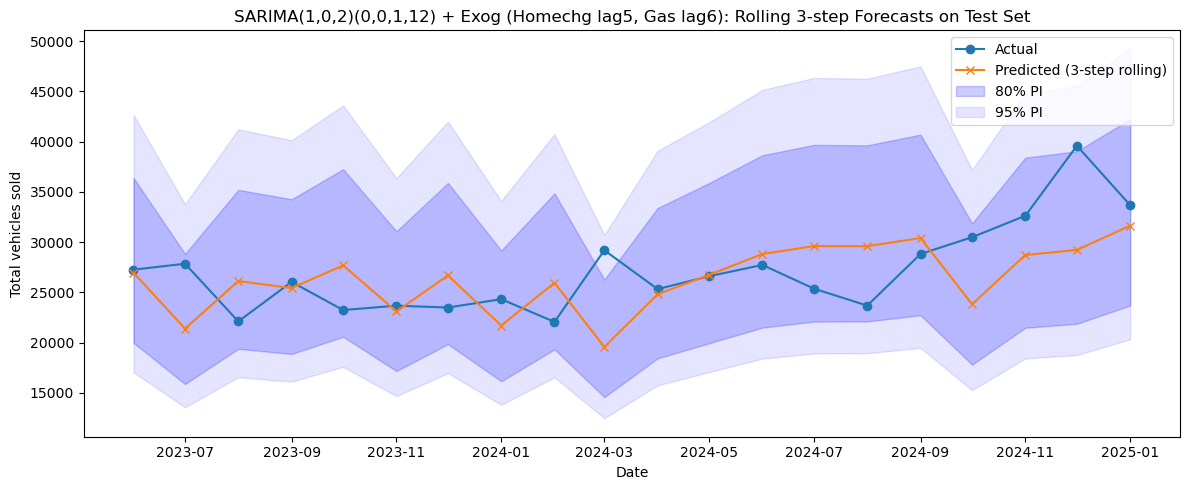

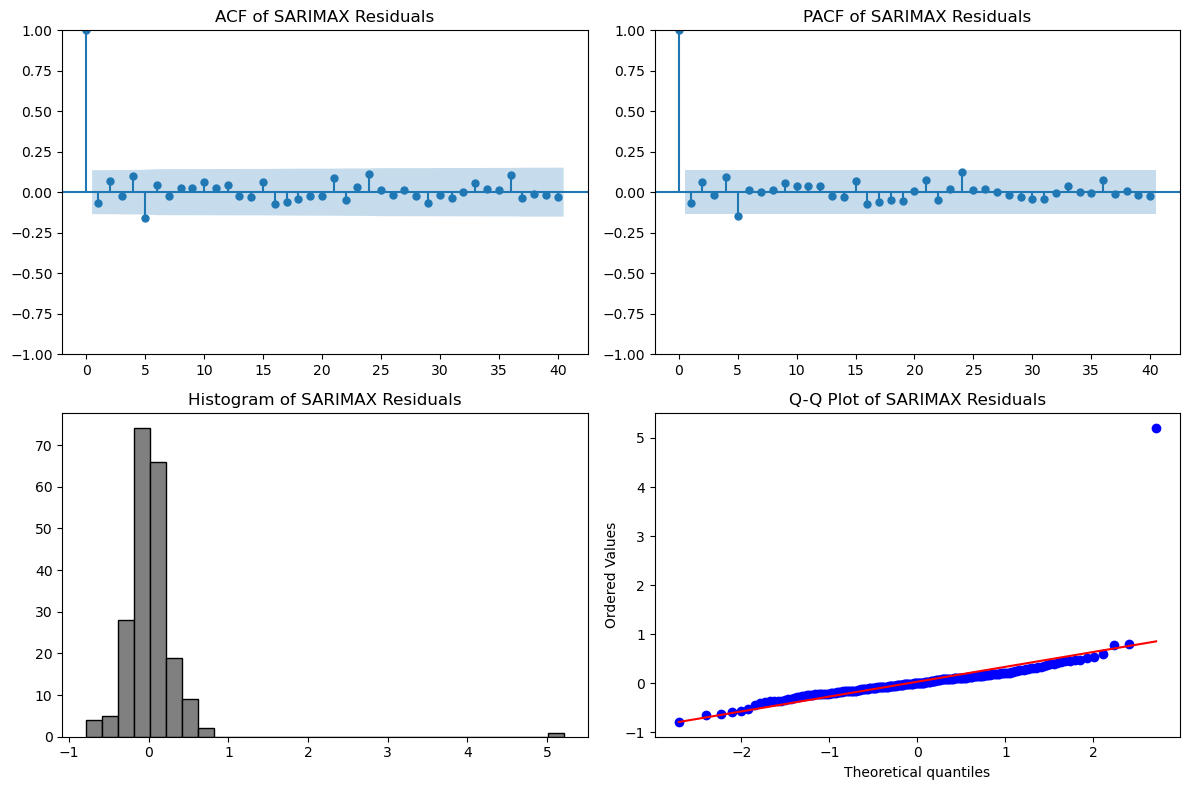

Ljung-Box test p-values (no autocorrelation if > 0.05):


In [ ]:
# --- Evaluate SARIMAX (Homechg lag5, Gas lag6) on TEST SET ---

homechg_bc = boxcox_all['Home charging (G)']
gas_bc     = boxcox_all['Gasoline (Euro95) - Average price (F)']
target_bc  = boxcox_all[target]

# Use all data up to end of validation as history, test as hold-out
history_y        = list(target_bc[:val_end])
history_homechg  = list(homechg_bc[:val_end])
history_gas      = list(gas_bc[:val_end])

test_y        = target_bc[val_end:]
test_homechg  = homechg_bc[val_end:]
test_gas      = gas_bc[val_end:]

horizon = 3
lags    = [5, 6]  # lags for homechg, gas

predictions_bc = []
conf_int_80    = []
conf_int_95    = []

for t in range(len(test_y) - horizon + 1):
    # Lag exogenous variables
    homechg_hist = np.array(history_homechg)
    gas_hist     = np.array(history_gas)

    homechg_hist_lag5 = np.roll(homechg_hist, lags[0]); homechg_hist_lag5[:lags[0]] = np.nan
    gas_hist_lag6     = np.roll(gas_hist, lags[1]); gas_hist_lag6[:lags[1]] = np.nan

    # Align all (drop first 6 for max lag)
    y_hist = np.array(history_y)[lags[1]:]
    exog_hist = np.column_stack([
        homechg_hist_lag5[lags[1]:], gas_hist_lag6[lags[1]:]
    ])

    # Fit SARIMAX on history
    model = SARIMAX(
        y_hist,
        exog=exog_hist,
        order=(1, 0, 2),
        seasonal_order=(0, 0, 1, 12),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    fitted = model.fit(disp=False)

    # Recursive 3-step forecast with intervals
    temp_history_y        = history_y.copy()
    temp_history_homechg  = history_homechg.copy()
    temp_history_gas      = history_gas.copy()
    for step in range(horizon):
        idx = t + step
        homechg_exog_full = np.concatenate([np.array(temp_history_homechg)[-lags[0]:], [test_homechg[idx]]])
        gas_exog_full     = np.concatenate([np.array(temp_history_gas)[-lags[1]:], [test_gas[idx]]])
        homechg_exog_lag5 = np.roll(homechg_exog_full, lags[0])[lags[0]:]
        gas_exog_lag6     = np.roll(gas_exog_full, lags[1])[lags[1]:]
        exog_next = np.column_stack([
            homechg_exog_lag5, gas_exog_lag6
        ])
        res = fitted.get_forecast(steps=1, exog=exog_next)
        yhat = res.predicted_mean[0]
        ci_80 = res.conf_int(alpha=0.20)[0]
        ci_95 = res.conf_int(alpha=0.05)[0]
        temp_history_y.append(yhat)
        temp_history_homechg.append(test_homechg[idx])
        temp_history_gas.append(test_gas[idx])
    predictions_bc.append(yhat)
    conf_int_80.append(ci_80)
    conf_int_95.append(ci_95)

    # Update rolling history with actuals for next window
    history_y.append(test_y[t])
    history_homechg.append(test_homechg[t])
    history_gas.append(test_gas[t])

# --- Invert Box–Cox & compute metrics ---
lam, shift = boxcox_lambdas_all[target]
def inv_boxcox(y, lam):
    return np.exp(y) if lam == 0 else np.power(lam * y + 1, 1/lam)

pred_bc = np.array(predictions_bc)
pred_orig  = inv_boxcox(pred_bc, lam) - shift
actuals    = y_test.values[horizon-1:]

conf_int_80 = np.array(conf_int_80)
conf_int_95 = np.array(conf_int_95)
ci_80_lower = inv_boxcox(conf_int_80[:, 0], lam) - shift
ci_80_upper = inv_boxcox(conf_int_80[:, 1], lam) - shift
ci_95_lower = inv_boxcox(conf_int_95[:, 0], lam) - shift
ci_95_upper = inv_boxcox(conf_int_95[:, 1], lam) - shift

rmse_rolling = np.sqrt(mean_squared_error(actuals, pred_orig))
mape_rolling = mean_absolute_percentage_error(actuals, pred_orig)
print(f"Test RMSE (3-step rolling): {rmse_rolling:.2f}")
print(f"Test MAPE (3-step rolling): {mape_rolling:.2%}")

# --- Plot results ---
x_dates = df["Time Period (T)"][val_end+horizon-1:]
plt.figure(figsize=(12, 5))
plt.plot(x_dates, actuals, label='Actual', marker='o')
plt.plot(x_dates, pred_orig, label='Predicted (3-step rolling)', marker='x')
plt.fill_between(x_dates, ci_80_lower, ci_80_upper, color='blue', alpha=0.2, label='80% PI')
plt.fill_between(x_dates, ci_95_lower, ci_95_upper, color='blue', alpha=0.1, label='95% PI')
plt.title('SARIMA(1,0,2)(0,0,1,12) + Exog (Homechg lag5, Gas lag6): Rolling 3-step Forecasts on Test Set')
plt.xlabel('Date')
plt.ylabel('Total vehicles sold')
plt.legend()
plt.tight_layout()
plt.show()

# --- Residual diagnostics ---
import scipy.stats as stats

residuals = fitted.resid

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
plot_acf(residuals, ax=axes[0, 0], lags=40)
axes[0, 0].set_title("ACF of SARIMAX Residuals")
plot_pacf(residuals, ax=axes[0, 1], lags=40, method='ywm')
axes[0, 1].set_title("PACF of SARIMAX Residuals")
axes[1, 0].hist(residuals, bins=30, color='gray', edgecolor='black')
axes[1, 0].set_title("Histogram of SARIMAX Residuals")
stats.probplot(residuals, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title("Q-Q Plot of SARIMAX Residuals")
plt.tight_layout()
plt.show()

lb_test = acorr_ljungbox(residuals, lags=[10, 20, 30], return_df=True)
print("Ljung-Box test p-values (no autocorrelation if > 0.05):")

### Cartax and gas on test

Test RMSE (3-step rolling): 4618.95
Test MAPE (3-step rolling): 12.58%


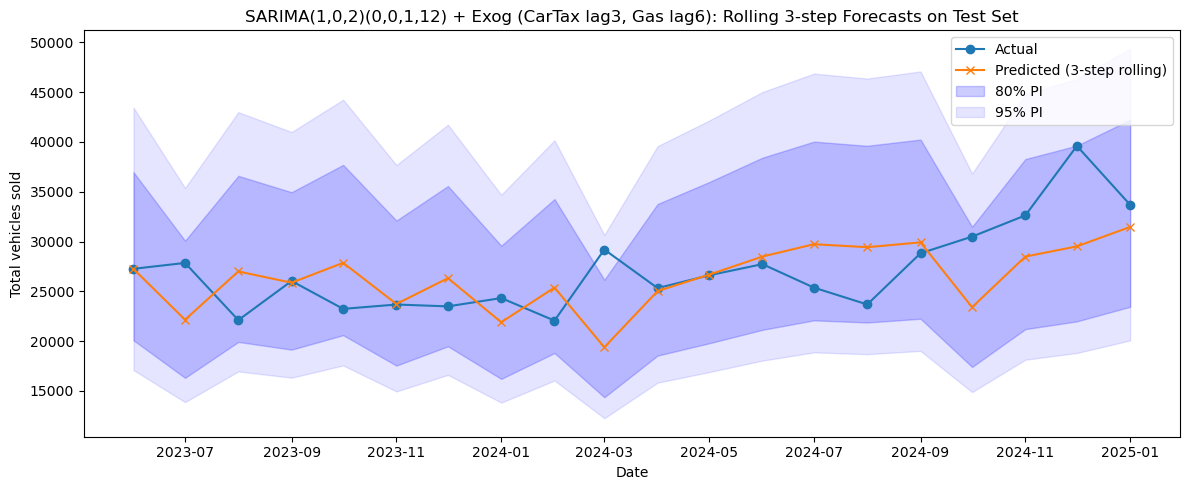

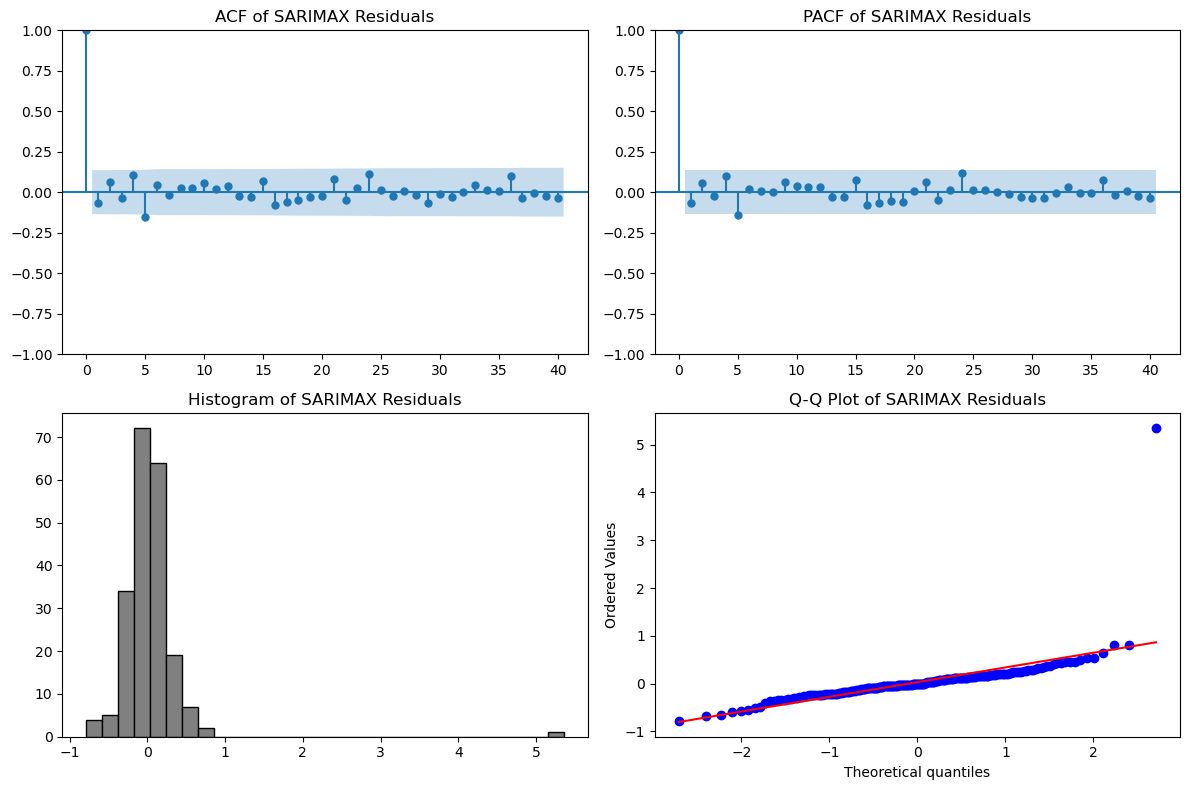

Ljung-Box test p-values (no autocorrelation if > 0.05):
      lb_stat  lb_pvalue
10  11.026582   0.355451
20  16.017983   0.715508
30  22.312504   0.842436


In [ ]:
# --- Evaluate SARIMAX (CarTax lag3, Gas lag6) on TEST SET ---

car_tax_bc = boxcox_all['Company car tax rate (%)']
gas_bc     = boxcox_all['Gasoline (Euro95) - Average price (F)']
target_bc  = boxcox_all[target]

# Use all data up to end of validation as history, test as hold-out
history_y      = list(target_bc[:val_end])
history_tax    = list(car_tax_bc[:val_end])
history_gas    = list(gas_bc[:val_end])

test_y      = target_bc[val_end:]
test_tax    = car_tax_bc[val_end:]
test_gas    = gas_bc[val_end:]

horizon = 3
lags    = [3, 6]  # lags for car tax, gas

predictions_bc = []
conf_int_80    = []
conf_int_95    = []

for t in range(len(test_y) - horizon + 1):
    # Lag exogenous variables
    tax_hist = np.array(history_tax)
    gas_hist = np.array(history_gas)

    tax_hist_lag3 = np.roll(tax_hist, lags[0]); tax_hist_lag3[:lags[0]] = np.nan
    gas_hist_lag6 = np.roll(gas_hist, lags[1]); gas_hist_lag6[:lags[1]] = np.nan

    # Align all (drop first 6 for max lag)
    y_hist = np.array(history_y)[lags[1]:]
    exog_hist = np.column_stack([
        tax_hist_lag3[lags[1]:], gas_hist_lag6[lags[1]:]
    ])

    # Fit SARIMAX on history
    model = SARIMAX(
        y_hist,
        exog=exog_hist,
        order=(1, 0, 2),
        seasonal_order=(0, 0, 1, 12),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    fitted = model.fit(disp=False)

    # Recursive 3-step forecast with intervals
    temp_history_y      = history_y.copy()
    temp_history_tax    = history_tax.copy()
    temp_history_gas    = history_gas.copy()
    for step in range(horizon):
        idx = t + step
        tax_exog_full = np.concatenate([np.array(temp_history_tax)[-lags[0]:], [test_tax[idx]]])
        gas_exog_full = np.concatenate([np.array(temp_history_gas)[-lags[1]:], [test_gas[idx]]])
        tax_exog_lag3 = np.roll(tax_exog_full, lags[0])[lags[0]:]
        gas_exog_lag6 = np.roll(gas_exog_full, lags[1])[lags[1]:]
        exog_next = np.column_stack([
            tax_exog_lag3, gas_exog_lag6
        ])
        res = fitted.get_forecast(steps=1, exog=exog_next)
        yhat = res.predicted_mean[0]
        ci_80 = res.conf_int(alpha=0.20)[0]
        ci_95 = res.conf_int(alpha=0.05)[0]
        temp_history_y.append(yhat)
        temp_history_tax.append(test_tax[idx])
        temp_history_gas.append(test_gas[idx])
    predictions_bc.append(yhat)
    conf_int_80.append(ci_80)
    conf_int_95.append(ci_95)

    # Update rolling history with actuals for next window
    history_y.append(test_y[t])
    history_tax.append(test_tax[t])
    history_gas.append(test_gas[t])

# --- Invert Box–Cox & compute metrics ---
lam, shift = boxcox_lambdas_all[target]
def inv_boxcox(y, lam):
    return np.exp(y) if lam == 0 else np.power(lam * y + 1, 1/lam)

pred_bc = np.array(predictions_bc)
pred_orig  = inv_boxcox(pred_bc, lam) - shift
actuals    = y_test.values[horizon-1:]

conf_int_80 = np.array(conf_int_80)
conf_int_95 = np.array(conf_int_95)
ci_80_lower = inv_boxcox(conf_int_80[:, 0], lam) - shift
ci_80_upper = inv_boxcox(conf_int_80[:, 1], lam) - shift
ci_95_lower = inv_boxcox(conf_int_95[:, 0], lam) - shift
ci_95_upper = inv_boxcox(conf_int_95[:, 1], lam) - shift

rmse_rolling = np.sqrt(mean_squared_error(actuals, pred_orig))
mape_rolling = mean_absolute_percentage_error(actuals, pred_orig)
print(f"Test RMSE (3-step rolling): {rmse_rolling:.2f}")
print(f"Test MAPE (3-step rolling): {mape_rolling:.2%}")

# --- Plot results ---
x_dates = df["Time Period (T)"][val_end+horizon-1:]
plt.figure(figsize=(12, 5))
plt.plot(x_dates, actuals, label='Actual', marker='o')
plt.plot(x_dates, pred_orig, label='Predicted (3-step rolling)', marker='x')
plt.fill_between(x_dates, ci_80_lower, ci_80_upper, color='blue', alpha=0.2, label='80% PI')
plt.fill_between(x_dates, ci_95_lower, ci_95_upper, color='blue', alpha=0.1, label='95% PI')
plt.title('SARIMA(1,0,2)(0,0,1,12) + Exog (CarTax lag3, Gas lag6): Rolling 3-step Forecasts on Test Set')
plt.xlabel('Date')
plt.ylabel('Total vehicles sold')
plt.legend()
plt.tight_layout()
plt.show()

# --- Residual diagnostics ---
import scipy.stats as stats

residuals = fitted.resid

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
plot_acf(residuals, ax=axes[0, 0], lags=40)
axes[0, 0].set_title("ACF of SARIMAX Residuals")
plot_pacf(residuals, ax=axes[0, 1], lags=40, method='ywm')
axes[0, 1].set_title("PACF of SARIMAX Residuals")
axes[1, 0].hist(residuals, bins=30, color='gray', edgecolor='black')
axes[1, 0].set_title("Histogram of SARIMAX Residuals")
stats.probplot(residuals, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title("Q-Q Plot of SARIMAX Residuals")
plt.tight_layout()
plt.show()

lb_test = acorr_ljungbox(residuals, lags=[10, 20, 30], return_df=True)
print("Ljung-Box test p-values (no autocorrelation if > 0.05):")
print(lb_test[['lb_stat', 'lb_pvalue']])

### All features on test 


Test RMSE (3-step rolling): 5172.46
Test MAPE (3-step rolling): 15.84%


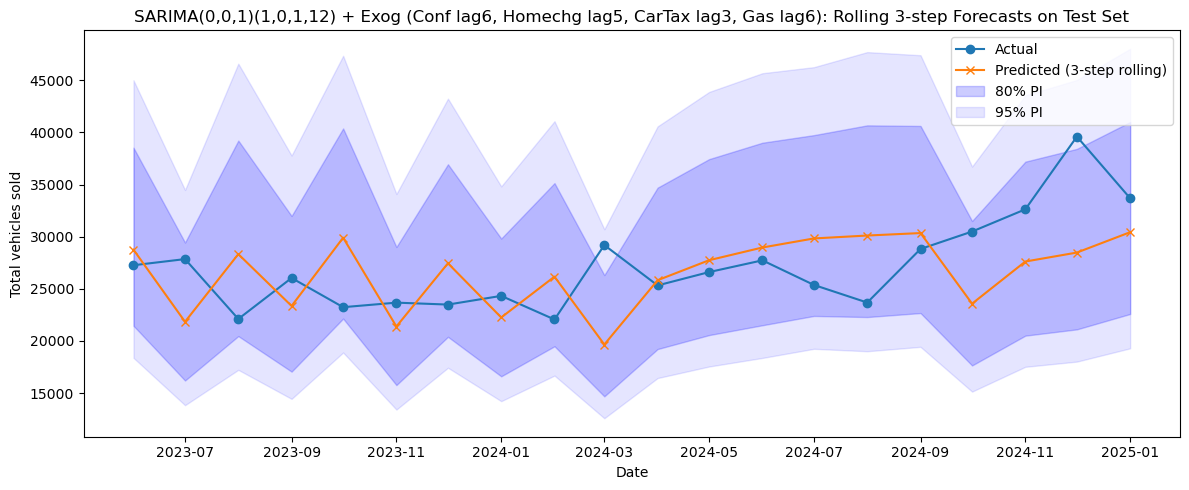

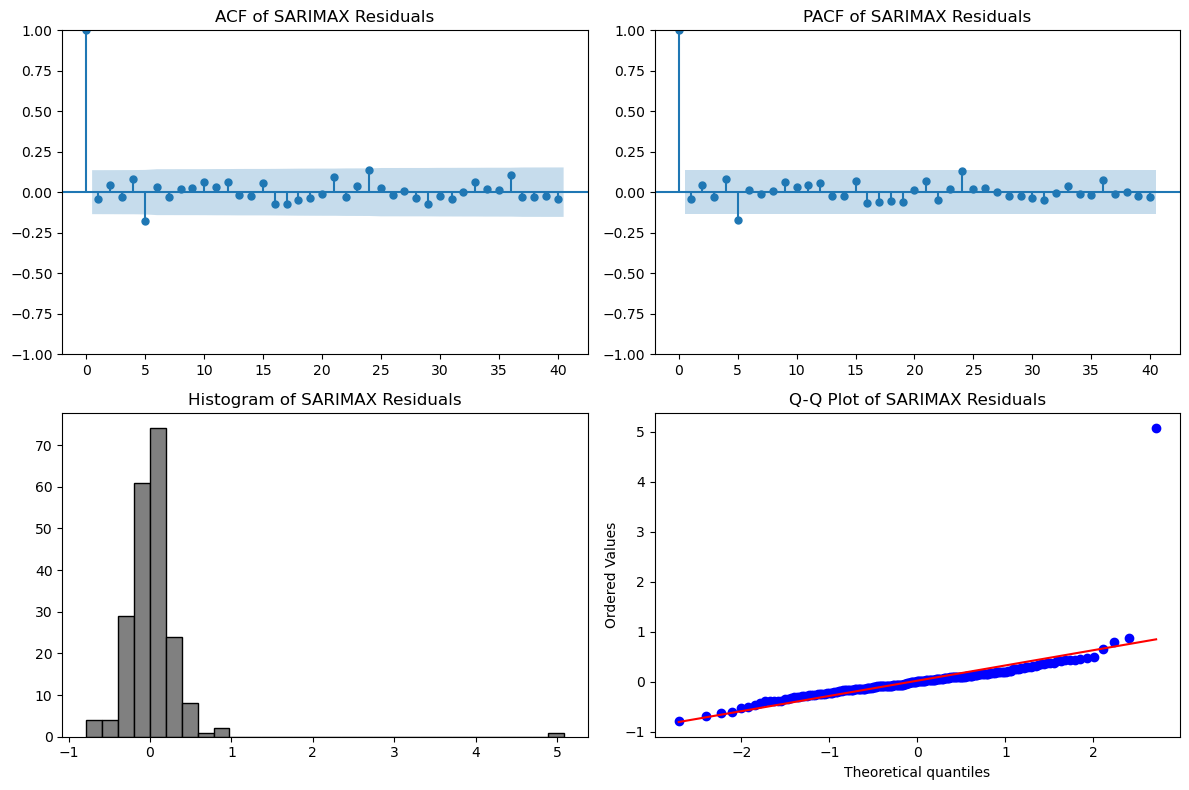

Ljung-Box test p-values (no autocorrelation if > 0.05):
      lb_stat  lb_pvalue
10  11.191649   0.342783
20  16.522554   0.683723
30  25.139298   0.718234


In [ ]:


# ─── 1. Prepare data ───────────────────────────────────────────────────────────
conf_bc    = boxcox_all['Consumer confidence (E)']
homechg_bc = boxcox_all['Home charging (G)']
car_tax_bc = boxcox_all['Company car tax rate (%)']
gas_bc     = boxcox_all['Gasoline (Euro95) - Average price (F)']
target_bc  = boxcox_all[target]

history_y        = list(target_bc[:val_end])
history_conf     = list(conf_bc[:val_end])
history_homechg  = list(homechg_bc[:val_end])
history_tax      = list(car_tax_bc[:val_end])
history_gas      = list(gas_bc[:val_end])

test_y        = target_bc[val_end:]
test_conf     = conf_bc[val_end:]
test_homechg  = homechg_bc[val_end:]
test_tax      = car_tax_bc[val_end:]
test_gas      = gas_bc[val_end:]

horizon = 3
lags    = [6, 5, 3, 6]  # lags for conf, homechg, tax, gas

predictions_bc = []
conf_int_80    = []
conf_int_95    = []

# ─── 2. Rolling loop ────────────────────────────────────────────────────────────
for t in range(len(test_y) - horizon + 1):
    # Lag all exogenous variables
    conf_hist    = np.array(history_conf)
    homechg_hist = np.array(history_homechg)
    tax_hist     = np.array(history_tax)
    gas_hist     = np.array(history_gas)

    conf_hist_lag6    = np.roll(conf_hist, lags[0]); conf_hist_lag6[:lags[0]] = np.nan
    homechg_hist_lag5 = np.roll(homechg_hist, lags[1]); homechg_hist_lag5[:lags[1]] = np.nan
    tax_hist_lag3     = np.roll(tax_hist, lags[2]); tax_hist_lag3[:lags[2]] = np.nan
    gas_hist_lag6     = np.roll(gas_hist, lags[3]); gas_hist_lag6[:lags[3]] = np.nan

    # Align all (drop first 6)
    y_hist = np.array(history_y)[6:]
    exog_hist = np.column_stack([
        conf_hist_lag6[6:], homechg_hist_lag5[6:], tax_hist_lag3[6:], gas_hist_lag6[6:]
    ])

    # Fit SARIMAX on history
    model = SARIMAX(
        y_hist,
        exog=exog_hist,
        order=(1, 0, 2),
        seasonal_order=(0, 0, 1, 12),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    fitted = model.fit(disp=False)

    # Recursive 3-step forecast with intervals
    temp_history_y        = history_y.copy()
    temp_history_conf     = history_conf.copy()
    temp_history_homechg  = history_homechg.copy()
    temp_history_tax      = history_tax.copy()
    temp_history_gas      = history_gas.copy()
    for step in range(horizon):
        idx = t + step
        conf_exog_full    = np.concatenate([np.array(temp_history_conf)[-lags[0]:], [test_conf[idx]]])
        homechg_exog_full = np.concatenate([np.array(temp_history_homechg)[-lags[1]:], [test_homechg[idx]]])
        tax_exog_full     = np.concatenate([np.array(temp_history_tax)[-lags[2]:], [test_tax[idx]]])
        gas_exog_full     = np.concatenate([np.array(temp_history_gas)[-lags[3]:], [test_gas[idx]]])
        conf_exog_lag6    = np.roll(conf_exog_full, lags[0])[lags[0]:]
        homechg_exog_lag5 = np.roll(homechg_exog_full, lags[1])[lags[1]:]
        tax_exog_lag3     = np.roll(tax_exog_full, lags[2])[lags[2]:]
        gas_exog_lag6     = np.roll(gas_exog_full, lags[3])[lags[3]:]
        exog_next = np.column_stack([
            conf_exog_lag6, homechg_exog_lag5, tax_exog_lag3, gas_exog_lag6
        ])
        res = fitted.get_forecast(steps=1, exog=exog_next)
        yhat = res.predicted_mean[0]
        ci_80 = res.conf_int(alpha=0.20)[0]
        ci_95 = res.conf_int(alpha=0.05)[0]
        temp_history_y.append(yhat)
        temp_history_conf.append(test_conf[idx])
        temp_history_homechg.append(test_homechg[idx])
        temp_history_tax.append(test_tax[idx])
        temp_history_gas.append(test_gas[idx])
    predictions_bc.append(yhat)
    conf_int_80.append(ci_80)
    conf_int_95.append(ci_95)

    # Update rolling history with actuals for next window
    history_y.append(test_y[t])
    history_conf.append(test_conf[t])
    history_homechg.append(test_homechg[t])
    history_tax.append(test_tax[t])
    history_gas.append(test_gas[t])

# ─── 3. Invert Box–Cox & compute metrics ────────────────────────────────────────
lam, shift = boxcox_lambdas_all[target]
def inv_boxcox(y, lam):
    return np.exp(y) if lam == 0 else np.power(lam * y + 1, 1/lam)

pred_bc = np.array(predictions_bc)
pred_orig  = inv_boxcox(pred_bc, lam) - shift
actuals    = y_test.values[horizon-1:]

conf_int_80 = np.array(conf_int_80)
conf_int_95 = np.array(conf_int_95)
ci_80_lower = inv_boxcox(conf_int_80[:, 0], lam) - shift
ci_80_upper = inv_boxcox(conf_int_80[:, 1], lam) - shift
ci_95_lower = inv_boxcox(conf_int_95[:, 0], lam) - shift
ci_95_upper = inv_boxcox(conf_int_95[:, 1], lam) - shift

rmse_rolling = np.sqrt(mean_squared_error(actuals, pred_orig))
mape_rolling = mean_absolute_percentage_error(actuals, pred_orig)
print(f"Test RMSE (3-step rolling): {rmse_rolling:.2f}")
print(f"Test MAPE (3-step rolling): {mape_rolling:.2%}")

# ─── 4. Plot results ────────────────────────────────────────────────────────────
x_dates = df["Time Period (T)"][val_end+horizon-1:]
plt.figure(figsize=(12, 5))
plt.plot(x_dates, actuals, label='Actual', marker='o')
plt.plot(x_dates, pred_orig, label='Predicted (3-step rolling)', marker='x')
plt.fill_between(x_dates, ci_80_lower, ci_80_upper, color='blue', alpha=0.2, label='80% PI')
plt.fill_between(x_dates, ci_95_lower, ci_95_upper, color='blue', alpha=0.1, label='95% PI')
plt.title('SARIMA(0,0,1)(1,0,1,12) + Exog (Conf lag6, Homechg lag5, CarTax lag3, Gas lag6): Rolling 3-step Forecasts on Test Set')
plt.xlabel('Date')
plt.ylabel('Total vehicles sold')
plt.legend()
plt.tight_layout()
plt.show()

# ─── 5. Residual diagnostics ────────────────────────────────────────────────────
import scipy.stats as stats

# Get residuals from the last fitted SARIMAX model in the rolling loop
residuals = fitted.resid

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# ACF plot
plot_acf(residuals, ax=axes[0, 0], lags=40)
axes[0, 0].set_title("ACF of SARIMAX Residuals")

# PACF plot
plot_pacf(residuals, ax=axes[0, 1], lags=40, method='ywm')
axes[0, 1].set_title("PACF of SARIMAX Residuals")

# Histogram
axes[1, 0].hist(residuals, bins=30, color='gray', edgecolor='black')
axes[1, 0].set_title("Histogram of SARIMAX Residuals")

# Q-Q plot
stats.probplot(residuals, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title("Q-Q Plot of SARIMAX Residuals")

plt.tight_layout()
plt.show()

# Ljung-Box test for autocorrelation (white noise)
lb_test = acorr_ljungbox(residuals, lags=[10, 20, 30], return_df=True)
print("Ljung-Box test p-values (no autocorrelation if > 0.05):")
print(lb_test[['lb_stat', 'lb_pvalue']])

MAPE values are all in a similar range (15–18%), which suggests no feature is dramatically improving or worsening the forecast.
RMSE for "All on test" is higher than for "All" on validation, which is expected due to test set uncertainty, but the drop in MAPE (to 15.84%) is a bit unusual—typically, RMSE and MAPE move together. This could be due to outliers or a shift in the test set distribution.
Adding exogenous features does not drastically improve RMSE/MAPE compared to baseline, which may indicate:
The target is mostly explained by its own lags.
Exogenous features are not strongly predictive, or lag choices could be further optimized.
No negative RMSE/MAPE or extreme values, so the model is numerically stable.